<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Denmark/VWSDE/VWSDE_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "VWSDKDKK"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-25 13:37:10,044 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-25 13:37:10,046 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for VWSDKDKK
2019-08-25 13:38:50,506 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-25 13:45:13,466 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-25 13:48:32,904 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-25 13:51:47,805 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-25 13:55:09,858 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-25 13:58:25,378 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-25 14:01:48,312 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-25 14:05:10,616 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  4.46798  4.47797  4.36997  4.38998  3.182474
2018-01-02 09:00:00  4.38998  4.39998  4.34897  4.39188  3.115560
2018-01-02 10:00:00  4.39297  4.41988  4.37797  4.40998  2.035282
2018-01-02 11:00:00  4.40997  4.42498  4.40397  4.40898  1.822899
2018-01-02 12:00:00  4.40897  4.44097  4.40097  4.41898  1.182626
...                      ...      ...      ...      ...       ...
2018-12-28 11:00:00  4.95098  4.95398  4.91697  4.91788  4.960000
2018-12-28 12:00:00  4.91897  4.92987  4.91197  4.92987  3.790000
2018-12-28 13:00:00  4.92888  4.94087  4.92098  4.93097  3.620000
2018-12-28 14:00:00  4.93297  4.94498  4.92187  4.93898  4.640000
2018-12-28 15:00:00  4.93887  4.93998  4.90298  4.91987  6.160000

[1974 rows x 5 columns]

Open         High          Low        Close       Volume
count  1974.000000  1974.000000  1974.000000  1974.000000  1974.000000
mean      4.299118     4.317412     4.281563     4.299776     5.646954
std       0.288331     0.289700     0.288229     0.289128     2.476539
min       3.783880     3.821270     3.765980     3.815880     0.030000
25%       4.100970     4.117970     4.084203     4.100980     3.970000
50%       4.249975     4.267930     4.231925     4.248980     5.230000
75%       4.392980     4.410723     4.374620     4.392978     6.840000
max       5.273980     5.317880     5.237870     5.273970    26.500000

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2018-01-10 10:00:00  4.24898  4.25397  4.22997  4.24098  2.520922   10          2         10             31    10             0               0                 0      1        1     2        2             1           2  4.270570  4.291591 -4.453236  4.261913  4.304764  4.278626    4.313975    4.317475  4.444067  4.325724  4.230636  4.330674  4.293918  4.325724  4.239973  4.359190                4.462230                 4.325724                4.189217                4.530484                 4.325724                4.120964                4.598737                 4.325724                4.052711                4.666990                 4.325724                3.984457  4.304764  4.256792  4.361540                4.441271                 4.304764                4.168258                4.509524                 4.304764                4.100004                4.577778                 4.304764                4.031751                4.646031                 4.304764                3.963498   
2018-01-10 11:00:00  4.24097  4.27298  4.23897  4.25098  3.408910   10          2         10             31    11             0               0                 0      1        1     2        2             1           2  4.269590  4.291041 -4.430110  4.250187  4.292812  4.272221    4.313975    4.312475  4.426299  4.307725  4.226037  4.302224  4.277309  4.307725  4.245980  4.353911                4.440894                 4.307725                4.174556                4.507479                 4.307725                4.107971                4.574064                 4.307725                4.041386                4.640648                 4.307725                3.974802  4.292812  4.249379  4.354365                4.425982                 4.292812                4.159643                4.492566                 4.292812                4.093058                4.559151                 4.292812                4.026474                4.625736                 4.292812                3.959889   
2018-01-10 12:00:00  4.2

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000    1924.000000  1924.000000   1924.000000     1924.000000       1924.000000  1924.000000  1924.000000  1924.000000  1924.000000   1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000             1924.000000              1924.000000             1924.000000             1924.000000              1924.000000             1924.000000             1924.000000              1924.000000             1924.000000             1924.000000              1924.000000             1924.000000  1924.000000  1924.000000  1924.000000             1924.000000              1924.000000             1924.000000             1924.000000              1924.000000             1924.000000             1924.000000   
mean      4.297972     4.316301     4.280645     4.298828     5.698784    15.881497     2.010395   186.538462      30.417360    10.880457      0.032744        0.028586          0.004158     6.637214     2.549376    27.218295     2.010395      1.984927    27.218295     4.299127     4.297618    -0.196999     4.298772     4.297713     4.299081     4.297658     4.296640     4.295066     4.297693     4.298762     4.297679     4.298051     4.297693     4.298619     4.295586                4.350879                 4.297693                4.244508                4.377471                 4.297693                4.217915                4.404064                 4.297693                4.191322                4.430657                 4.297693                4.164729     4.297713     4.298561     4.295917                4.350898                 4.297713                4.244527                4.377491                 4.297713                4.217935                4.404084   
std       0.291741     0.293120     0.291686     0.292582     2.469846     8.594553     1.404952   101.852366       0.859882     2.336100      0.178013        0.166684          0.064365     3.352476     1.105065    14.547005     1.404952      1.406575    14.547005     0.288621     0.280769     4.306010     0.293547     0.288600     0.292090     0.289144     0.289003     0.291700     0.289571     0.293075     0.289970     0.290277     0.289571     0.291651     0.283380                0.293053                 0.289571                0.290559                0.296429                 0.289571                0.292723                0.300851                 0.289571                0.295973                0.306272                 0.289571                0.300273     0.288600     0.291556     0.284328                0.292209                 0.288600                0.289477                0.295651                 0.288600                0.291592                0.300140   
min       3.783880     3.821270     3.765980     3.815880     0.030000     1.000000     0.000000    10.000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-10 10:00:00  0.312127  0.289120  0.315234  0.291546  0.094104   10          2         10             31    10             0               0                 0      1        1     2        2             1           2  0.307620  0.320812  0.081989  0.306426  0.336024  0.309024    0.339235    0.337357  0.436940  0.347221  0.286322  0.352450  0.327609  0.347221  0.293407  0.369444                0.405755                 0.347221                0.306429                0.425626                 0.347221                0.318217                0.443749                 0.347221                0.328626                0.460645                 0.347221                0.337786  0.336024  0.306389  0.371351                0.388949                 0.336024                0.272425                0.408950                 0.336024                0.285684                0.427559                 0.336024                0.298607                0.444652                 0.336024   
2018-01-10 11:00:00  0.306751  0.301822  0.321349  0.298404  0.127651   10          2         10             31    11             0               0                 0      1        1     2        2             1           2  0.306910  0.320391  0.084182  0.298390  0.327428  0.304429    0.339235    0.333838  0.425491  0.334443  0.283188  0.332406  0.315897  0.334443  0.297568  0.365510                0.391149                 0.334443                0.296504                0.410435                 0.334443                0.310020                0.428026                 0.334443                0.321938                0.444427                 0.334443                0.332426  0.327428  0.301221  0.366034                0.378531                 0.327428                0.266371                0.397813                 0.327428                0.281138                0.415752                 0.327428                0.295381                0.432227                 0.327428   
2018-01-10 12:00:00  0.312798  0.292467  0.319311  0.300462  0.070604   10          2         10         

52

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp8e62bl93
  JVM stdout: /tmp/tmp8e62bl93/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp8e62bl93/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 6 days
H2O cluster name:           H2O_from_python_unknownUser_312613
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_142452_mod...  0.769437  1.847596              0.307023  0.643606  0.414228
1  DeepLearning_grid_1_AutoML_20190825_142452_mod...  0.765142  0.651364              0.301600  0.482386  0.232696
2  DeepLearning_grid_1_AutoML_20190825_142452_mod...  0.762672  0.672064              0.280713  0.493318  0.243362
3  DeepLearning_grid_1_AutoML_20190825_142452_mod...  0.758698  1.082267              0.317332  0.567764  0.322356
4  DeepLearning_grid_1_AutoML_20190825_142452_mod...  0.747101  0.667090              0.301439  0.491290  0.241366
5  DeepLearning_grid_1_AutoML_20190825_142452_mod...  0.742805  9.751442              0.343643  0.682781  0.466190
6  DeepLearning_grid_1_AutoML_20190825_142452_mod...  0.741731  1.564072              0.364530  0.617951  0.381864
7  DeepLearning_grid_1_AutoML_20190825_142452_mod...  0.731207  0.645164              0.348690  0.478250  0.228723
8  DeepLearning_grid_1_AutoML_20190825_142452_mod...  0.720683  0.652028              0.348529  0.479059  0.229498
9              DeepLearning_1_AutoML_20190825_142452  0.494792  0.708730              0.500000  0.507379  0.257433

variable  relative_importance  scaled_importance  percentage
0               CDL3LINESTRIKE             1.000000           1.000000    0.002886
1            CDL3WHITESOLDIERS             0.998452           0.998452    0.002882
2                    CDLINNECK             0.985841           0.985841    0.002846
3           CDLEVENINGDOJISTAR             0.982391           0.982391    0.002836
4                    CDLONNECK             0.982222           0.982222    0.002835
...                        ...                  ...                ...         ...
1033   BBANDS_lowerband_12_4_3             0.284077           0.284077    0.000820
1034             MINMAX_max_20             0.283867           0.283867    0.000819
1035  BBANDS_middleband_14_2_4             0.283409           0.283409    0.000818
1036   BBANDS_upperband_12_5_2             0.281978           0.281978    0.000814
1037                      SINH             0.277323           0.277323    0.000800

[1038 rows x 4 columns]

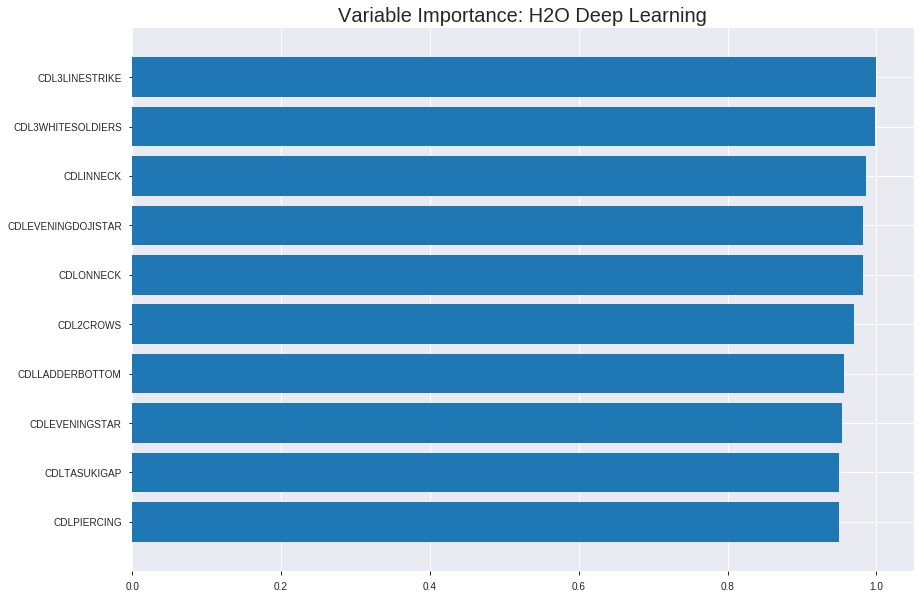

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_142452_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.13689923499194548
RMSE: 0.3699989662038875
LogLoss: 0.4446790352284998
Mean Per-Class Error: 0.15744168887884447
AUC: 0.9129869784569571
pr_auc: 0.8361489282993959
Gini: 0.8259739569139142
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7086553555363446: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      600  113  0.1585   (113.0/713.0)
1      99   534  0.1564   (99.0/633.0)
Total  699  647  0.1575   (212.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.708655     0.834375  147
max f2                       0.230571     0.879522  287
max f0point5                 0.899357     0.849906  78
max accuracy                 0.710068     0.842496  146
max precision                0.999815     1         0
max recall                   0.000477082  1         398
max specificity              0.999815     1         0
max absolute_mcc             0.708655     0.684416  147
max min_per_class_accuracy   0.710068     0.842022  146
max mean_per_class_accuracy  0.708655     0.842558  147

Gains/Lift Table: Avg response rate: 47.03 %, avg score: 55.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.999928           2.12638   2.12638            1                0.999964    1                           0.999964            0.0221169       0.0221169                  112.638   112.638
    2        0.0200594                   0.99981            2.12638   2.12638            1                0.999871    1                           0.999919            0.0205371       0.042654                   112.638   112.638
    3        0.0304606                   0.999621           2.12638   2.12638            1                0.999739    1                           0.999858            0.0221169       0.0647709                  112.638   112.638
    4        0.0401189                   0.999273           2.12638   2.12638            1                0.999448    1                           0.999759            0.0205371       0.0853081                  112.638   112.638
    5        0.0505201                   0.998997           2.12638   2.12638            1                0.999152    1                           0.999634            0.0221169       0.107425                   112.638   112.638
    6        0.100297                    0.996387           2.09465   2.11063            0.985075         0.997869    0.992593                    0.998758            0.104265        0.21169                    109.465   111.063
    7        0.150074                    0.992145           2.03117   2.08428            0.955224         0.994539    0.980198                    0.997359            0.101106        0.312796                   103.117   108.428
    8        0.200594                    0.984979           1.97003   2.0555             0.926471         0.988842    0.966667                    0.995214            0.0995261       0.412322                   97.0031   105.55
    9        0.300149                    0.955043           1.85662   1.98954            0.873134         0.972897    0.935644                    0.987812            0.184834        0.597156                   85.6617   98.9536
    10       0.400446                    0.859483           1.41759   1.84628            0.666667         0.918663    0.868275                    0.970493            0.14218         0.739336                   41.7588   84.6284
    11       0.5                         0.65736            1.1584    1.70932            0.544776         0.768872    0.803863                    0.930348            0.115324        0.85466                    15.8402   70.9321
    12       0.600297                    0.407077           0.598537  1.52373            0.281481         0.531348    0.716584                    0.863684            0.0600316       0.914692                   -40.1463  52.3732
    13       0.699851                    0.164587           0.460187  1.37244            0.216418         0.267128    0.645435                    0.778823            0.0458136       0.960506                   -53.9813  37.2442
    14       0.800149                    0.0441913          0.204763  1.22608            0.0962963        0.0936955   0.576602                    0.692944            0.0205371       0.981043                   -79.5237  22.6076
    15       0.899703                    0.00673661         0.174554  1.10972            0.0820896        0.0208086   0.521883                    0.61857             0.0173776       0.99842                    -82.5446  10.9722
    16       1                           3.79201e-07        0.015751  1                  0.00740741       0.00202303  0.470282  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2794218566164194
RMSE: 0.528603685776423
LogLoss: 1.1362820670685787
Mean Per-Class Error: 0.3606403013182674
AUC: 0.6855263517017385
pr_auc: 0.6441499988312267
Gini: 0.37105270340347696
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12201958126607505: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      86   121  0.5845   (121.0/207.0)
1      27   150  0.1525   (27.0/177.0)
Total  113  271  0.3854   (148.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.12202      0.669643  270
max f2                       3.6376e-10   0.811182  382
max f0point5                 0.896021     0.610413  94
max accuracy                 0.9075       0.645833  92
max precision                0.999997     1         0
max recall                   3.6376e-10   1         382
max specificity              0.999997     1         0
max absolute_mcc             0.9075       0.294293  92
max min_per_class_accuracy   0.480914     0.623188  188
max mean_per_class_accuracy  0.358572     0.63936   219

Gains/Lift Table: Avg response rate: 46.09 %, avg score: 48.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.999929           2.16949   2.16949            1                0.999976     1                           0.999976            0.0225989       0.0225989                  116.949   116.949
    2        0.0208333                   0.999292           1.08475   1.62712            0.5              0.999763     0.75                        0.999869            0.0112994       0.0338983                  8.47458   62.7119
    3        0.03125                     0.998655           2.16949   1.80791            1                0.99894      0.833333                    0.99956             0.0225989       0.0564972                  116.949   80.791
    4        0.0416667                   0.996683           2.16949   1.89831            1                0.997842     0.875                       0.99913             0.0225989       0.079096                   116.949   89.8305
    5        0.0520833                   0.994986           1.08475   1.73559            0.5              0.995578     0.8                         0.99842             0.0112994       0.0903955                  8.47458   73.5593
    6        0.101562                    0.983865           1.48439   1.61321            0.684211         0.989987     0.74359                     0.994311            0.0734463       0.163842                   48.4389   61.3212
    7        0.151042                    0.96188            1.48439   1.57101            0.684211         0.974984     0.724138                    0.98798             0.0734463       0.237288                   48.4389   57.1011
    8        0.200521                    0.934941           1.37021   1.52146            0.631579         0.947033     0.701299                    0.977876            0.0677966       0.305085                   37.0205   52.1462
    9        0.299479                    0.829972           1.08475   1.37716            0.5              0.889882     0.634783                    0.9488              0.107345        0.412429                   8.47458   37.7155
    10       0.401042                    0.657159           1.05693   1.29606            0.487179         0.747978     0.597403                    0.897942            0.107345        0.519774                   5.69318   29.606
    11       0.5                         0.46749            1.19893   1.27684            0.552632         0.564969     0.588542                    0.832041            0.118644        0.638418                   19.893    27.6836
    12       0.598958                    0.291506           1.02765   1.23567            0.473684         0.383784     0.569565                    0.757981            0.101695        0.740113                   2.76539   23.5667
    13       0.700521                    0.124642           1.0013    1.20169            0.461538         0.20123      0.553903                    0.677263            0.101695        0.841808                   0.130378  20.1689
    14       0.799479                    0.0269855          0.570919  1.12361            0.263158         0.0753984    0.517915                    0.602765            0.0564972       0.898305                   -42.9081  12.3613
    15       0.898438                    0.000728799        0.456735  1.05016            0.210526         0.00947308   0.484058                    0.537417            0.0451977       0.943503                   -54.3265  5.01597
    16       1                           1.10767e-10        0.55628   1                  0.25641          0.0001


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 14:29:23  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 14:29:27  6.493 sec         148 obs/sec       0.402675  1             542        0.65341          3.21039             -0.713832      0.627007        0.350867           1.82261          0.479198                         0.65902            3.50999               -0.747898        0.635279          0.568088             1.62712            0.40625
    2019-08-25 14:29:51  30.053 sec        151 obs/sec       2.82838   7             3807       0.550646         1.51913             -0.217144      0.702738        0.633564           2.12638          0.41159                          0.555766           2.47926               -0.243093        0.665848          0.624744             2.16949            0.403646
    2019-08-25 14:30:13  52.922 sec        154 obs/sec       5.24146   13            7055       0.568743         1.70583             -0.298463      0.675611        0.564671           1.9745           0.407132                         0.56665            2.77938               -0.292255        0.648871          0.617487             2.16949            0.416667
    2019-08-25 14:30:39  1 min 18.337 sec  158 obs/sec       8.12407   20            10935      0.555764         1.31057             -0.239876      0.738749        0.581887           1.9745           0.358098                         0.611634           2.44095               -0.505573        0.615628          0.508847             0                  0.434896
    2019-08-25 14:31:01  1 min 40.825 sec  165 obs/sec       10.9621   27            14755      0.515998         1.15758             -0.0687934     0.798357        0.640312           1.9745           0.300892                         0.52521            1.14547               -0.110158        0.739949          0.695777             2.16949            0.309896
    2019-08-25 14:31:23  2 min  2.777 sec  170 obs/sec       13.8328   34            18619      0.511829         1.10082             -0.05159       0.756766        0.738735           2.12638          0.352897                         0.56189            2.23023               -0.270637        0.650127          0.611302             1.08475            0.53125
    2019-08-25 14:31:45  2 min 24.632 sec  175 obs/sec       16.7623   41            22562      0.452085         0.739226            0.17958        0.803961        0.714366           2.12638          0.256315                         0.517746           1.14308               -0.0788286       0.707006          0.667987             2.16949            0.34375
    2019-08-25 14:32:08  2 min 47.595 sec  179 obs/sec       19.9814   49            26895      0.427217         0.638518            0.267355       0.843738        0.808486           2.12638          0.251114                         0.545146           1.51182               -0.196036        0.682224          0.636063             1.62712            0.403646
    2019-08-25 14:32:31  3

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDL3LINESTRIKE            1.0                    1.0                  0.0028863737518944545
CDL3WHITESOLDIERS         0.9984516501426697     0.9984516501426697   0.0028819046355075067
CDLINNECK                 0.9858410954475403     0.9858410954475403   0.0028455058614386556
CDLEVENINGDOJISTAR        0.9823911786079407     0.9823911786079407   0.0028355481120266165
CDLONNECK                 0.9822220206260681     0.9822220206260681   0.0028350598588678163
---                       ---                    ---                  ---
BBANDS_lowerband_12_4_3   0.2840766906738281     0.2840766906738281   0.0008199515034859776
MINMAX_max_20             0.28386661410331726    0.28386661410331726  0.0008193451439869671
BBANDS_middleband_14_2_4  0.28340864181518555    0.28340864181518555  0.0008180232647954087
BBANDS_upperband_12_5_2   0.2819775938987732     0.2819775938987732   0.0008138927256517728
SINH                      0.2773225009441376     0.2773225009441376   0.0008004563875348837


See the whole table with table.as_data_frame()


('accuracy', 0.7098445595854922)

('F1', 0.7572016460905349)

('auc', 0.7694372852233676)

('logloss', 1.8475957373442848)

('mean_per_class_error', 0.2898410652920962)

('rmse', 0.6436055124473091)

('mse', 0.4142280556525633)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


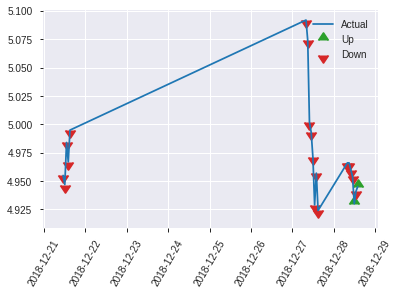


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4142280556525633
RMSE: 0.6436055124473091
LogLoss: 1.8475957373442848
Mean Per-Class Error: 0.2898410652920962
AUC: 0.7694372852233676
pr_auc: 0.7307703392867387
Gini: 0.5388745704467353
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.000968034357072035: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      42   54   0.5625   (54.0/96.0)
1      5    92   0.0515   (5.0/97.0)
Total  47   146  0.3057   (59.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000968034  0.757202  145
max f2                       0.00011548   0.864528  172
max f0point5                 0.0126753    0.720824  84
max accuracy                 0.0126753    0.709845  84
max precision                0.917349     1         0
max recall                   0.00011548   1         172
max specificity              0.917349     1         0
max absolute_mcc             0.000968034  0.449605  145
max min_per_class_accuracy   0.00910111   0.690722  94
max mean_per_class_accuracy  0.0126753    0.710159  84

Gains/Lift Table: Avg response rate: 50.26 %, avg score:  7.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.812713           1.98969   1.98969            1                0.871987     1                           0.871987            0.0206186       0.0206186                  98.9691    98.9691
    2        0.0207254                   0.720221           1.98969   1.98969            1                0.771604     1                           0.821795            0.0206186       0.0412371                  98.9691    98.9691
    3        0.0310881                   0.624589           0.994845  1.65808            0.5              0.690608     0.833333                    0.778066            0.0103093       0.0515464                  -0.515464  65.8076
    4        0.0414508                   0.557681           1.98969   1.74098            1                0.587543     0.875                       0.730435            0.0206186       0.0721649                  98.9691    74.0979
    5        0.0518135                   0.455574           1.98969   1.79072            1                0.526867     0.9                         0.689722            0.0206186       0.0927835                  98.9691    79.0722
    6        0.103627                    0.229476           1.19381   1.49227            0.6              0.332621     0.75                        0.511171            0.0618557       0.154639                   19.3814    49.2268
    7        0.150259                    0.131683           1.32646   1.44081            0.666667         0.15921      0.724138                    0.401942            0.0618557       0.216495                   32.646     44.0811
    8        0.202073                    0.0921669          1.98969   1.58155            1                0.111924     0.794872                    0.327578            0.103093        0.319588                   98.9691    58.1549
    9        0.300518                    0.0406221          1.36137   1.50942            0.684211         0.0602693    0.758621                    0.240012            0.134021        0.453608                   36.1367    50.9421
    10       0.398964                    0.0175435          1.36137   1.47289            0.684211         0.0263494    0.74026                     0.18729             0.134021        0.587629                   36.1367    47.2888
    11       0.502591                    0.00878437         0.994845  1.37432            0.5              0.0122871    0.690722                    0.151207            0.103093        0.690722                   -0.515464  37.4322
    12       0.601036                    0.00516774         0.942485  1.30359            0.473684         0.00680504   0.655172                    0.127555            0.0927835       0.783505                   -5.75149   30.359
    13       0.699482                    0.00255807         0.942485  1.25277            0.473684         0.00371743   0.62963                     0.110126            0.0927835       0.876289                   -5.75149   25.2768
    14       0.797927                    0.000591777        0.837765  1.20157            0.421053         0.00129827   0.603896                    0.096699            0.0824742       0.958763                   -16.2235   20.1566
    15       0.896373                    0.000106012        0.418882  1.11561            0.210526         0.000279945  0.560694                    0.0861096           0.0412371       1                          -58.1118   11.5607
    16       1                           7.2564e-07         0         1                  0    

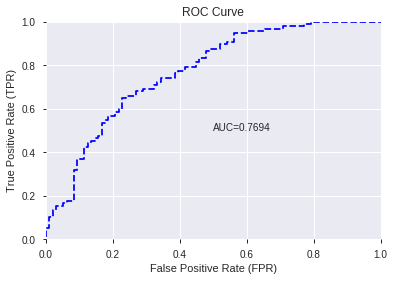

This function is available for GLM models only


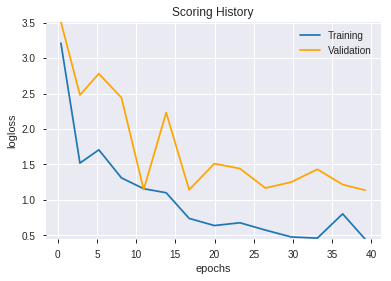

--2019-08-25 14:54:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  16.7MB/s    in 23s     

2019-08-25 14:54:26 (15.3 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_142452_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_142452_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_982d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_145440_model_3  0.777384  0.576350              0.280445  0.444750  0.197802
1  DeepLearning_grid_1_AutoML_20190825_145440_model_8  0.769008  0.577893              0.301654  0.445677  0.198628
2  DeepLearning_grid_1_AutoML_20190825_145440_model_6  0.763960  0.577042              0.301332  0.444773  0.197823
3  DeepLearning_grid_1_AutoML_20190825_145440_model_7  0.763960  0.644767              0.285868  0.471332  0.222154
4  DeepLearning_grid_1_AutoML_20190825_145440_model_9  0.760202  0.579804              0.306701  0.446965  0.199778
5  DeepLearning_grid_1_AutoML_20190825_145440_model_1  0.759235  0.902526              0.322702  0.509145  0.259228
6  DeepLearning_grid_1_AutoML_20190825_145440_model_5  0.757947  0.591963              0.306808  0.448393  0.201056
7  DeepLearning_grid_1_AutoML_20190825_145440_model_2  0.748335  0.728158              0.285868  0.473682  0.224374
8  DeepLearning_grid_1_AutoML_20190825_145440_model_4  0.721542  0.829787              0.316957  0.505635  0.255667
9               DeepLearning_1_AutoML_20190825_145440  0.714669  0.673908              0.338273  0.484872  0.235101

variable  relative_importance  scaled_importance  percentage
0        CDLEVENINGSTAR             1.000000           1.000000    0.031242
1          CDLTHRUSTING             0.974101           0.974101    0.030432
2    CDLEVENINGDOJISTAR             0.964086           0.964086    0.030120
3             CDLONNECK             0.935782           0.935782    0.029235
4        CDL3LINESTRIKE             0.908059           0.908059    0.028369
5           CDLPIERCING             0.903914           0.903914    0.028240
6          CDLTASUKIGAP             0.898684           0.898684    0.028076
7             CDLINNECK             0.896648           0.896648    0.028013
8        CDLMORNINGSTAR             0.877136           0.877136    0.027403
9       CDLHOMINGPIGEON             0.864240           0.864240    0.027000
10            CDL2CROWS             0.864057           0.864057    0.026995
11    CDLDARKCLOUDCOVER             0.855718           0.855718    0.026734
12    CDL3WHITESOLDIERS             0.849295           0.849295    0.026533
13   CDLMORNINGDOJISTAR             0.847208           0.847208    0.026468
14  CDLGAPSIDESIDEWHITE             0.820643           0.820643    0.025638
15    CDLSTALLEDPATTERN             0.819693           0.819693    0.025609
16      CDLLADDERBOTTOM             0.810776           0.810776    0.025330
17      CDLADVANCEBLOCK             0.712807           0.712807    0.022269
18    CDLINVERTEDHAMMER             0.703897           0.703897    0.021991
19        CDLHANGINGMAN             0.703082           0.703082    0.021965
20                  BOP             0.632249           0.632249    0.019752
21        CDLHIKKAKEMOD             0.631045           0.631045    0.019715
22      CDLSHOOTINGSTAR             0.627727           0.627727    0.019611
23   CDLCLOSINGMARUBOZU             0.622829           0.622829    0.019458
24     CDLDRAGONFLYDOJI             0.594404           0.594404    0.018570
25   CDLSEPARATINGLINES             0.585250           0.585250    0.018284
26            CDLTAKURI             0.583046           0.583046    0.018215
27                FLOOR             0.533356           0.533356    0.016663
28          CDLLONGLINE             0.529514           0.529514    0.016543
29                 hour             0.525794           0.525794    0.016427
30                 CEIL             0.525248           0.525248    0.016410
31            CDLHAMMER             0.515956           0.515956    0.016119
32         is_month_end             0.514775           0.514775    0.016082
33               TRANGE             0.487641           0.487641    0.015235
34          CDLMARUBOZU             0.487211           0.487211    0.015221
35       STOCHRSI_fastk             0.486681           0.486681    0.015205
36       is_month_start             0.483356           0.483356    0.015101
37                  DIV             0.481350           0.481350    0.015038
38                  SUB             0.480618           0.480618    0.015015
39       CDLMATCHINGLOW             0.479807           0.479807    0.014990
40    CDLGRAVESTONEDOJI             0.470468           0.470468    0.014698
41           CDL3INSIDE             0.438851           0.438851    0.013710
42               BETA_8             0.416656           0.416656    0.013017
43       CDLHARAMICROSS             0.409125           0.409125    0.012782
44               ULTOSC             0.408342           0.408342    0.012757
45         weekday_name             0.398530           0.398530    0.012451
46       CDLSPINNINGTOP             0.396766           0.396766    0.012396
47         CDLENGULFING             0.386094           0.386094    0.012062
48  CDLXSIDEGAP3METHODS             0.346740           0.346740    0.010833
49    CDLLONGLEGGEDDOJI             0.319327           0.319327    0.009976

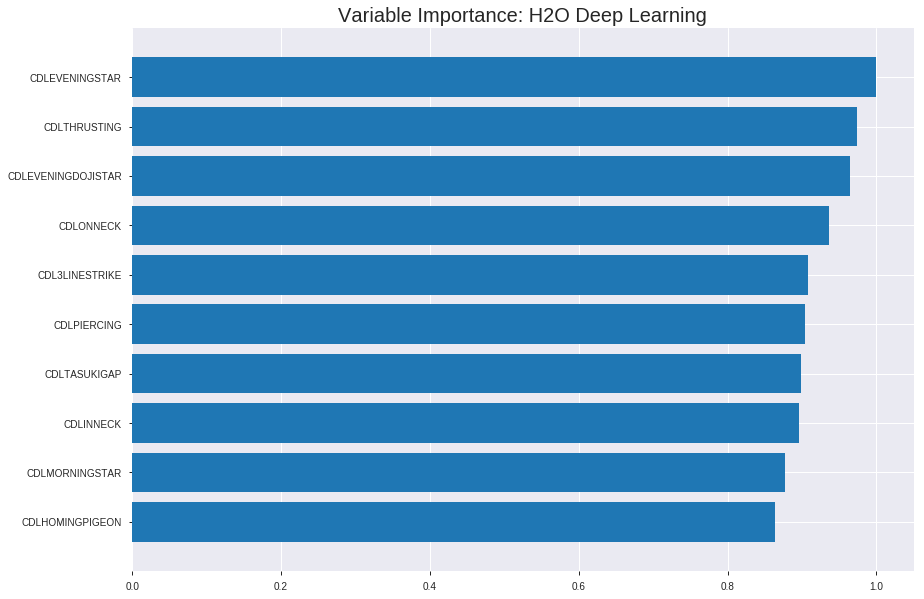

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_145440_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18403237773931677
RMSE: 0.4289899506274206
LogLoss: 0.5695858364659183
Mean Per-Class Error: 0.2638219569316397
AUC: 0.7990689718586663
pr_auc: 0.7587196952041453
Gini: 0.5981379437173326
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4054623590205337: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      482  231  0.324    (231.0/713.0)
1      135  498  0.2133   (135.0/633.0)
Total  617  729  0.2719   (366.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.405462     0.731278  229
max f2                       0.101112     0.830147  349
max f0point5                 0.528622     0.720843  180
max accuracy                 0.478588     0.73477   204
max precision                0.9994       1         0
max recall                   8.0342e-05   1         399
max specificity              0.9994       1         0
max absolute_mcc             0.44288      0.471609  216
max min_per_class_accuracy   0.476343     0.734597  205
max mean_per_class_accuracy  0.44288      0.736178  216

Gains/Lift Table: Avg response rate: 47.03 %, avg score: 46.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.998204           2.12638   2.12638            1                0.999236   1                           0.999236            0.0221169       0.0221169                  112.638   112.638
    2        0.0200594                   0.995025           1.79925   1.96887            0.846154         0.996788   0.925926                    0.998057            0.0173776       0.0394945                  79.9247   96.8873
    3        0.0304606                   0.989526           1.82261   1.91893            0.857143         0.992854   0.902439                    0.996281            0.0189573       0.0584518                  82.2613   91.893
    4        0.0401189                   0.979798           2.12638   1.96887            1                0.98387    0.925926                    0.993293            0.0205371       0.0789889                  112.638   96.8873
    5        0.0505201                   0.976228           1.82261   1.93876            0.857143         0.978159   0.911765                    0.990177            0.0189573       0.0979463                  82.2613   93.876
    6        0.100297                    0.900354           1.84075   1.89012            0.865672         0.939931   0.888889                    0.96524             0.0916272       0.189573                   84.0749   89.0118
    7        0.150074                    0.822662           1.77727   1.85269            0.835821         0.862634   0.871287                    0.931208            0.0884676       0.278041                   77.7275   85.269
    8        0.200594                    0.764608           1.6886    1.81136            0.794118         0.790136   0.851852                    0.895678            0.0853081       0.363349                   68.8598   81.1363
    9        0.300149                    0.660864           1.38056   1.66847            0.649254         0.712347   0.784653                    0.834871            0.137441        0.50079                    38.0562   66.8473
    10       0.400446                    0.560957           1.30733   1.57802            0.614815         0.609789   0.742115                    0.778496            0.131122        0.631912                   30.7331   57.802
    11       0.5                         0.455801           1.14253   1.49131            0.537313         0.508629   0.701337                    0.724763            0.113744        0.745656                   14.2534   49.1311
    12       0.600297                    0.345839           0.771798  1.3711             0.362963         0.396745   0.644802                    0.669958            0.0774092       0.823065                   -22.8202  37.1096
    13       0.699851                    0.248566           0.65061   1.26861            0.30597          0.295046   0.596603                    0.616627            0.0647709       0.887836                   -34.939   26.8606
    14       0.800149                    0.143062           0.567035  1.18067            0.266667         0.196047   0.555246                    0.563908            0.056872        0.944708                   -43.2965  18.0665
    15       0.899703                    0.0548543          0.31737   1.08514            0.149254         0.094498   0.510322                    0.511967            0.0315956       0.976303                   -68.263   8.51398
    16       1                           3.41959e-14        0.236265  1                  0.111111         0.0199602  0.470282                    0.4



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20063527150161287
RMSE: 0.44792328751875904
LogLoss: 0.6472768769116242
Mean Per-Class Error: 0.2885859330221894
AUC: 0.7644040503288845
pr_auc: 0.7405583776388063
Gini: 0.528808100657769
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4440617717175962: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      146  61   0.2947   (61.0/207.0)
1      50   127  0.2825   (50.0/177.0)
Total  196  188  0.2891   (111.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444062     0.69589   187
max f2                       0.0969976    0.823643  323
max f0point5                 0.5439       0.702211  147
max accuracy                 0.5439       0.716146  147
max precision                0.999998     1         0
max recall                   1.71024e-05  1         380
max specificity              0.999998     1         0
max absolute_mcc             0.5439       0.427023  147
max min_per_class_accuracy   0.450321     0.710145  185
max mean_per_class_accuracy  0.444062     0.711414  187

Gains/Lift Table: Avg response rate: 46.09 %, avg score: 45.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.996593           2.16949   2.16949            1                0.998546   1                           0.998546            0.0225989       0.0225989                  116.949   116.949
    2        0.0208333                   0.994066           2.16949   2.16949            1                0.995281   1                           0.996913            0.0225989       0.0451977                  116.949   116.949
    3        0.03125                     0.992463           2.16949   2.16949            1                0.993322   1                           0.995716            0.0225989       0.0677966                  116.949   116.949
    4        0.0416667                   0.990726           1.62712   2.0339             0.75             0.991625   0.9375                      0.994693            0.0169492       0.0847458                  62.7119   103.39
    5        0.0520833                   0.984607           2.16949   2.06102            1                0.986924   0.95                        0.993139            0.0225989       0.107345                   116.949   106.102
    6        0.101562                    0.904689           1.71276   1.89135            0.789474         0.953817   0.871795                    0.973982            0.0847458       0.19209                    71.2756   89.1352
    7        0.151042                    0.80869            1.59857   1.79544            0.736842         0.855998   0.827586                    0.935332            0.079096        0.271186                   59.8573   79.5441
    8        0.200521                    0.754743           1.59857   1.74686            0.736842         0.78251    0.805195                    0.897623            0.079096        0.350282                   59.8573   74.6863
    9        0.299479                    0.629964           1.37021   1.6224             0.631579         0.682921   0.747826                    0.826678            0.135593        0.485876                   37.0205   62.2402
    10       0.401042                    0.53109            1.33507   1.54964            0.615385         0.575577   0.714286                    0.763088            0.135593        0.621469                   33.5072   54.9637
    11       0.5                         0.437473           0.970562  1.43503            0.447368         0.478875   0.661458                    0.706837            0.0960452       0.717514                   -2.9438   43.5028
    12       0.598958                    0.357132           0.628011  1.30169            0.289474         0.398218   0.6                         0.655848            0.0621469       0.779661                   -37.1989  30.1695
    13       0.700521                    0.260597           0.778792  1.22588            0.358974         0.302732   0.565056                    0.604653            0.079096        0.858757                   -22.1208  22.5884
    14       0.799479                    0.166129           0.628011  1.15188            0.289474         0.214624   0.530945                    0.556376            0.0621469       0.920904                   -37.1989  15.188
    15       0.898438                    0.0457612          0.456735  1.07531            0.210526         0.100094   0.495652                    0.506119            0.0451977       0.966102                   -54.3265  7.53132
    16       1                           5.86355e-09        0.333768  1                  0.153846         0.0127997  0.460938                    0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 14:56:17  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 14:56:20  1 min 38.438 sec  5354 obs/sec      10        1             13460      0.474622         0.778592            0.0957397      0.751003        0.67982            2.12638          0.323923                         0.479378           0.902229              0.0751417        0.739731          0.693251             2.16949            0.304688
    2019-08-25 14:56:26  1 min 44.737 sec  6182 obs/sec      40        4             53840      0.433954         0.588884            0.244065       0.794114        0.742485           1.9745           0.286033                         0.449113           0.661544              0.188236         0.766396          0.737381             2.16949            0.320312
    2019-08-25 14:56:32  1 min 50.960 sec  7255 obs/sec      80        8             107680     0.42899          0.569586            0.261261       0.799069        0.75872            2.12638          0.271917                         0.447923           0.647277              0.192531         0.764404          0.740558             2.16949            0.289062
    2019-08-25 14:56:38  1 min 56.404 sec  7995 obs/sec      120       12            161520     0.423153         0.553138            0.281226       0.809149        0.760639           1.9745           0.26003                          0.446276           0.650154              0.198458         0.768198          0.732439             2.16949            0.325521
    2019-08-25 14:56:43  2 min  1.568 sec  8519 obs/sec      160       16            215360     0.420738         0.553352            0.289407       0.813236        0.773201           1.9745           0.270431                         0.450307           0.691516              0.183914         0.760392          0.723826             2.16949            0.359375
    2019-08-25 14:56:49  2 min  7.611 sec  9048 obs/sec      210       21            282660     0.422837         0.562289            0.282299       0.811833        0.753481           1.9745           0.26523                          0.446262           0.652523              0.198508         0.77019           0.730911             1.62712            0.304688
    2019-08-25 14:56:55  2 min 13.502 sec  9450 obs/sec      260       26            349960     0.422464         0.561128            0.283565       0.811155        0.775238           2.12638          0.268202                         0.448399           0.669967              0.190813         0.764404          0.734745             2.16949            0.364583
    2019-08-25 14:56:55  2 min 13.624 sec  9444 obs/sec      260       26            349960     0.42899          0.569586            0.261261       0.799069        0.75872            2.12638          0.271917                         0.447923           0.647277              0.192531         0.764404          0.740558             2.16949            0.289062

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
CDLEVENINGSTAR       1.0                    1.0                  0.031241623544132225
CDLTHRUSTING         0.9741007685661316     0.9741007685661316   0.030432489505592953
CDLEVENINGDOJISTAR   0.9640857577323914     0.9640857577323914   0.030119604307334832
CDLONNECK            0.9357820749282837     0.9357820749282837   0.029235351304256373
CDL3LINESTRIKE       0.908059298992157      0.908059298992157    0.028369246774861575
---                  ---                    ---                  ---
weekday_name         0.39852964878082275    0.39852964878082275  0.012450713258385699
CDLSPINNINGTOP       0.3967657685279846     0.3967657685279846   0.0123956067755496
CDLENGULFING         0.3860936462879181     0.3860936462879181   0.012062192350108481
CDLXSIDEGAP3METHODS  0.3467395007610321     0.3467395007610321   0.010832704950656514
CDLLONGLEGGEDDOJI    0.31932681798934937    0.31932681798934937  0.009976288235168882


See the whole table with table.as_data_frame()


('accuracy', 0.7202072538860104)

('F1', 0.7522935779816512)

('auc', 0.7773840206185567)

('logloss', 0.5763501687708521)

('mean_per_class_error', 0.2803908934707904)

('rmse', 0.44474958906320156)

('mse', 0.19780219697188667)

deeplearning prediction progress: |███████████████████████████████████████| 100%


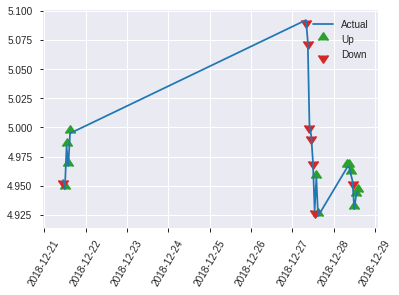


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19780219697188667
RMSE: 0.44474958906320156
LogLoss: 0.5763501687708521
Mean Per-Class Error: 0.2803908934707904
AUC: 0.7773840206185567
pr_auc: 0.7457490100992502
Gini: 0.5547680412371134
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3515310297563629: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      57   39   0.4062   (39.0/96.0)
1      15   82   0.1546   (15.0/97.0)
Total  72   121  0.2798   (54.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.351531     0.752294  120
max f2                       0.10515      0.867621  170
max f0point5                 0.521418     0.716049  76
max accuracy                 0.3596       0.720207  118
max precision                0.999971     1         0
max recall                   0.10515      1         170
max specificity              0.999971     1         0
max absolute_mcc             0.351531     0.45398   120
max min_per_class_accuracy   0.452702     0.680412  95
max mean_per_class_accuracy  0.3596       0.719609  118

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 45.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.999684           1.98969   1.98969            1                0.99984   1                           0.99984             0.0206186       0.0206186                  98.9691    98.9691
    2        0.0207254                   0.988681           1.98969   1.98969            1                0.99593   1                           0.997885            0.0206186       0.0412371                  98.9691    98.9691
    3        0.0310881                   0.972959           1.98969   1.98969            1                0.986113  1                           0.993961            0.0206186       0.0618557                  98.9691    98.9691
    4        0.0414508                   0.962969           1.98969   1.98969            1                0.968504  1                           0.987597            0.0206186       0.0824742                  98.9691    98.9691
    5        0.0518135                   0.955277           0.994845  1.79072            0.5              0.958653  0.9                         0.981808            0.0103093       0.0927835                  -0.515464  79.0722
    6        0.103627                    0.856829           1.39278   1.59175            0.7              0.916405  0.8                         0.949107            0.0721649       0.164948                   39.2784    59.1753
    7        0.150259                    0.78604            1.76861   1.64664            0.888889         0.813898  0.827586                    0.907145            0.0824742       0.247423                   76.8614    64.6641
    8        0.202073                    0.706679           0.994845  1.47951            0.5              0.745461  0.74359                     0.865688            0.0515464       0.298969                   -0.515464  47.9514
    9        0.300518                    0.620599           1.67553   1.54373            0.842105         0.663426  0.775862                    0.79943             0.164948        0.463918                   67.5529    54.3726
    10       0.398964                    0.518529           1.36137   1.49873            0.684211         0.564318  0.753247                    0.741415            0.134021        0.597938                   36.1367    49.8728
    11       0.502591                    0.439679           0.795876  1.35381            0.4              0.479757  0.680412                    0.687465            0.0824742       0.680412                   -20.4124   35.381
    12       0.601036                    0.368259           1.36137   1.35505            0.684211         0.399173  0.681034                    0.640245            0.134021        0.814433                   36.1367    35.5048
    13       0.699482                    0.266449           0.733044  1.26751            0.368421         0.320014  0.637037                    0.595175            0.0721649       0.886598                   -26.6956   26.7507
    14       0.797927                    0.170472           0.837765  1.21449            0.421053         0.225113  0.61039                     0.549518            0.0824742       0.969072                   -16.2235   21.4487
    15       0.896373                    0.0735872          0.314162  1.11561            0.157895         0.13522   0.560694                    0.504017            0.0309278       1                          -68.5838   11.5607
    16       1                           4.82696e-09        0         1                  0                0.027546  0.502591                    0

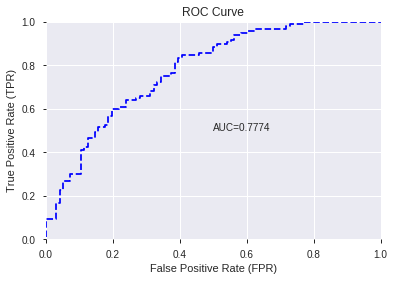

This function is available for GLM models only


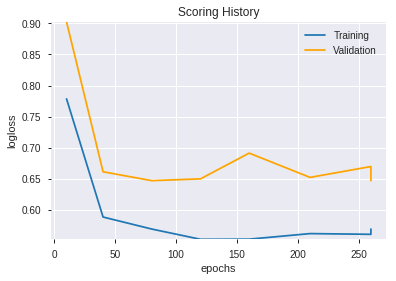

--2019-08-25 15:03:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_145440_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_145440_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_982d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLEVENINGSTAR',
 'CDLTHRUSTING',
 'CDLEVENINGDOJISTAR',
 'CDLONNECK',
 'CDL3LINESTRIKE',
 'CDLPIERCING',
 'CDLTASUKIGAP',
 'CDLINNECK',
 'CDLMORNINGSTAR',
 'CDLHOMINGPIGEON',
 'CDL2CROWS',
 'CDLDARKCLOUDCOVER',
 'CDL3WHITESOLDIERS',
 'CDLMORNINGDOJISTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLSTALLEDPATTERN',
 'CDLLADDERBOTTOM',
 'CDLADVANCEBLOCK',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'BOP',
 'CDLHIKKAKEMOD',
 'CDLSHOOTINGSTAR',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLSEPARATINGLINES',
 'CDLTAKURI',
 'FLOOR',
 'CDLLONGLINE',
 'hour',
 'CEIL',
 'CDLHAMMER',
 'is_month_end',
 'TRANGE',
 'CDLMARUBOZU',
 'STOCHRSI_fastk',
 'is_month_start',
 'DIV',
 'SUB',
 'CDLMATCHINGLOW',
 'CDLGRAVESTONEDOJI',
 'CDL3INSIDE',
 'BETA_8',
 'CDLHARAMICROSS',
 'ULTOSC',
 'weekday_name',
 'CDLSPINNINGTOP',
 'CDLENGULFING',
 'CDLXSIDEGAP3METHODS',
 'CDLLONGLEGGEDDOJI']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_150322_model_1  0.753866  0.577499               0.31744  0.445981  0.198899

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.363077           1.000000    0.108199
1                  hour             0.236455           0.651252    0.070465
2    CDLCLOSINGMARUBOZU             0.204545           0.563366    0.060956
3           CDLLONGLINE             0.143100           0.394131    0.042645
4             CDLHAMMER             0.130997           0.360798    0.039038
5        CDLMATCHINGLOW             0.127242           0.350456    0.037919
6                TRANGE             0.125438           0.345487    0.037381
7        CDLSPINNINGTOP             0.115378           0.317778    0.034383
8                   SUB             0.114537           0.315463    0.034133
9        STOCHRSI_fastk             0.110563           0.304517    0.032949
10               ULTOSC             0.109538           0.301694    0.032643
11                  DIV             0.087161           0.240063    0.025975
12         weekday_name             0.071644           0.197325    0.021350
13      CDLLADDERBOTTOM             0.069573           0.191620    0.020733
14    CDLGRAVESTONEDOJI             0.066488           0.183124    0.019814
15            CDLONNECK             0.064636           0.178024    0.019262
16  CDLXSIDEGAP3METHODS             0.064388           0.177340    0.019188
17         CDLTHRUSTING             0.058970           0.162416    0.017573
18    CDLINVERTEDHAMMER             0.058959           0.162388    0.017570
19          CDLPIERCING             0.057774           0.159123    0.017217
20         CDLENGULFING             0.056760           0.156331    0.016915
21       CDLEVENINGSTAR             0.054886           0.151170    0.016357
22            CDL2CROWS             0.053656           0.147783    0.015990
23        CDLHIKKAKEMOD             0.053309           0.146826    0.015886
24            CDLTAKURI             0.050037           0.137814    0.014911
25            CDLINNECK             0.048418           0.133354    0.014429
26               BETA_8             0.047511           0.130855    0.014158
27     CDLDRAGONFLYDOJI             0.044860           0.123556    0.013369
28      CDLADVANCEBLOCK             0.043838           0.120740    0.013064
29         CDLTASUKIGAP             0.042332           0.116591    0.012615
30           CDL3INSIDE             0.038792           0.106843    0.011560
31    CDLSTALLEDPATTERN             0.038481           0.105985    0.011467
32        CDLHANGINGMAN             0.037841           0.104223    0.011277
33       CDLHARAMICROSS             0.037565           0.103463    0.011195
34      CDLSHOOTINGSTAR             0.033963           0.093543    0.010121
35       CDL3LINESTRIKE             0.032561           0.089680    0.009703
36   CDLSEPARATINGLINES             0.027841           0.076681    0.008297
37                 CEIL             0.026505           0.073001    0.007899
38                FLOOR             0.026450           0.072850    0.007882
39   CDLMORNINGDOJISTAR             0.026290           0.072409    0.007835
40       CDLMORNINGSTAR             0.025854           0.071208    0.007705
41    CDL3WHITESOLDIERS             0.022780           0.062741    0.006789
42    CDLDARKCLOUDCOVER             0.020018           0.055134    0.005965
43          CDLMARUBOZU             0.018332           0.050491    0.005463
44       is_month_start             0.018227           0.050201    0.005432
45      CDLHOMINGPIGEON             0.017027           0.046897    0.005074
46   CDLEVENINGDOJISTAR             0.012370           0.034069    0.003686
47    CDLLONGLEGGEDDOJI             0.008241           0.022697    0.002456
48  CDLGAPSIDESIDEWHITE             0.005668           0.015611    0.001689
49         is_month_end             0.004748           0.013077    0.001415

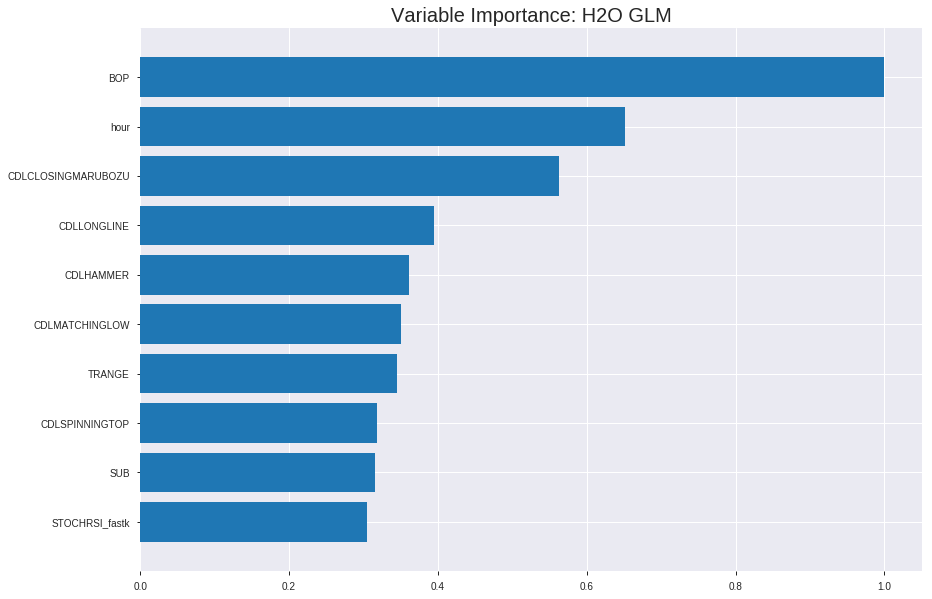

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_150322_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18999349108589042
RMSE: 0.43588242805358696
LogLoss: 0.5621608371050286
Null degrees of freedom: 1345
Residual degrees of freedom: 1295
Null deviance: 1861.1945775256659
Residual deviance: 1513.336973486737
AIC: 1615.336973486737
AUC: 0.7885622240095362
pr_auc: 0.757380375240563
Gini: 0.5771244480190725
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37729895428865834: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      375  338  0.4741   (338.0/713.0)
1      81   552  0.128    (81.0/633.0)
Total  456  890  0.3113   (419.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.377299     0.724885  256
max f2                       0.22931      0.832431  330
max f0point5                 0.574993     0.711715  144
max accuracy                 0.512775     0.719168  175
max precision                0.918771     1         0
max recall                   0.0754975    1         388
max specificity              0.918771     1         0
max absolute_mcc             0.431726     0.435141  223
max min_per_class_accuracy   0.478367     0.7109    196
max mean_per_class_accuracy  0.465514     0.716358  204

Gains/Lift Table: Avg response rate: 47.03 %, avg score: 47.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.87986            1.82261   1.82261            0.857143         0.899063  0.857143                    0.899063            0.0189573       0.0189573                  82.2613   82.2613
    2        0.0200594                   0.859708           1.96281   1.89012            0.923077         0.870298  0.888889                    0.885213            0.0189573       0.0379147                  96.2814   89.0118
    3        0.0304606                   0.841249           1.82261   1.86707            0.857143         0.850334  0.878049                    0.873303            0.0189573       0.056872                   82.2613   86.7067
    4        0.0401189                   0.814167           2.12638   1.9295             1                0.824721  0.907407                    0.861608            0.0205371       0.0774092                  112.638   92.9495
    5        0.0505201                   0.800124           2.12638   1.97003            1                0.806028  0.926471                    0.850165            0.0221169       0.0995261                  112.638   97.0031
    6        0.100297                    0.733535           1.84075   1.90587            0.865672         0.762361  0.896296                    0.806588            0.0916272       0.191153                   84.0749   90.5869
    7        0.150074                    0.681114           1.49164   1.76848            0.701493         0.704922  0.831683                    0.772867            0.0742496       0.265403                   49.1641   76.8476
    8        0.200594                    0.652154           1.78241   1.77199            0.838235         0.666927  0.833333                    0.746186            0.0900474       0.35545                    78.2409   77.1985
    9        0.300149                    0.599808           1.4123    1.65268            0.664179         0.623454  0.777228                    0.705478            0.1406          0.496051                   41.2299   65.2683
    10       0.400446                    0.534253           1.21283   1.54251            0.57037          0.569699  0.725417                    0.67147             0.121643        0.617694                   21.2825   54.2515
    11       0.5                         0.47069            1.09493   1.4534             0.514925         0.500427  0.683507                    0.637414            0.109005        0.726698                   9.49282   45.3397
    12       0.600297                    0.412837           0.897806  1.36057            0.422222         0.441652  0.639851                    0.604706            0.0900474       0.816746                   -10.2194  36.0569
    13       0.699851                    0.354542           0.761689  1.27538            0.358209         0.384003  0.599788                    0.573311            0.0758294       0.892575                   -23.8311  27.5378
    14       0.800149                    0.289841           0.519782  1.18067            0.244444         0.323089  0.555246                    0.541946            0.0521327       0.944708                   -48.0218  18.0665
    15       0.899703                    0.19163            0.349108  1.08865            0.164179         0.242337  0.511974                    0.508794            0.0347551       0.979463                   -65.0892  8.86516
    16       1                           0.0173893          0.204763  1                  0.0962963        0.124822  0.470282                    0.470282         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19925411530430437
RMSE: 0.44637889209090564
LogLoss: 0.5845209521152754
Null degrees of freedom: 383
Residual degrees of freedom: 333
Null deviance: 530.1256103466318
Residual deviance: 448.91209122453154
AIC: 550.9120912245315
AUC: 0.7609105051993778
pr_auc: 0.715014075944042
Gini: 0.5218210103987555
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45934410326438135: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      143  64   0.3092   (64.0/207.0)
1      47   130  0.2655   (47.0/177.0)
Total  190  194  0.2891   (111.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459344     0.700809  193
max f2                       0.283736     0.817734  306
max f0point5                 0.527113     0.703794  159
max accuracy                 0.527113     0.721354  159
max precision                0.952979     1         0
max recall                   0.0897401    1         374
max specificity              0.952979     1         0
max absolute_mcc             0.527113     0.437119  159
max min_per_class_accuracy   0.475956     0.706215  184
max mean_per_class_accuracy  0.527113     0.716163  159

Gains/Lift Table: Avg response rate: 46.09 %, avg score: 47.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.907581           2.16949   2.16949            1                0.936175  1                           0.936175            0.0225989       0.0225989                  116.949   116.949
    2        0.0208333                   0.878027           2.16949   2.16949            1                0.890584  1                           0.913379            0.0225989       0.0451977                  116.949   116.949
    3        0.03125                     0.848379           1.62712   1.9887             0.75             0.862209  0.916667                    0.896323            0.0169492       0.0621469                  62.7119   98.8701
    4        0.0416667                   0.833426           1.62712   1.89831            0.75             0.842294  0.875                       0.882815            0.0169492       0.079096                   62.7119   89.8305
    5        0.0520833                   0.822948           1.62712   1.84407            0.75             0.828513  0.85                        0.871955            0.0169492       0.0960452                  62.7119   84.4068
    6        0.101562                    0.756096           1.59857   1.72447            0.736842         0.788871  0.794872                    0.831478            0.079096        0.175141                   59.8573   72.4468
    7        0.151042                    0.699372           1.48439   1.64582            0.684211         0.726958  0.758621                    0.797239            0.0734463       0.248588                   48.4389   64.5821
    8        0.200521                    0.654526           1.82694   1.69051            0.842105         0.671138  0.779221                    0.766123            0.0903955       0.338983                   82.694    69.0513
    9        0.299479                    0.60357            1.4273    1.60354            0.657895         0.633754  0.73913                     0.722384            0.141243        0.480226                   42.7297   60.3537
    10       0.401042                    0.5445             1.44633   1.56372            0.666667         0.576628  0.720779                    0.685471            0.146893        0.627119                   44.6328   56.3724
    11       0.5                         0.462589           0.970562  1.44633            0.447368         0.499519  0.666667                    0.648668            0.0960452       0.723164                   -2.9438   44.6328
    12       0.598958                    0.410722           0.742194  1.32999            0.342105         0.432307  0.613043                    0.612922            0.0734463       0.79661                    -25.7806  32.9993
    13       0.700521                    0.3539             0.667536  1.23395            0.307692         0.379301  0.568773                    0.579051            0.0677966       0.864407                   -33.2464  23.3949
    14       0.799479                    0.283633           0.742194  1.17308            0.342105         0.318951  0.540717                    0.546856            0.0734463       0.937853                   -25.7806  17.308
    15       0.898438                    0.191438           0.228368  1.06902            0.105263         0.241806  0.492754                    0.513257            0.0225989       0.960452                   -77.1632  6.90248
    16       1                           0.0462524          0.389396  1                  0.179487         0.125375  0.460938                    0.473862          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 15:03:23  0.000 sec   2            18        51            1.36673           1.36488
    2019-08-25 15:03:23  0.038 sec   4            11        51            1.35787           1.35626
    2019-08-25 15:03:23  0.072 sec   6            7.1       51            1.34485           1.34365
    2019-08-25 15:03:23  0.103 sec   8            4.4       51            1.32661           1.32609
    2019-08-25 15:03:23  0.128 sec   10           2.7       51            1.30266           1.30328
    2019-08-25 15:03:23  0.145 sec   12           1.7       51            1.27371           1.27623
    2019-08-25 15:03:23  0.165 sec   14           1.1       51            1.24192           1.24749
    2019-08-25 15:03:23  0.180 sec   16           0.65      51            1.21021           1.2204
    2019-08-25 15:03:23  0.194 sec   18           0.41      51            1.18135           1.19798
    2019-08-25 15:03:23  0.214 sec   20           0.25      51            1.15716           1.18195
    2019-08-25 15:03:23  0.230 sec   22           0.16      51            1.13825           1.17259
    2019-08-25 15:03:23  0.244 sec   24           0.097     51            1.12432           1.16904
    2019-08-25 15:03:23  0.258 sec   26           0.06      51            1.11454           1.16998
    2019-08-25 15:03:23  0.276 sec   28           0.037     51            1.10793           1.17412
    2019-08-25 15:03:23  0.290 sec   30           0.023     51            1.10363           1.18046
    2019-08-25 15:03:23  0.304 sec   32           0.014     51            1.10089           1.18831
    2019-08-25 15:03:23  0.321 sec   34           0.009     51            1.0991            1.19711

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.694300518134715)

('F1', 0.7510204081632653)

('auc', 0.7538659793814433)

('logloss', 0.5774989402160231)

('mean_per_class_error', 0.30670103092783507)

('rmse', 0.44598067233802324)

('mse', 0.19889876009907523)

glm prediction progress: |████████████████████████████████████████████████| 100%


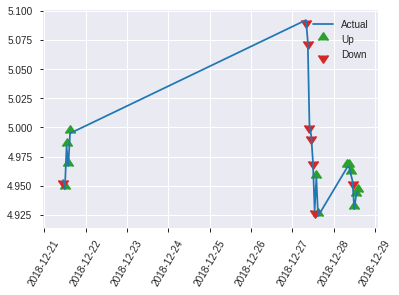


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19889876009907523
RMSE: 0.44598067233802324
LogLoss: 0.5774989402160231
Null degrees of freedom: 192
Residual degrees of freedom: 142
Null deviance: 268.35681432348866
Residual deviance: 222.9145909233849
AIC: 324.91459092338494
AUC: 0.7538659793814433
pr_auc: 0.7230668379356129
Gini: 0.5077319587628866
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3236131966815971: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      40   56   0.5833   (56.0/96.0)
1      5    92   0.0515   (5.0/97.0)
Total  45   148  0.3161   (61.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.323613     0.75102   147
max f2                       0.238858     0.863309  167
max f0point5                 0.556333     0.699301  82
max accuracy                 0.38141      0.694301  133
max precision                0.942164     1         0
max recall                   0.192537     1         175
max specificity              0.942164     1         0
max absolute_mcc             0.323613     0.431738  147
max min_per_class_accuracy   0.513719     0.670103  94
max mean_per_class_accuracy  0.38141      0.693299  133

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 48.97 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.894622           1.98969    1.98969            1                0.927164  1                           0.927164            0.0206186       0.0206186                  98.9691    98.9691
    2        0.0207254                   0.866061           1.98969    1.98969            1                0.892665  1                           0.909915            0.0206186       0.0412371                  98.9691    98.9691
    3        0.0310881                   0.841935           1.98969    1.98969            1                0.85874   1                           0.892856            0.0206186       0.0618557                  98.9691    98.9691
    4        0.0414508                   0.780992           1.98969    1.98969            1                0.81017   1                           0.872185            0.0206186       0.0824742                  98.9691    98.9691
    5        0.0518135                   0.771467           1.98969    1.98969            1                0.776242  1                           0.852996            0.0206186       0.103093                   98.9691    98.9691
    6        0.103627                    0.72221            0.994845   1.49227            0.5              0.745399  0.75                        0.799197            0.0515464       0.154639                   -0.515464  49.2268
    7        0.150259                    0.707399           1.54754    1.50942            0.777778         0.71391   0.758621                    0.772729            0.0721649       0.226804                   54.7537    50.9421
    8        0.202073                    0.675029           1.59175    1.53053            0.8              0.687045  0.769231                    0.750759            0.0824742       0.309278                   59.1753    53.0531
    9        0.300518                    0.629715           1.36137    1.47512            0.684211         0.650835  0.741379                    0.718025            0.134021        0.443299                   36.1367    47.5116
    10       0.398964                    0.568994           1.15193    1.39537            0.578947         0.597025  0.701299                    0.688168            0.113402        0.556701                   15.1926    39.5368
    11       0.502591                    0.505801           1.09433    1.3333             0.55             0.539732  0.670103                    0.657563            0.113402        0.670103                   9.43299    33.3298
    12       0.601036                    0.456806           1.04721    1.28644            0.526316         0.4799    0.646552                    0.628463            0.103093        0.773196                   4.72056    28.6438
    13       0.699482                    0.380703           1.15193    1.26751            0.578947         0.41041   0.637037                    0.597774            0.113402        0.886598                   15.1926    26.7507
    14       0.797927                    0.294028           0.733044   1.20157            0.368421         0.331067  0.603896                    0.564868            0.0721649       0.958763                   -26.6956   20.1566
    15       0.896373                    0.215101           0.314162   1.10411            0.157895         0.253917  0.554913                    0.530718            0.0309278       0.989691                   -68.5838   10.4106
    16       1                           0.0500971          0.0994845  1                  0.05             0.134522  0.502591  

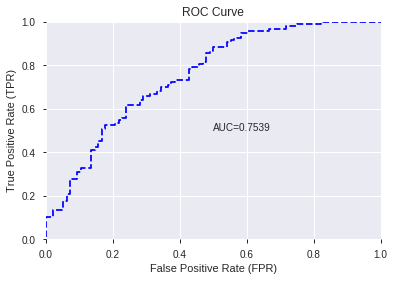

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


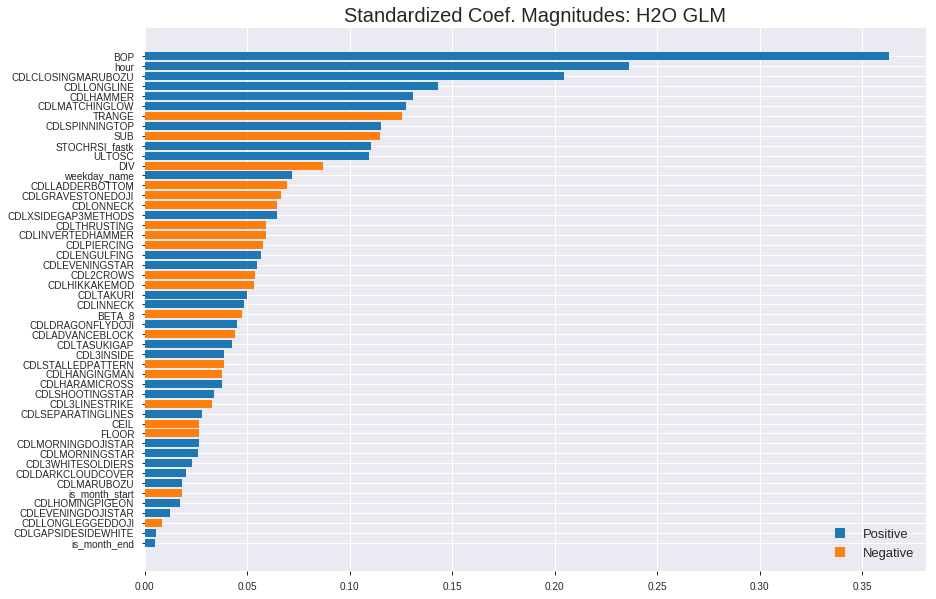

'log_likelihood'
--2019-08-25 15:03:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.160.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.160.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_150322_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_150322_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_982d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'hour',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLHAMMER',
 'CDLMATCHINGLOW',
 'TRANGE',
 'CDLSPINNINGTOP',
 'SUB',
 'STOCHRSI_fastk',
 'ULTOSC',
 'DIV',
 'weekday_name',
 'CDLLADDERBOTTOM',
 'CDLGRAVESTONEDOJI',
 'CDLONNECK',
 'CDLXSIDEGAP3METHODS',
 'CDLTHRUSTING',
 'CDLINVERTEDHAMMER',
 'CDLPIERCING',
 'CDLENGULFING',
 'CDLEVENINGSTAR',
 'CDL2CROWS',
 'CDLHIKKAKEMOD',
 'CDLTAKURI',
 'CDLINNECK',
 'BETA_8',
 'CDLDRAGONFLYDOJI',
 'CDLADVANCEBLOCK',
 'CDLTASUKIGAP',
 'CDL3INSIDE',
 'CDLSTALLEDPATTERN',
 'CDLHANGINGMAN',
 'CDLHARAMICROSS',
 'CDLSHOOTINGSTAR',
 'CDL3LINESTRIKE',
 'CDLSEPARATINGLINES',
 'CEIL',
 'FLOOR',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDL3WHITESOLDIERS',
 'CDLDARKCLOUDCOVER',
 'CDLMARUBOZU',
 'is_month_start',
 'CDLHOMINGPIGEON',
 'CDLEVENINGDOJISTAR',
 'CDLLONGLEGGEDDOJI',
 'CDLGAPSIDESIDEWHITE',
 'is_month_end']

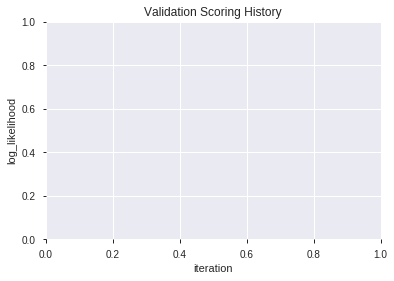

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_150340_model_7  0.775451  0.574787              0.275021  0.440954  0.194440
1               XGBoost_3_AutoML_20190825_150340  0.770619  0.576224              0.301332  0.442255  0.195590
2  XGBoost_grid_1_AutoML_20190825_150340_model_1  0.768256  0.577363              0.306808  0.443204  0.196430
3               XGBoost_1_AutoML_20190825_150340  0.767612  0.577652              0.296070  0.443626  0.196804
4  XGBoost_grid_1_AutoML_20190825_150340_model_3  0.763209  0.577366              0.327695  0.444155  0.197274
5  XGBoost_grid_1_AutoML_20190825_150340_model_5  0.762350  0.587471              0.311802  0.445924  0.198848
6  XGBoost_grid_1_AutoML_20190825_150340_model_6  0.760095  0.585420              0.333011  0.446984  0.199794
7  XGBoost_grid_1_AutoML_20190825_150340_model_2  0.752577  0.592426              0.311909  0.449909  0.202418
8               XGBoost_2_AutoML_20190825_150340  0.750430  0.595875              0.311856  0.451728  0.204058
9  XGBoost_grid_1_AutoML_20190825_150340_model_4  0.745168  0.596670              0.296177  0.452043  0.204343

variable  relative_importance  scaled_importance  percentage
0                  BOP          1455.728638           1.000000    0.228297
1       STOCHRSI_fastk           711.958313           0.489074    0.111654
2                  DIV           664.037903           0.456155    0.104139
3               TRANGE           652.548157           0.448262    0.102337
4               ULTOSC           605.764404           0.416125    0.095000
5               BETA_8           603.515869           0.414580    0.094648
6                 hour           503.581238           0.345931    0.078975
7                  SUB           459.347900           0.315545    0.072038
8         weekday_name           262.482269           0.180310    0.041164
9   CDLCLOSINGMARUBOZU           191.885849           0.131814    0.030093
10           CDLHAMMER            92.903625           0.063819    0.014570
11         CDLLONGLINE            43.411263           0.029821    0.006808
12      CDLSPINNINGTOP            40.370438           0.027732    0.006331
13   CDLLONGLEGGEDDOJI            37.080357           0.025472    0.005815
14                CEIL            20.754309           0.014257    0.003255
15   CDLGRAVESTONEDOJI            16.581991           0.011391    0.002601
16      CDLMATCHINGLOW             8.962259           0.006157    0.001406
17               FLOOR             5.542840           0.003808    0.000869

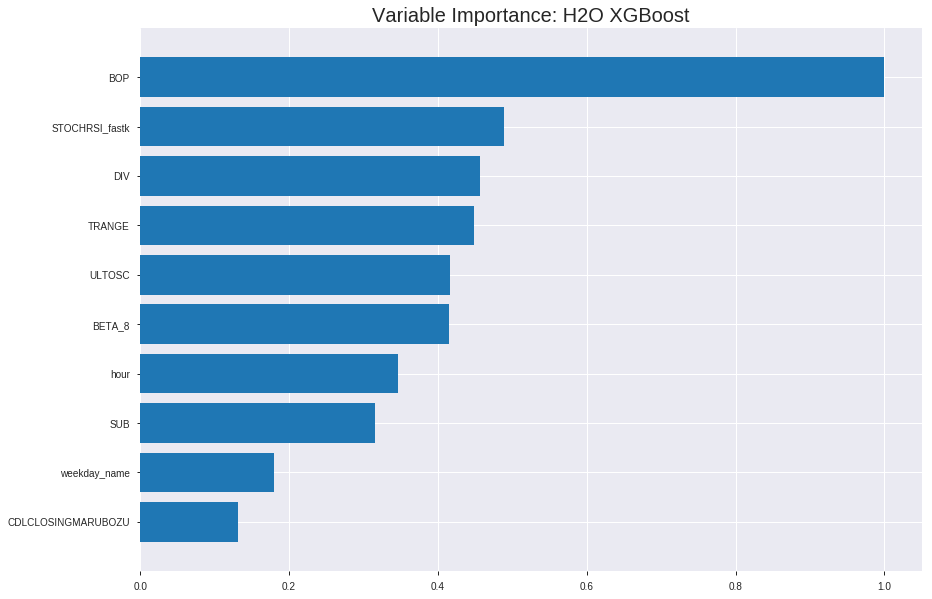

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_150340_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13527909297727264
RMSE: 0.3678030627622242
LogLoss: 0.43335518497732023
Mean Per-Class Error: 0.16384167647104442
AUC: 0.9107679763542781
pr_auc: 0.8964965409872842
Gini: 0.8215359527085562
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4790356382727623: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      581  132  0.1851   (132.0/713.0)
1      91   542  0.1438   (91.0/633.0)
Total  672  674  0.1657   (223.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479036     0.82938   203
max f2                       0.282966     0.879168  291
max f0point5                 0.609611     0.852387  139
max accuracy                 0.489587     0.83581   198
max precision                0.92343      1         0
max recall                   0.118007     1         363
max specificity              0.92343      1         0
max absolute_mcc             0.489587     0.671396  198
max min_per_class_accuracy   0.496397     0.834502  196
max mean_per_class_accuracy  0.489587     0.836158  198

Gains/Lift Table: Avg response rate: 47.03 %, avg score: 46.87 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.88846            2.12638    2.12638            1                0.902036   1                           0.902036            0.0221169       0.0221169                  112.638   112.638
    2        0.0200594                   0.874815           1.96281    2.04763            0.923077         0.881706   0.962963                    0.892247            0.0189573       0.0410742                  96.2814   104.763
    3        0.0304606                   0.861879           2.12638    2.07452            1                0.868946   0.97561                     0.884291            0.0221169       0.0631912                  112.638   107.452
    4        0.0401189                   0.854524           2.12638    2.087              1                0.858708   0.981481                    0.878132            0.0205371       0.0837283                  112.638   108.7
    5        0.0505201                   0.845767           2.12638    2.09511            1                0.850317   0.985294                    0.872405            0.0221169       0.105845                   112.638   109.511
    6        0.100297                    0.796251           1.99943    2.04763            0.940299         0.820203   0.962963                    0.846497            0.0995261       0.205371                   99.9434   104.763
    7        0.150074                    0.751689           1.99943    2.03164            0.940299         0.774158   0.955446                    0.822504            0.0995261       0.304897                   99.9434   103.164
    8        0.200594                    0.721836           2.0013     2.024              0.941176         0.737852   0.951852                    0.801184            0.101106        0.406003                   100.13    102.4
    9        0.300149                    0.643471           1.87249    1.97375            0.880597         0.683182   0.928218                    0.762045            0.186414        0.592417                   87.2486   97.3746
    10       0.400446                    0.566047           1.46484    1.84628            0.688889         0.60534    0.868275                    0.722796            0.146919        0.739336                   46.4841   84.6284
    11       0.5                         0.478711           1.1584     1.70932            0.544776         0.521441   0.803863                    0.682704            0.115324        0.85466                    15.8402   70.9321
    12       0.600297                    0.39387            0.582786   1.5211             0.274074         0.438055   0.715347                    0.641828            0.0584518       0.913112                   -41.7214  52.11
    13       0.699851                    0.305171           0.476056   1.37244            0.223881         0.347436   0.645435                    0.599951            0.0473934       0.960506                   -52.3944  37.2442
    14       0.800149                    0.191729           0.31502    1.2399             0.148148         0.250935   0.583101                    0.556202            0.0315956       0.992101                   -68.498   23.9896
    15       0.899703                    0.116685           0.0793426  1.11148            0.0373134        0.149483   0.522709                    0.511198            0.00789889      1                          -92.0657  11.1478
    16       1                           0.0435974          0          1                  0                0.0876494  0.470282       



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20165088388261868
RMSE: 0.4490555465447662
LogLoss: 0.5865849579380694
Mean Per-Class Error: 0.30246458691558176
AUC: 0.7530773219793117
pr_auc: 0.6981017156628277
Gini: 0.5061546439586233
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3371801972389221: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      107  100  0.4831   (100.0/207.0)
1      27   150  0.1525   (27.0/177.0)
Total  134  250  0.3307   (127.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.33718      0.702576  249
max f2                       0.138111     0.83652   337
max f0point5                 0.586018     0.699001  130
max accuracy                 0.586018     0.708333  130
max precision                0.898138     1         0
max recall                   0.0939622    1         369
max specificity              0.898138     1         0
max absolute_mcc             0.586018     0.414524  130
max min_per_class_accuracy   0.49353      0.671498  186
max mean_per_class_accuracy  0.583447     0.697535  132

Gains/Lift Table: Avg response rate: 46.09 %, avg score: 46.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.874939           1.62712   1.62712            0.75             0.89251    0.75                        0.89251             0.0169492       0.0169492                  62.7119   62.7119
    2        0.0208333                   0.85208            2.16949   1.89831            1                0.869092   0.875                       0.880801            0.0225989       0.039548                   116.949   89.8305
    3        0.03125                     0.842975           2.16949   1.9887             1                0.846953   0.916667                    0.869519            0.0225989       0.0621469                  116.949   98.8701
    4        0.0416667                   0.834529           2.16949   2.0339             1                0.838312   0.9375                      0.861717            0.0225989       0.0847458                  116.949   103.39
    5        0.0520833                   0.819618           1.08475   1.84407            0.5              0.825896   0.85                        0.854553            0.0112994       0.0960452                  8.47458   84.4068
    6        0.101562                    0.767419           1.59857   1.72447            0.736842         0.790638   0.794872                    0.823415            0.079096        0.175141                   59.8573   72.4468
    7        0.151042                    0.740597           1.71276   1.72063            0.789474         0.755121   0.793103                    0.801043            0.0847458       0.259887                   71.2756   72.0631
    8        0.200521                    0.683237           1.14184   1.57781            0.526316         0.716323   0.727273                    0.780138            0.0564972       0.316384                   14.1838   57.7812
    9        0.299479                    0.613754           1.59857   1.58467            0.736842         0.649086   0.730435                    0.736834            0.158192        0.474576                   59.8573   58.4672
    10       0.401042                    0.544219           1.16819   1.4792             0.538462         0.581181   0.681818                    0.697415            0.118644        0.59322                    16.8188   47.9199
    11       0.5                         0.477418           1.02765   1.38983            0.473684         0.51312    0.640625                    0.66094             0.101695        0.694915                   2.76539   38.9831
    12       0.598958                    0.396033           0.91347   1.31113            0.421053         0.439152   0.604348                    0.624297            0.0903955       0.785311                   -8.65299  31.1127
    13       0.700521                    0.298667           0.945676  1.25814            0.435897         0.34154    0.579926                    0.583302            0.0960452       0.881356                   -5.43242  25.8144
    14       0.799479                    0.214615           0.513827  1.16601            0.236842         0.252517   0.537459                    0.542358            0.0508475       0.932203                   -48.6173  16.6013
    15       0.898438                    0.133153           0.570919  1.10047            0.263158         0.169567   0.507246                    0.501297            0.0564972       0.988701                   -42.9081  10.0467
    16       1                           0.0525474          0.111256  1                  0.0512821        0.0974971  0.460938                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:03:56  9.923 sec   0                  0.5              0.693147            0.5             0                  1                0.529718                         0.5                0.693147              0.5               0                    1                  0.539062
    2019-08-25 15:03:56  10.037 sec  5                  0.470743         0.635934            0.830184        0.804895           2.12638          0.268945                         0.481666           0.656884              0.723833          0.683647             2.16949            0.395833
    2019-08-25 15:03:56  10.122 sec  10                 0.450731         0.597477            0.845725        0.817918           2.12638          0.263744                         0.469768           0.633198              0.737738          0.691198             2.16949            0.354167
    2019-08-25 15:03:56  10.221 sec  15                 0.433445         0.564078            0.856478        0.832022           1.9745           0.240713                         0.463264           0.619635              0.735309          0.67889              2.16949            0.377604
    2019-08-25 15:03:56  10.317 sec  20                 0.420688         0.538873            0.863515        0.842941           2.12638          0.224368                         0.457459           0.607121              0.742105          0.68757              2.16949            0.395833
    2019-08-25 15:03:56  10.403 sec  25                 0.410823         0.519065            0.870795        0.851751           2.12638          0.224368                         0.457237           0.605832              0.735637          0.675153             2.16949            0.34375
    2019-08-25 15:03:56  10.487 sec  30                 0.403061         0.503381            0.877948        0.858718           2.12638          0.201337                         0.454011           0.598411              0.742269          0.682063             2.16949            0.335938
    2019-08-25 15:03:56  10.576 sec  35                 0.394987         0.48709             0.887           0.87127            2.12638          0.191679                         0.452652           0.594683              0.743088          0.684468             2.16949            0.328125
    2019-08-25 15:03:56  10.662 sec  40                 0.388077         0.473083            0.891846        0.877016           2.12638          0.187221                         0.450707           0.590398              0.747892          0.691291             1.62712            0.346354
    2019-08-25 15:03:57  10.747 sec  45                 0.382558         0.46197             0.896934        0.882207           2.12638          0.18425                          0.451181           0.591118              0.74549           0.688519             1.62712            0.346354
    2019-08-25 15:03:57  10.846 sec  50                 0.377447         0.451766            0.90165         0.886979           2.12638          0.178306                         0.451045           0.590856              0.746336          0.689133             1.62712            0.351562
    2019-08-25 15:03:57  10.935 sec  55                 0.372276         0.441782            0.906512        0.891988           2.12638          0.167905                         0.450592           0.589868              0.748601          0.

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
BOP                 1455.73                1                    0.228297
STOCHRSI_fastk      711.958                0.489074             0.111654
DIV                 664.038                0.456155             0.104139
TRANGE              652.548                0.448262             0.102337
ULTOSC              605.764                0.416125             0.0950001
BETA_8              603.516                0.41458              0.0946475
hour                503.581                0.345931             0.0789751
SUB                 459.348                0.315545             0.0720381
weekday_name        262.482                0.18031              0.0411643
CDLCLOSINGMARUBOZU  191.886                0.131814             0.0300929
CDLHAMMER           92.9036                0.0638193            0.0145698
CDLLONGLINE         43.4113                0.029821             0.00680805
CDLSPINNINGTOP      40.3704                0.0277321            0.00633117
CDLLONGLEGGEDDOJI   37.0804                0.025472             0.0058152
CEIL                20.7543                0.014257             0.00325483
CDLGRAVESTONEDOJI   16.582                 0.0113909            0.0026005
CDLMATCHINGLOW      8.96226                0.00615655           0.00140552
FLOOR               5.54284                0.00380761           0.000869266

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7253886010362695)

('F1', 0.7464114832535885)

('auc', 0.775451030927835)

('logloss', 0.5747867506579799)

('mean_per_class_error', 0.27502147766323026)

('rmse', 0.44095407731470987)

('mse', 0.1944404983004671)

xgboost prediction progress: |████████████████████████████████████████████| 100%


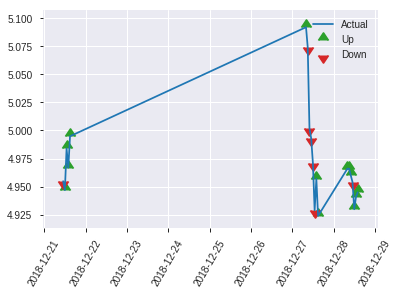


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1944404983004671
RMSE: 0.44095407731470987
LogLoss: 0.5747867506579799
Mean Per-Class Error: 0.27502147766323026
AUC: 0.775451030927835
pr_auc: 0.7747718581647525
Gini: 0.5509020618556699
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41713812947273254: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   34   0.3542   (34.0/96.0)
1      19   78   0.1959   (19.0/97.0)
Total  81   112  0.2746   (53.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.417138     0.746411  111
max f2                       0.179776     0.84392   162
max f0point5                 0.629193     0.723077  56
max accuracy                 0.417138     0.725389  111
max precision                0.910604     1         0
max recall                   0.0497705    1         190
max specificity              0.910604     1         0
max absolute_mcc             0.417138     0.45587   111
max min_per_class_accuracy   0.478376     0.701031  93
max mean_per_class_accuracy  0.417138     0.724979  111

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 46.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.898882           1.98969   1.98969            1                0.910362   1                           0.910362            0.0206186       0.0206186                  98.9691   98.9691
    2        0.0207254                   0.88777            1.98969   1.98969            1                0.894163   1                           0.902263            0.0206186       0.0412371                  98.9691   98.9691
    3        0.0310881                   0.837337           1.98969   1.98969            1                0.865555   1                           0.890027            0.0206186       0.0618557                  98.9691   98.9691
    4        0.0414508                   0.818793           1.98969   1.98969            1                0.831067   1                           0.875287            0.0206186       0.0824742                  98.9691   98.9691
    5        0.0518135                   0.808979           1.98969   1.98969            1                0.81357    1                           0.862943            0.0206186       0.103093                   98.9691   98.9691
    6        0.103627                    0.763347           1.59175   1.79072            0.8              0.784767   0.9                         0.823855            0.0824742       0.185567                   59.1753   79.0722
    7        0.150259                    0.722433           1.76861   1.78386            0.888889         0.741034   0.896552                    0.798152            0.0824742       0.268041                   76.8614   78.3861
    8        0.202073                    0.677214           1.19381   1.63257            0.6              0.701848   0.820513                    0.773459            0.0618557       0.329897                   19.3814   63.2567
    9        0.300518                    0.627658           1.57081   1.61234            0.789474         0.648037   0.810345                    0.732372            0.154639        0.484536                   57.0808   61.2336
    10       0.398964                    0.557632           0.942485  1.44705            0.473684         0.596584   0.727273                    0.698866            0.0927835       0.57732                    -5.75149  44.7048
    11       0.502591                    0.468142           1.19381   1.39483            0.6              0.512973   0.701031                    0.660537            0.123711        0.701031                   19.3814   39.4835
    12       0.601036                    0.380325           1.04721   1.3379             0.526316         0.432254   0.672414                    0.623146            0.103093        0.804124                   4.72056   33.7895
    13       0.699482                    0.30008            0.523603  1.22329            0.263158         0.342224   0.614815                    0.583609            0.0515464       0.85567                    -47.6397  22.3291
    14       0.797927                    0.227917           0.837765  1.17573            0.421053         0.266493   0.590909                    0.544484            0.0824742       0.938144                   -16.2235  17.5726
    15       0.896373                    0.124949           0.209441  1.0696             0.105263         0.177352   0.537572                    0.504164            0.0206186       0.958763                   -79.0559  6.96025
    16       1                           0.0450623          0.397938  1                  0.2              0.0929752  0.502591                   

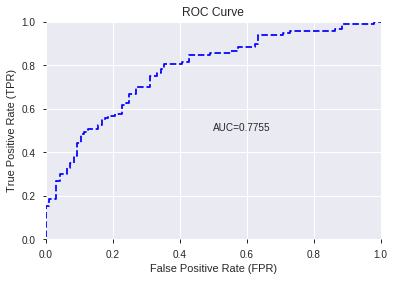

This function is available for GLM models only


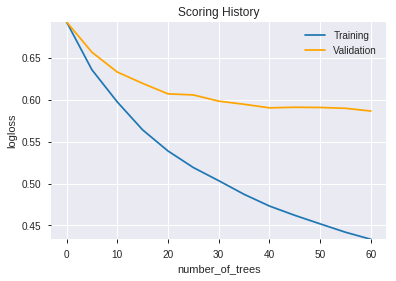

--2019-08-25 15:04:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.105.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.105.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_150340_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_150340_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_982d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHRSI_fastk',
 'DIV',
 'TRANGE',
 'ULTOSC',
 'BETA_8',
 'hour',
 'SUB',
 'weekday_name',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'CDLLONGLINE',
 'CDLSPINNINGTOP',
 'CDLLONGLEGGEDDOJI',
 'CEIL',
 'CDLGRAVESTONEDOJI',
 'CDLMATCHINGLOW',
 'FLOOR']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_150412_model_1  0.754618  0.649744               0.28619  0.481895  0.232222

variable  relative_importance  scaled_importance  percentage
0                         BOP             0.152559           1.000000    0.029582
1                        hour             0.115297           0.755752    0.022356
2          CDLCLOSINGMARUBOZU             0.103859           0.680776    0.020138
3                 CDLLONGLINE             0.094717           0.620854    0.018366
4                      TRANGE             0.079990           0.524318    0.015510
...                       ...                  ...                ...         ...
1033  BBANDS_upperband_14_2_2             0.000022           0.000146    0.000004
1034  BBANDS_middleband_8_5_3             0.000022           0.000145    0.000004
1035  BBANDS_upperband_20_1_4             0.000021           0.000135    0.000004
1036  BBANDS_middleband_8_5_2             0.000018           0.000121    0.000004
1037  BBANDS_upperband_20_3_5             0.000010           0.000064    0.000002

[1038 rows x 4 columns]

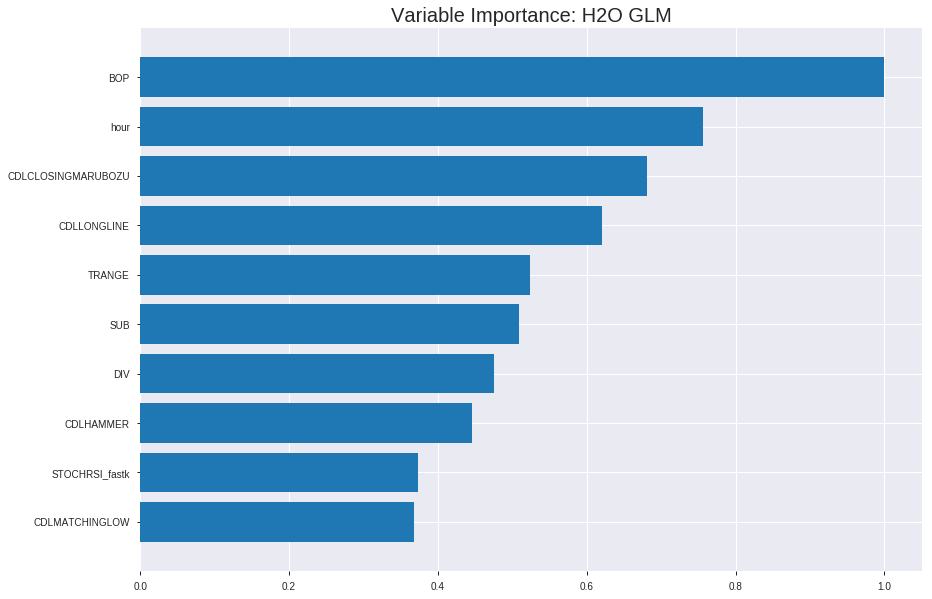

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_150412_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19337315839178332
RMSE: 0.43974214989216504
LogLoss: 0.5724413522875624
Null degrees of freedom: 1345
Residual degrees of freedom: 307
Null deviance: 1861.1945775256659
Residual deviance: 1541.0121203581182
AIC: 3619.0121203581184
AUC: 0.7988828548575428
pr_auc: 0.7643752283037817
Gini: 0.5977657097150857
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39361060676460213: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      356  357  0.5007   (357.0/713.0)
1      65   568  0.1027   (65.0/633.0)
Total  421  925  0.3135   (422.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393611     0.72914   250
max f2                       0.340167     0.836826  282
max f0point5                 0.539931     0.718178  144
max accuracy                 0.494877     0.72734   178
max precision                0.839711     1         0
max recall                   0.112261     1         392
max specificity              0.839711     1         0
max absolute_mcc             0.494877     0.453002  178
max min_per_class_accuracy   0.488108     0.723703  183
max mean_per_class_accuracy  0.48068      0.726699  187

Gains/Lift Table: Avg response rate: 47.03 %, avg score: 47.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.797228           1.82261   1.82261            0.857143         0.814552  0.857143                    0.814552            0.0189573       0.0189573                  82.2613   82.2613
    2        0.0200594                   0.770829           1.79925   1.81136            0.846154         0.784301  0.851852                    0.799986            0.0173776       0.0363349                  79.9247   81.1363
    3        0.0304606                   0.74197            1.9745    1.86707            0.928571         0.753475  0.878049                    0.784104            0.0205371       0.056872                   97.4498   86.7067
    4        0.0401189                   0.731019           2.12638   1.9295             1                0.737542  0.907407                    0.772895            0.0205371       0.0774092                  112.638   92.9495
    5        0.0505201                   0.717208           1.82261   1.90749            0.857143         0.724034  0.897059                    0.762835            0.0189573       0.0963665                  82.2613   90.749
    6        0.100297                    0.675087           1.80901   1.85862            0.850746         0.694533  0.874074                    0.728937            0.0900474       0.186414                   80.9012   85.8616
    7        0.150074                    0.64248            1.80901   1.84216            0.850746         0.658297  0.866337                    0.705507            0.0900474       0.276461                   80.9012   84.2163
    8        0.200594                    0.615716           1.65733   1.79561            0.779412         0.627022  0.844444                    0.68574             0.0837283       0.36019                    65.7327   79.5612
    9        0.300149                    0.563821           1.4123    1.66847            0.664179         0.590626  0.784653                    0.654193            0.1406          0.50079                    41.2299   66.8473
    10       0.400446                    0.522933           1.19707   1.5504             0.562963         0.543611  0.729128                    0.626496            0.120063        0.620853                   19.7074   55.0405
    11       0.5                         0.480295           1.20601   1.48183            0.567164         0.50287   0.69688                     0.601881            0.120063        0.740916                   20.6008   48.1833
    12       0.600297                    0.43404            0.834802  1.37373            0.392593         0.45772   0.64604                     0.577795            0.0837283       0.824645                   -16.5198  37.3727
    13       0.699851                    0.384251           0.777558  1.28892            0.365672         0.410754  0.606157                    0.554033            0.0774092       0.902054                   -22.2442  28.8922
    14       0.800149                    0.325396           0.48828   1.18856            0.22963          0.356267  0.55896                     0.529243            0.0489731       0.951027                   -51.172   18.8563
    15       0.899703                    0.247349           0.31737   1.09216            0.149254         0.285819  0.513625                    0.502308            0.0315956       0.982622                   -68.263   9.21633
    16       1                           0.0557079          0.173261  1                  0.0814815        0.183001  0.470282                    0.470282          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2031877979206944
RMSE: 0.4507635720870692
LogLoss: 0.5948514925971338
Null degrees of freedom: 383
Residual degrees of freedom: -655
Null deviance: 530.1256103466318
Residual deviance: 456.84594631459873
AIC: 2534.8459463145987
AUC: 0.7614563716258631
pr_auc: 0.694712757520226
Gini: 0.5229127432517262
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35957994398875015: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      91   116  0.5604   (116.0/207.0)
1      15   162  0.0847   (15.0/177.0)
Total  106  278  0.3411   (131.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35958      0.712088  277
max f2                       0.348369     0.82495   285
max f0point5                 0.538647     0.695839  129
max accuracy                 0.457104     0.708333  196
max precision                0.882465     1         0
max recall                   0.102242     1         377
max specificity              0.882465     1         0
max absolute_mcc             0.457104     0.420127  196
max min_per_class_accuracy   0.469193     0.700565  184
max mean_per_class_accuracy  0.457104     0.710636  196

Gains/Lift Table: Avg response rate: 46.09 %, avg score: 45.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.82433            1.62712   1.62712            0.75             0.869677  0.75                        0.869677            0.0169492       0.0169492                  62.7119   62.7119
    2        0.0208333                   0.776331           1.62712   1.62712            0.75             0.796514  0.75                        0.833095            0.0169492       0.0338983                  62.7119   62.7119
    3        0.03125                     0.76189            1.62712   1.62712            0.75             0.770527  0.75                        0.812239            0.0169492       0.0508475                  62.7119   62.7119
    4        0.0416667                   0.740724           2.16949   1.76271            1                0.752908  0.8125                      0.797406            0.0225989       0.0734463                  116.949   76.2712
    5        0.0520833                   0.725867           1.62712   1.73559            0.75             0.733048  0.8                         0.784535            0.0169492       0.0903955                  62.7119   73.5593
    6        0.101562                    0.674068           1.59857   1.66884            0.736842         0.701671  0.769231                    0.744165            0.079096        0.169492                   59.8573   66.884
    7        0.151042                    0.639927           1.71276   1.68323            0.789474         0.654453  0.775862                    0.714777            0.0847458       0.254237                   71.2756   68.3226
    8        0.200521                    0.600694           1.48439   1.63416            0.684211         0.618587  0.753247                    0.691042            0.0734463       0.327684                   48.4389   63.4162
    9        0.299479                    0.558225           1.48439   1.58467            0.684211         0.580338  0.730435                    0.654462            0.146893        0.474576                   48.4389   58.4672
    10       0.401042                    0.503803           1.27944   1.50737            0.589744         0.530487  0.694805                    0.623065            0.129944        0.60452                    27.9444   50.7374
    11       0.5                         0.461578           1.19893   1.44633            0.552632         0.479242  0.666667                    0.5946              0.118644        0.723164                   19.893    44.6328
    12       0.598958                    0.418576           0.799286  1.33943            0.368421         0.439935  0.617391                    0.569047            0.079096        0.80226                    -20.0714  33.9425
    13       0.700521                    0.372051           0.890048  1.27427            0.410256         0.397294  0.587361                    0.544146            0.0903955       0.892655                   -10.9952  27.4274
    14       0.799479                    0.310038           0.456735  1.17308            0.210526         0.340594  0.540717                    0.518951            0.0451977       0.937853                   -54.3265  17.308
    15       0.898438                    0.221908           0.228368  1.06902            0.105263         0.267119  0.492754                    0.491213            0.0225989       0.960452                   -77.1632  6.90248
    16       1                           0.0496975          0.389396  1                  0.179487         0.159682  0.460938                    0.457542           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 15:04:16  0.000 sec   2            18        1036          1.35357           1.34508
    2019-08-25 15:04:17  1.795 sec   4            13        1039          1.34558           1.33768
    2019-08-25 15:04:19  3.549 sec   6            9.7       1039          1.33567           1.32837
    2019-08-25 15:04:21  5.857 sec   8            7.1       1039          1.32369           1.31714
    2019-08-25 15:04:24  8.982 sec   10           5.1       1039          1.30952           1.30391
    2019-08-25 15:04:26  10.764 sec  12           3.7       1039          1.29316           1.28899
    2019-08-25 15:04:28  12.536 sec  14           2.7       1039          1.27472           1.27256
    2019-08-25 15:04:30  14.472 sec  16           2         1039          1.25452           1.25527
    2019-08-25 15:04:32  16.346 sec  18           1.4       1039          1.23303           1.23774
    2019-08-25 15:04:34  18.080 sec  20           1.1       1039          1.21076           1.22112
    2019-08-25 15:04:35  19.858 sec  22           0.77      1039          1.18832           1.20661
    2019-08-25 15:04:37  21.645 sec  24           0.56      1039          1.16621           1.19563
    2019-08-25 15:04:39  23.527 sec  26           0.41      1039          1.14488           1.1897
    2019-08-25 15:04:41  25.273 sec  28           0.3       1039          1.12465           1.19038
    2019-08-25 15:04:43  27.030 sec  30           0.21      1039          1.10572           1.19803
    2019-08-25 15:04:44  28.769 sec  32           0.16      1039          1.08819           1.21323
    2019-08-25 15:04:46  30.587 sec  34           0.11      1039          1.07212           1.23601
    2019-08-25 15:04:48  32.333 sec  36           0.083     1039          1.0575            1.26657

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7150259067357513)

('F1', 0.7698744769874477)

('auc', 0.7546176975945017)

('logloss', 0.6497438432539162)

('mean_per_class_error', 0.2860824742268041)

('rmse', 0.48189452917815184)

('mse', 0.2322223372518326)

glm prediction progress: |████████████████████████████████████████████████| 100%


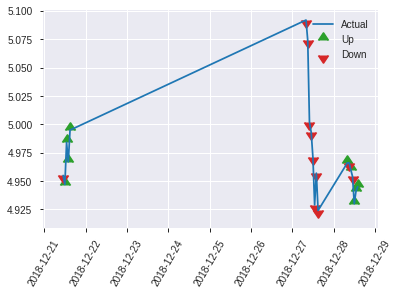


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2322223372518326
RMSE: 0.48189452917815184
LogLoss: 0.6497438432539162
Null degrees of freedom: 192
Residual degrees of freedom: -846
Null deviance: 268.35681432348866
Residual deviance: 250.80112349601166
AIC: 2328.8011234960118
AUC: 0.7546176975945017
pr_auc: 0.7167350026159801
Gini: 0.5092353951890034
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24834188796632486: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      46   50   0.5208   (50.0/96.0)
1      5    92   0.0515   (5.0/97.0)
Total  51   142  0.285    (55.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.248342     0.769874  141
max f2                       0.248342     0.867925  141
max f0point5                 0.36961      0.695444  79
max accuracy                 0.255443     0.715026  137
max precision                0.741441     1         0
max recall                   0.148008     1         176
max specificity              0.741441     1         0
max absolute_mcc             0.248342     0.484898  141
max min_per_class_accuracy   0.350909     0.680412  94
max mean_per_class_accuracy  0.255443     0.713918  137

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 34.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.688909           1.98969   1.98969            1                0.720155  1                           0.720155            0.0206186       0.0206186                  98.9691    98.9691
    2        0.0207254                   0.644946           1.98969   1.98969            1                0.683949  1                           0.702052            0.0206186       0.0412371                  98.9691    98.9691
    3        0.0310881                   0.623307           1.98969   1.98969            1                0.634992  1                           0.679698            0.0206186       0.0618557                  98.9691    98.9691
    4        0.0414508                   0.611008           1.98969   1.98969            1                0.616163  1                           0.663814            0.0206186       0.0824742                  98.9691    98.9691
    5        0.0518135                   0.57073            0.994845  1.79072            0.5              0.594578  0.9                         0.649967            0.0103093       0.0927835                  -0.515464  79.0722
    6        0.103627                    0.529586           0.994845  1.39278            0.5              0.546788  0.7                         0.598378            0.0515464       0.14433                    -0.515464  39.2784
    7        0.150259                    0.499558           1.76861   1.50942            0.888889         0.515002  0.758621                    0.572503            0.0824742       0.226804                   76.8614    50.9421
    8        0.202073                    0.477951           1.39278   1.47951            0.7              0.487057  0.74359                     0.550594            0.0721649       0.298969                   39.2784    47.9514
    9        0.300518                    0.404056           1.36137   1.44081            0.684211         0.443792  0.724138                    0.515607            0.134021        0.43299                    36.1367    44.0811
    10       0.398964                    0.377993           1.36137   1.42121            0.684211         0.38999   0.714286                    0.48461             0.134021        0.56701                    36.1367    42.1208
    11       0.502591                    0.34516            1.09433   1.35381            0.55             0.361785  0.680412                    0.459286            0.113402        0.680412                   9.43299    35.381
    12       0.601036                    0.309161           0.942485  1.28644            0.473684         0.32692   0.646552                    0.437605            0.0927835       0.773196                   -5.75149   28.6438
    13       0.699482                    0.256972           1.36137   1.29698            0.684211         0.282614  0.651852                    0.415791            0.134021        0.907216                   36.1367    29.6984
    14       0.797927                    0.215633           0.418882  1.18865            0.210526         0.237269  0.597403                    0.393766            0.0412371       0.948454                   -58.1118   18.8646
    15       0.896373                    0.163993           0.314162  1.0926             0.157895         0.19313   0.549133                    0.371731            0.0309278       0.979381                   -68.5838   9.26047
    16       1                           0.0384807          0.198969  1                  0.1              0.116377  0.502591                    0

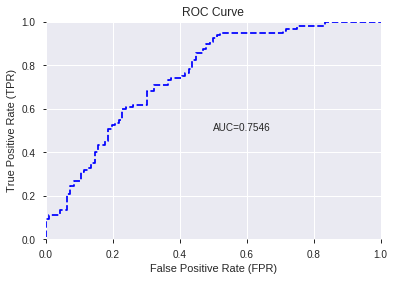

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


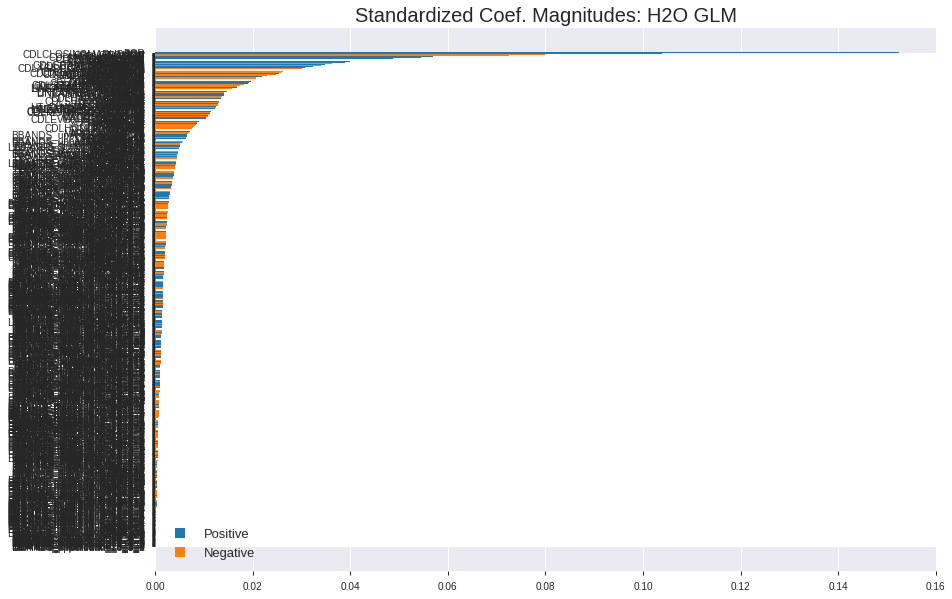

'log_likelihood'
--2019-08-25 15:05:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_150412_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_150412_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_982d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

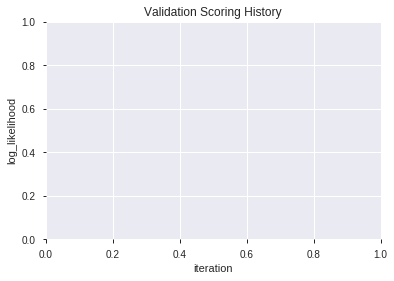

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190825_150527  0.788982  0.592287              0.285975  0.450913  0.203322
1               XGBoost_1_AutoML_20190825_150527  0.783290  0.585653              0.259396  0.448985  0.201588
2  XGBoost_grid_1_AutoML_20190825_150527_model_3  0.781035  0.592869              0.285707  0.451849  0.204168
3  XGBoost_grid_1_AutoML_20190825_150527_model_1  0.772659  0.583690              0.264820  0.446993  0.199803
4  XGBoost_grid_1_AutoML_20190825_150527_model_6  0.771692  0.619609              0.275344  0.466146  0.217292
5  XGBoost_grid_1_AutoML_20190825_150527_model_7  0.763101  0.597019              0.338273  0.453933  0.206055
6               XGBoost_2_AutoML_20190825_150527  0.757195  0.614461              0.290861  0.461579  0.213055
7  XGBoost_grid_1_AutoML_20190825_150527_model_2  0.756229  0.607836              0.317064  0.457885  0.209659
8  XGBoost_grid_1_AutoML_20190825_150527_model_5  0.750966  0.643061              0.317279  0.477158  0.227680
9  XGBoost_grid_1_AutoML_20190825_150527_model_4  0.744201  0.611546              0.306433  0.460156  0.211743

variable  relative_importance  scaled_importance  percentage
0                       BOP          1557.269409           1.000000    0.184484
1                    TRANGE           451.345520           0.289831    0.053469
2                       DIV           420.736145           0.270176    0.049843
3                      hour           359.701080           0.230982    0.042613
4              STOCHF_fastk           246.560333           0.158329    0.029209
..                      ...                  ...                ...         ...
339                WILLR_30             0.561881           0.000361    0.000067
340             AROONOSC_12             0.555140           0.000356    0.000066
341  BBANDS_upperband_8_4_3             0.491883           0.000316    0.000058
342  BBANDS_lowerband_8_2_5             0.362197           0.000233    0.000043
343              PLUS_DI_30             0.172260           0.000111    0.000020

[344 rows x 4 columns]

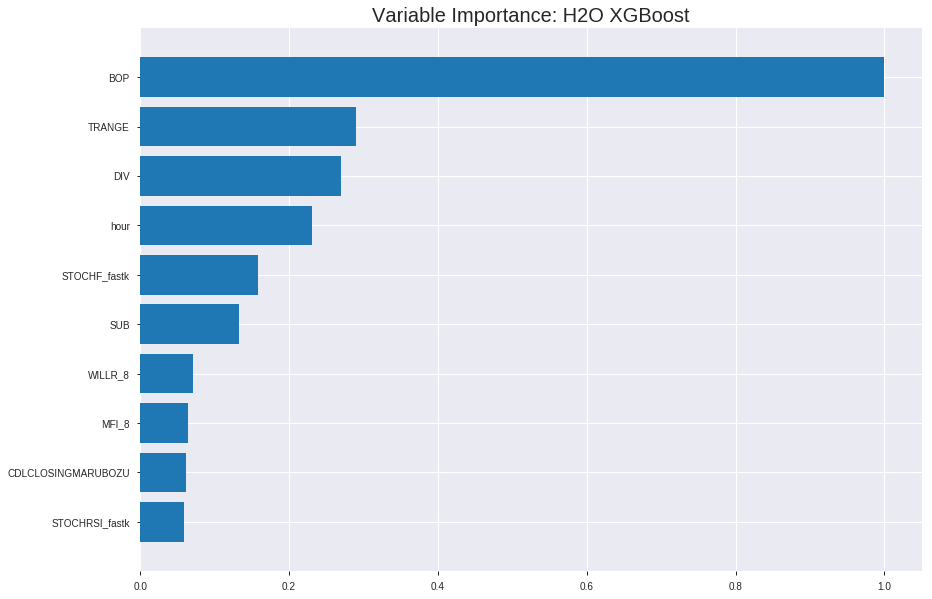

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190825_150527


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.10584584686280392
RMSE: 0.32533958698996945
LogLoss: 0.36898749963693994
Mean Per-Class Error: 0.0969979770854521
AUC: 0.9643563786062939
pr_auc: 0.9613545011722138
Gini: 0.9287127572125877
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4875096082687378: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      631  82   0.115    (82.0/713.0)
1      50   583  0.079    (50.0/633.0)
Total  681  665  0.0981   (132.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48751      0.898305  200
max f2                       0.437255     0.920567  219
max f0point5                 0.633673     0.912652  139
max accuracy                 0.49036      0.901932  199
max precision                0.924683     1         0
max recall                   0.15867      1         346
max specificity              0.924683     1         0
max absolute_mcc             0.48751      0.804636  200
max min_per_class_accuracy   0.509227     0.897314  191
max mean_per_class_accuracy  0.48751      0.903002  200

Gains/Lift Table: Avg response rate: 47.03 %, avg score: 46.99 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.892236           2.12638    2.12638            1                0.902534   1                           0.902534            0.0221169       0.0221169                  112.638   112.638
    2        0.0200594                   0.871007           2.12638    2.12638            1                0.880769   1                           0.892055            0.0205371       0.042654                   112.638   112.638
    3        0.0304606                   0.859608           2.12638    2.12638            1                0.867612   1                           0.883708            0.0221169       0.0647709                  112.638   112.638
    4        0.0401189                   0.845748           2.12638    2.12638            1                0.851987   1                           0.876072            0.0205371       0.0853081                  112.638   112.638
    5        0.0505201                   0.836395           2.12638    2.12638            1                0.841554   1                           0.868965            0.0221169       0.107425                   112.638   112.638
    6        0.100297                    0.797924           2.12638    2.12638            1                0.814874   1                           0.84212             0.105845        0.21327                    112.638   112.638
    7        0.150074                    0.76569            2.12638    2.12638            1                0.784577   1                           0.823034            0.105845        0.319115                   112.638   112.638
    8        0.200594                    0.741279           2.12638    2.12638            1                0.753112   1                           0.805424            0.107425        0.42654                    112.638   112.638
    9        0.300149                    0.679963           2.07878    2.11059            0.977612         0.711591   0.992574                    0.774301            0.206951        0.633491                   107.878   111.059
    10       0.400446                    0.585214           1.65385    1.9962             0.777778         0.637253   0.938776                    0.739975            0.165877        0.799368                   65.3853   99.6196
    11       0.5                         0.480673           1.26948    1.8515             0.597015         0.536575   0.870728                    0.699477            0.126382        0.92575                    26.9482   85.1501
    12       0.600297                    0.356903           0.362273   1.60268            0.17037          0.414338   0.753713                    0.651836            0.0363349       0.962085                   -63.7727  60.2682
    13       0.699851                    0.269233           0.253896   1.41082            0.119403         0.311688   0.663482                    0.60345             0.0252765       0.987362                   -74.6104  41.0816
    14       0.800149                    0.182506           0.0945059  1.24582            0.0444444        0.225956   0.585887                    0.556132            0.00947867      0.99684                    -90.5494  24.5819
    15       0.899703                    0.122774           0.031737   1.11148            0.0149254        0.150719   0.522709                    0.511272            0.00315956      1                          -96.8263  11.1478
    16       1                           0.062193           0          1                  0                0.0992294  0.470282 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20327672330721638
RMSE: 0.4508621999094805
LogLoss: 0.5917416646712055
Mean Per-Class Error: 0.29169737165315646
AUC: 0.745189552116597
pr_auc: 0.6737225918542243
Gini: 0.490379104233194
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39345622062683105: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      126  81   0.3913   (81.0/207.0)
1      34   143  0.1921   (34.0/177.0)
Total  160  224  0.2995   (115.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393456     0.713217  223
max f2                       0.164564     0.833333  335
max f0point5                 0.500052     0.674916  177
max accuracy                 0.500052     0.700521  177
max precision                0.879696     1         0
max recall                   0.106704     1         365
max specificity              0.879696     1         0
max absolute_mcc             0.393456     0.421223  223
max min_per_class_accuracy   0.480402     0.683616  182
max mean_per_class_accuracy  0.393456     0.708303  223

Gains/Lift Table: Avg response rate: 46.09 %, avg score: 45.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.864952           2.16949   2.16949            1                0.874071  1                           0.874071            0.0225989       0.0225989                  116.949   116.949
    2        0.0208333                   0.837508           1.62712   1.89831            0.75             0.851349  0.875                       0.86271             0.0169492       0.039548                   62.7119   89.8305
    3        0.03125                     0.819837           1.62712   1.80791            0.75             0.829483  0.833333                    0.851634            0.0169492       0.0564972                  62.7119   80.791
    4        0.0416667                   0.802905           1.62712   1.76271            0.75             0.811297  0.8125                      0.84155             0.0169492       0.0734463                  62.7119   76.2712
    5        0.0520833                   0.797542           1.08475   1.62712            0.5              0.799213  0.75                        0.833083            0.0112994       0.0847458                  8.47458   62.7119
    6        0.101562                    0.76238            1.37021   1.50196            0.631579         0.776939  0.692308                    0.80573             0.0677966       0.152542                   37.0205   50.1956
    7        0.151042                    0.720388           1.59857   1.53361            0.736842         0.743813  0.706897                    0.785447            0.079096        0.231638                   59.8573   53.3606
    8        0.200521                    0.688469           1.48439   1.52146            0.684211         0.702698  0.701299                    0.765029            0.0734463       0.305085                   48.4389   52.1462
    9        0.299479                    0.619005           1.54148   1.52808            0.710526         0.656142  0.704348                    0.729049            0.152542        0.457627                   54.1481   52.8077
    10       0.401042                    0.549371           1.27944   1.46511            0.589744         0.581947  0.675325                    0.691796            0.129944        0.587571                   27.9444   46.5111
    11       0.5                         0.46442            1.08475   1.38983            0.5              0.507514  0.640625                    0.655323            0.107345        0.694915                   8.47458   38.9831
    12       0.598958                    0.376977           1.19893   1.35829            0.552632         0.421597  0.626087                    0.616708            0.118644        0.813559                   19.893    35.829
    13       0.700521                    0.29954            0.55628   1.24201            0.25641          0.333939  0.572491                    0.575712            0.0564972       0.870056                   -44.372   24.2014
    14       0.799479                    0.224006           0.570919  1.15895            0.263158         0.254953  0.534202                    0.536008            0.0564972       0.926554                   -42.9081  15.8947
    15       0.898438                    0.151091           0.570919  1.09418            0.263158         0.187721  0.504348                    0.497646            0.0564972       0.983051                   -42.9081  9.41783
    16       1                           0.0721996          0.166884  1                  0.0769231        0.113873  0.460938                    0.458669           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:05:38  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.529718                         0.5                0.693147              0.5               0                    1                  0.539062
    2019-08-25 15:05:39  1.135 sec   5                  0.465287         0.625695            0.876373        0.854634           2.12638          0.21471                          0.485325           0.664039              0.687573          0.592355             1.08475            0.372396
    2019-08-25 15:05:39  1.334 sec   10                 0.441909         0.581644            0.88925         0.878104           2.12638          0.202823                         0.476704           0.646889              0.698682          0.616185             1.08475            0.388021
    2019-08-25 15:05:39  1.532 sec   15                 0.420159         0.541192            0.904986        0.900042           2.12638          0.190193                         0.46902            0.631433              0.712547          0.617185             1.08475            0.361979
    2019-08-25 15:05:40  1.732 sec   20                 0.405048         0.512654            0.909717        0.905697           2.12638          0.188707                         0.462339           0.6177                0.727599          0.643053             1.62712            0.348958
    2019-08-25 15:05:40  1.953 sec   25                 0.391212         0.487007            0.920428        0.917321           2.12638          0.162704                         0.459769           0.61208               0.729059          0.646101             1.62712            0.341146
    2019-08-25 15:05:40  2.157 sec   30                 0.379371         0.464758            0.926601        0.924015           2.12638          0.147845                         0.456426           0.605034              0.734682          0.653838             1.62712            0.304688
    2019-08-25 15:05:40  2.368 sec   35                 0.368595         0.445028            0.936053        0.932631           2.12638          0.148588                         0.453986           0.599453              0.740058          0.6625               1.08475            0.341146
    2019-08-25 15:05:40  2.594 sec   40                 0.360487         0.429898            0.940332        0.937876           2.12638          0.141159                         0.451793           0.594461              0.744507          0.675735             2.16949            0.3125
    2019-08-25 15:05:41  2.802 sec   45                 0.353236         0.417001            0.946077        0.943974           2.12638          0.134473                         0.451616           0.594007              0.744862          0.676375             2.16949            0.302083
    2019-08-25 15:05:41  3.011 sec   50                 0.345393         0.403179            0.951213        0.949444           2.12638          0.116642                         0.45077            0.592113              0.745572          0.67323              2.16949            0.294271
    2019-08-25 15:05:41  3.227 sec   55                 0.338504         0.391434            0.956763        0.953639           2.12638          0.112184                         0.450064           0.590609              0.747155          0.6

Variable Importances: 


variable                relative_importance    scaled_importance       percentage
----------------------  ---------------------  ----------------------  ----------------------
BOP                     1557.2694091796875     1.0                     0.18448439777791978
TRANGE                  451.34552001953125     0.2898313659531035      0.05346936500501018
DIV                     420.73614501953125     0.27017556662925757     0.049843176703906825
hour                    359.7010803222656      0.23098192143371196     0.04261256067328513
STOCHF_fastk            246.56033325195312     0.1583286307420834      0.029209162093455893
---                     ---                    ---                     ---
WILLR_30                0.5618813037872314     0.0003608118803818345   6.656416246336155e-05
AROONOSC_12             0.5551395416259766     0.0003564826601958384   6.576548888450005e-05
BBANDS_upperband_8_4_3  0.4918832778930664     0.0003158626728256176   5.8271734976758164e-05
BBANDS_lowerband_8_2_5  0.3621969223022461     0.00023258462547789862  4.2908234563693145e-05
PLUS_DI_30              0.17226028442382812    0.00011061688068127437  2.040708861655691e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7202072538860104)

('F1', 0.761904761904762)

('auc', 0.7889819587628866)

('logloss', 0.592287038053473)

('mean_per_class_error', 0.2796928694158076)

('rmse', 0.4509126182934384)

('mse', 0.2033221893362441)

xgboost prediction progress: |████████████████████████████████████████████| 100%


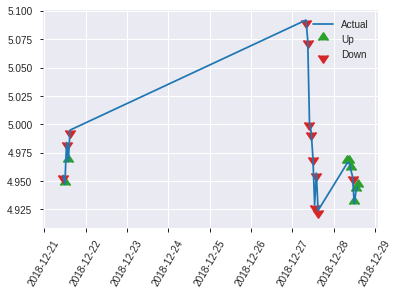


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2033221893362441
RMSE: 0.4509126182934384
LogLoss: 0.592287038053473
Mean Per-Class Error: 0.2796928694158076
AUC: 0.7889819587628866
pr_auc: 0.7700744027611554
Gini: 0.5779639175257731
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24392874538898468: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      50   46   0.4792   (46.0/96.0)
1      9    88   0.0928   (9.0/97.0)
Total  59   134  0.285    (55.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.243929     0.761905  133
max f2                       0.196867     0.858951  164
max f0point5                 0.497212     0.729443  69
max accuracy                 0.420717     0.720207  92
max precision                0.741681     1         0
max recall                   0.151801     1         184
max specificity              0.741681     1         0
max absolute_mcc             0.243929     0.464555  133
max min_per_class_accuracy   0.408923     0.71134   94
max mean_per_class_accuracy  0.420717     0.720307  92

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 40.30 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.739882           1.98969    1.98969            1                0.74098   1                           0.74098             0.0206186       0.0206186                  98.9691    98.9691
    2        0.0207254                   0.723759           1.98969    1.98969            1                0.736808  1                           0.738894            0.0206186       0.0412371                  98.9691    98.9691
    3        0.0310881                   0.710897           1.98969    1.98969            1                0.71802   1                           0.731936            0.0206186       0.0618557                  98.9691    98.9691
    4        0.0414508                   0.701527           0.994845   1.74098            0.5              0.706636  0.875                       0.725611            0.0103093       0.0721649                  -0.515464  74.0979
    5        0.0518135                   0.691333           1.98969    1.79072            1                0.700521  0.9                         0.720593            0.0206186       0.0927835                  98.9691    79.0722
    6        0.103627                    0.645303           1.79072    1.79072            0.9              0.661313  0.9                         0.690953            0.0927835       0.185567                   79.0722    79.0722
    7        0.150259                    0.623738           1.54754    1.71525            0.777778         0.63413   0.862069                    0.673319            0.0721649       0.257732                   54.7537    71.5251
    8        0.202073                    0.596271           1.59175    1.68358            0.8              0.608209  0.846154                    0.656624            0.0824742       0.340206                   59.1753    68.3584
    9        0.300518                    0.551008           1.36137    1.57803            0.684211         0.575668  0.793103                    0.630104            0.134021        0.474227                   36.1367    57.8031
    10       0.398964                    0.464971           1.25665    1.49873            0.631579         0.509134  0.753247                    0.600254            0.123711        0.597938                   25.6647    49.8728
    11       0.502591                    0.401032           1.09433    1.41535            0.55             0.432137  0.71134                     0.565591            0.113402        0.71134                    9.43299    41.5347
    12       0.601036                    0.30216            0.837765   1.32074            0.421053         0.350019  0.663793                    0.530282            0.0824742       0.793814                   -16.2235   32.0743
    13       0.699482                    0.243014           1.15193    1.29698            0.578947         0.272224  0.651852                    0.493962            0.113402        0.907216                   15.1926    29.6984
    14       0.797927                    0.210375           0.314162   1.17573            0.157895         0.228114  0.590909                    0.461163            0.0309278       0.938144                   -68.5838   17.5726
    15       0.896373                    0.179793           0.523603   1.10411            0.263158         0.197933  0.554913                    0.432253            0.0515464       0.989691                   -47.6397   10.4106
    16       1                           0.100223           0.0994845  1                  0.05             0.150315  0.502591  

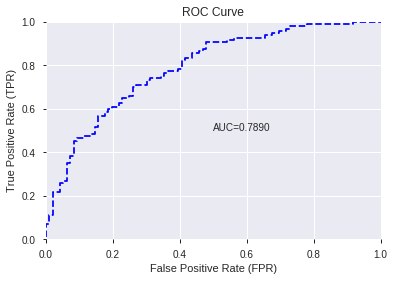

This function is available for GLM models only


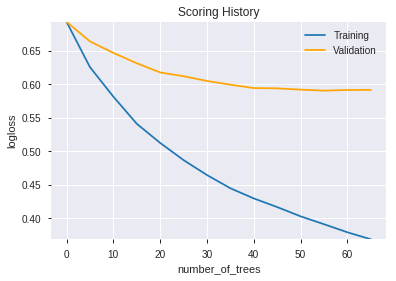

--2019-08-25 15:06:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190825_150527',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190825_150527',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_982d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_982d',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_150637_model_3  0.771692  0.619347              0.306970  0.449611  0.202150
1  DeepLearning_grid_1_AutoML_20190825_150637_model_4  0.768471  0.767959              0.285760  0.479615  0.230030
2  DeepLearning_grid_1_AutoML_20190825_150637_model_6  0.764175  0.581885              0.338273  0.448260  0.200937
3  DeepLearning_grid_1_AutoML_20190825_150637_model_9  0.762135  0.577000              0.296231  0.444462  0.197546
4  DeepLearning_grid_1_AutoML_20190825_150637_model_5  0.760524  0.572604              0.322487  0.443816  0.196973
5  DeepLearning_grid_1_AutoML_20190825_150637_model_8  0.759450  0.579694              0.312285  0.446046  0.198957
6  DeepLearning_grid_1_AutoML_20190825_150637_model_7  0.755799  0.623138              0.322648  0.461378  0.212870
7  DeepLearning_grid_1_AutoML_20190825_150637_model_2  0.740013  0.767469              0.327964  0.471649  0.222452
8  DeepLearning_grid_1_AutoML_20190825_150637_model_1  0.738832  0.989498              0.312339  0.511434  0.261565
9               DeepLearning_1_AutoML_20190825_150637  0.680520  0.690667              0.379832  0.479885  0.230290

variable  relative_importance  scaled_importance  percentage
0        CDL3LINESTRIKE             1.000000           1.000000    0.031559
1          CDLTHRUSTING             0.988818           0.988818    0.031206
2             CDLONNECK             0.982190           0.982190    0.030997
3        CDLEVENINGSTAR             0.978243           0.978243    0.030872
4           CDLPIERCING             0.971609           0.971609    0.030663
5    CDLEVENINGDOJISTAR             0.964715           0.964715    0.030445
6             CDLINNECK             0.957972           0.957972    0.030232
7          CDLTASUKIGAP             0.926826           0.926826    0.029249
8        CDLMORNINGSTAR             0.920248           0.920248    0.029042
9    CDLMORNINGDOJISTAR             0.918500           0.918500    0.028987
10    CDLDARKCLOUDCOVER             0.902110           0.902110    0.028469
11    CDL3WHITESOLDIERS             0.900296           0.900296    0.028412
12            CDL2CROWS             0.890645           0.890645    0.028108
13      CDLLADDERBOTTOM             0.889295           0.889295    0.028065
14  CDLGAPSIDESIDEWHITE             0.857808           0.857808    0.027071
15    CDLSTALLEDPATTERN             0.857259           0.857259    0.027054
16      CDLHOMINGPIGEON             0.856700           0.856700    0.027036
17      CDLADVANCEBLOCK             0.722158           0.722158    0.022790
18        CDLHANGINGMAN             0.715173           0.715173    0.022570
19    CDLINVERTEDHAMMER             0.706939           0.706939    0.022310
20        CDLHIKKAKEMOD             0.645034           0.645034    0.020356
21   CDLCLOSINGMARUBOZU             0.631848           0.631848    0.019940
22      CDLSHOOTINGSTAR             0.563345           0.563345    0.017778
23   CDLSEPARATINGLINES             0.553516           0.553516    0.017468
24            CDLTAKURI             0.546427           0.546427    0.017245
25                  BOP             0.539224           0.539224    0.017017
26                 hour             0.525365           0.525365    0.016580
27     CDLDRAGONFLYDOJI             0.522254           0.522254    0.016482
28          CDLLONGLINE             0.521407           0.521407    0.016455
29            CDLHAMMER             0.477872           0.477872    0.015081
30       CDLMATCHINGLOW             0.458928           0.458928    0.014483
31                  SUB             0.457434           0.457434    0.014436
32               TRANGE             0.452141           0.452141    0.014269
33          CDLMARUBOZU             0.450009           0.450009    0.014202
34       STOCHRSI_fastk             0.446755           0.446755    0.014099
35                  DIV             0.433337           0.433337    0.013676
36                 CEIL             0.431385           0.431385    0.013614
37    CDLGRAVESTONEDOJI             0.430884           0.430884    0.013598
38                FLOOR             0.429965           0.429965    0.013569
39         is_month_end             0.426708           0.426708    0.013466
40           CDL3INSIDE             0.426039           0.426039    0.013445
41       CDLHARAMICROSS             0.419527           0.419527    0.013240
42       is_month_start             0.411406           0.411406    0.012983
43       CDLSPINNINGTOP             0.408707           0.408707    0.012898
44               BETA_8             0.405843           0.405843    0.012808
45         CDLENGULFING             0.398912           0.398912    0.012589
46               ULTOSC             0.390222           0.390222    0.012315
47         weekday_name             0.380846           0.380846    0.012019
48    CDLLONGLEGGEDDOJI             0.310929           0.310929    0.009813
49  CDLXSIDEGAP3METHODS             0.283183           0.283183    0.008937

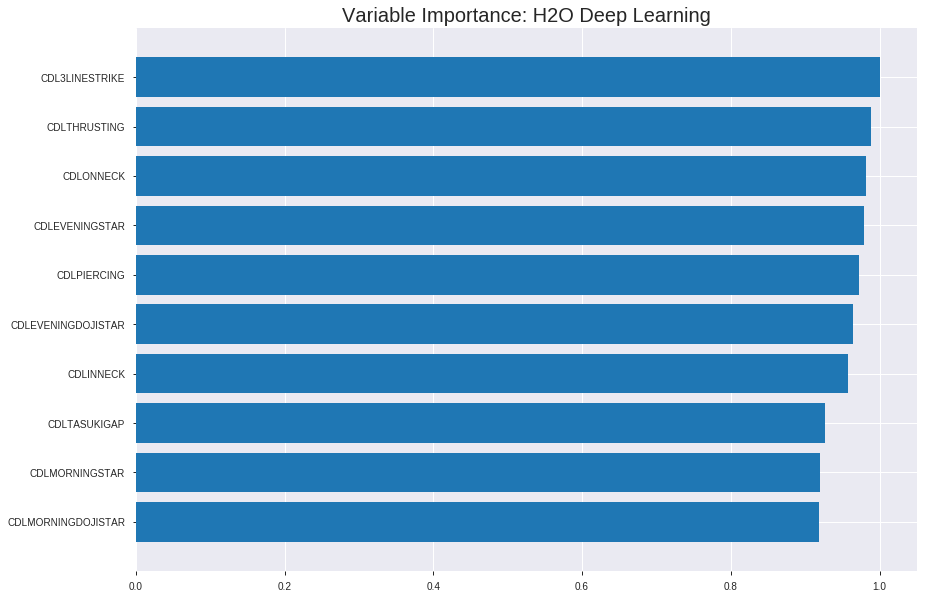

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_150637_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17745565379882877
RMSE: 0.42125485611305274
LogLoss: 0.5545603233545975
Mean Per-Class Error: 0.25416602965907353
AUC: 0.8123087592421493
pr_auc: 0.7748304447276815
Gini: 0.6246175184842986
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44094148622821444: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      506  207  0.2903   (207.0/713.0)
1      138  495  0.218    (138.0/633.0)
Total  644  702  0.2563   (345.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.440941     0.741573  214
max f2                       0.1275       0.835854  338
max f0point5                 0.600386     0.742324  152
max accuracy                 0.479138     0.743685  200
max precision                0.999879     1         0
max recall                   7.92093e-05  1         399
max specificity              0.999879     1         0
max absolute_mcc             0.440941     0.491255  214
max min_per_class_accuracy   0.484151     0.73913   198
max mean_per_class_accuracy  0.440941     0.745834  214

Gains/Lift Table: Avg response rate: 47.03 %, avg score: 46.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.998114           2.12638   2.12638            1                0.999471   1                           0.999471            0.0221169       0.0221169                  112.638   112.638
    2        0.0200594                   0.994852           1.79925   1.96887            0.846154         0.996858   0.925926                    0.998213            0.0173776       0.0394945                  79.9247   96.8873
    3        0.0304606                   0.99009            1.9745    1.97079            0.928571         0.992694   0.926829                    0.996328            0.0205371       0.0600316                  97.4498   97.0793
    4        0.0401189                   0.983218           1.96281   1.96887            0.923077         0.986287   0.925926                    0.993911            0.0189573       0.0789889                  96.2814   96.8873
    5        0.0505201                   0.972346           1.9745    1.97003            0.928571         0.977638   0.926471                    0.990561            0.0205371       0.0995261                  97.4498   97.0031
    6        0.100297                    0.884008           1.84075   1.90587            0.865672         0.93271    0.896296                    0.96185             0.0916272       0.191153                   84.0749   90.5869
    7        0.150074                    0.815171           1.77727   1.86322            0.835821         0.850012   0.876238                    0.924755            0.0884676       0.279621                   77.7275   86.3216
    8        0.200594                    0.745722           1.6886    1.81924            0.794118         0.775887   0.855556                    0.887262            0.0853081       0.364929                   68.8598   81.9238
    9        0.300149                    0.652801           1.53925   1.72637            0.723881         0.697109   0.811881                    0.824191            0.153239        0.518167                   53.9247   72.637
    10       0.400446                    0.567259           1.27583   1.61353            0.6              0.606912   0.758813                    0.769771            0.127962        0.64613                    27.5829   61.3526
    11       0.5                         0.46988            1.1108    1.51343            0.522388         0.517272   0.711738                    0.719496            0.110585        0.756714                   11.0797   51.3428
    12       0.600297                    0.347744           0.787549  1.39215            0.37037          0.404197   0.654703                    0.666816            0.0789889       0.835703                   -21.2451  39.2149
    13       0.699851                    0.247838           0.65061   1.28666            0.30597          0.301777   0.605096                    0.614889            0.0647709       0.900474                   -34.939   28.6664
    14       0.800149                    0.152567           0.48828   1.18659            0.22963          0.198864   0.558032                    0.562741            0.0489731       0.949447                   -51.172   18.6588
    15       0.899703                    0.0485744          0.269765  1.08514            0.126866         0.0954025  0.510322                    0.511029            0.0268562       0.976303                   -73.0235  8.51398
    16       1                           9.37724e-12        0.236265  1                  0.111111         0.0170732  0.470282                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19877860468591127
RMSE: 0.4458459427716162
LogLoss: 0.6813710580955474
Mean Per-Class Error: 0.28056169655285346
AUC: 0.7687709817407681
pr_auc: 0.734870708482906
Gini: 0.5375419634815362
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49213097344984746: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      154  53   0.256    (53.0/207.0)
1      54   123  0.3051   (54.0/177.0)
Total  208  176  0.2786   (107.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.492131     0.696884  175
max f2                       0.126727     0.822785  318
max f0point5                 0.601434     0.706134  130
max accuracy                 0.492131     0.721354  175
max precision                1            1         0
max recall                   1.61333e-06  1         380
max specificity              1            1         0
max absolute_mcc             0.492131     0.439062  175
max min_per_class_accuracy   0.472505     0.700565  180
max mean_per_class_accuracy  0.492131     0.719438  175

Gains/Lift Table: Avg response rate: 46.09 %, avg score: 46.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.999338           1.62712   1.62712            0.75             0.999997   0.75                        0.999997            0.0169492       0.0169492                  62.7119   62.7119
    2        0.0208333                   0.995487           2.16949   1.89831            1                0.997297   0.875                       0.998647            0.0225989       0.039548                   116.949   89.8305
    3        0.03125                     0.994742           2.16949   1.9887             1                0.994951   0.916667                    0.997415            0.0225989       0.0621469                  116.949   98.8701
    4        0.0416667                   0.990918           2.16949   2.0339             1                0.993398   0.9375                      0.996411            0.0225989       0.0847458                  116.949   103.39
    5        0.0520833                   0.986522           1.62712   1.95254            0.75             0.988545   0.9                         0.994838            0.0169492       0.101695                   62.7119   95.2542
    6        0.101562                    0.909361           1.82694   1.89135            0.842105         0.962817   0.871795                    0.979238            0.0903955       0.19209                    82.694    89.1352
    7        0.151042                    0.832447           1.59857   1.79544            0.736842         0.865448   0.827586                    0.941962            0.079096        0.271186                   59.8573   79.5441
    8        0.200521                    0.755918           1.71276   1.77504            0.789474         0.786406   0.818182                    0.903578            0.0847458       0.355932                   71.2756   77.5039
    9        0.299479                    0.635468           1.48439   1.679              0.684211         0.694593   0.773913                    0.834522            0.146893        0.502825                   48.4389   67.8998
    10       0.401042                    0.544542           1.16819   1.54964            0.538462         0.594255   0.714286                    0.773675            0.118644        0.621469                   16.8188   54.9637
    11       0.5                         0.454362           0.970562  1.43503            0.447368         0.497204   0.661458                    0.718957            0.0960452       0.717514                   -2.9438   43.5028
    12       0.598958                    0.365384           0.685103  1.31113            0.315789         0.405835   0.604348                    0.667223            0.0677966       0.785311                   -31.4897  31.1127
    13       0.700521                    0.258464           0.778792  1.23395            0.358974         0.308024   0.568773                    0.615146            0.079096        0.864407                   -22.1208  23.3949
    14       0.799479                    0.166184           0.685103  1.16601            0.315789         0.208903   0.537459                    0.564862            0.0677966       0.932203                   -31.4897  16.6013
    15       0.898438                    0.0462877          0.285459  1.06902            0.131579         0.109432   0.492754                    0.514699            0.0282486       0.960452                   -71.4541  6.90248
    16       1                           1.16244e-08        0.389396  1                  0.179487         0.0129563  0.460938                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:08:28  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 15:08:31  1 min 52.880 sec  5383 obs/sec      9.98291   1             13437      0.462399         0.739423            0.141717       0.763029        0.69419            1.9745           0.333581                         0.472059           0.808637              0.103168         0.745735          0.709566             2.16949            0.309896
    2019-08-25 15:08:37  1 min 58.868 sec  6382 obs/sec      39.9346   4             53752      0.435596         0.596791            0.238335       0.792842        0.745004           1.9745           0.291976                         0.454264           0.72725               0.169507         0.758591          0.719142             1.62712            0.359375
    2019-08-25 15:08:43  2 min  5.159 sec  7338 obs/sec      79.8759   8             107513     0.435457         0.590938            0.238821       0.791055        0.763602           2.12638          0.281575                         0.456256           0.729663              0.16221          0.749365          0.726264             2.16949            0.3125
    2019-08-25 15:08:49  2 min 10.668 sec  8023 obs/sec      119.805   12            161258     0.427093         0.575202            0.26778        0.802722        0.778079           1.9745           0.264487                         0.450952           0.693251              0.181576         0.757881          0.726005             2.16949            0.317708
    2019-08-25 15:08:54  2 min 16.382 sec  8350 obs/sec      159.741   16            215012     0.421255         0.55456             0.287661       0.812309        0.77483            2.12638          0.256315                         0.445846           0.681371              0.200003         0.768771          0.734871             1.62712            0.278646
    2019-08-25 15:09:00  2 min 22.490 sec  8875 obs/sec      209.669   21            282215     0.424219         0.571098            0.277602       0.808695        0.777464           1.82261          0.261516                         0.451845           0.706425              0.178329         0.756735          0.729583             2.16949            0.375
    2019-08-25 15:09:06  2 min 28.464 sec  9265 obs/sec      259.599   26            349420     0.41831          0.552565            0.297584       0.817757        0.774034           1.9745           0.274146                         0.447266           0.694737              0.1949           0.767024          0.728056             1.62712            0.351562
    2019-08-25 15:09:12  2 min 34.250 sec  9592 obs/sec      309.517   31            416610     0.416117         0.543744            0.304931       0.82135         0.789063           2.12638          0.248886                         0.447353           0.683924              0.194585         0.764704          0.724204             1.62712            0.309896
    2019-08-25 15:09:12  2 m

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
CDL3LINESTRIKE       1.0                    1.0                  0.031558728629881
CDLTHRUSTING         0.9888175129890442     0.9888175129890442   0.031205823556895076
CDLONNECK            0.9821896553039551     0.9821896553039551   0.03099665679481388
CDLEVENINGSTAR       0.978243350982666      0.978243350982666    0.03087211644764739
CDLPIERCING          0.9716091156005859     0.9716091156005859   0.03066274841355757
---                  ---                    ---                  ---
CDLENGULFING         0.39891180396080017    0.39891180396080017  0.01258914936845518
ULTOSC               0.39022186398506165    0.39022186398506165  0.012314905910950894
weekday_name         0.3808457553386688     0.3808457553386688   0.012019007842575102
CDLLONGLEGGEDDOJI    0.3109290599822998     0.3109290599822998   0.009812525827125392
CDLXSIDEGAP3METHODS  0.28318262100219727    0.28318262100219727  0.008936883488906783


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7202072538860104)

('F1', 0.7551867219917012)

('auc', 0.771692439862543)

('logloss', 0.6193470395912142)

('mean_per_class_error', 0.28033719931271484)

('rmse', 0.44961050875545755)

('mse', 0.20214960958334136)

deeplearning prediction progress: |███████████████████████████████████████| 100%


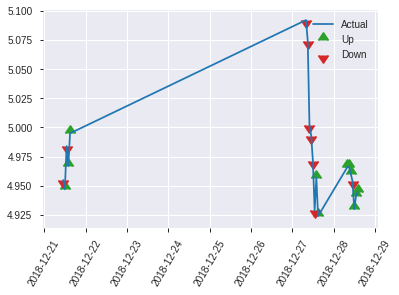


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20214960958334136
RMSE: 0.44961050875545755
LogLoss: 0.6193470395912142
Mean Per-Class Error: 0.28033719931271484
AUC: 0.771692439862543
pr_auc: 0.7278896156342192
Gini: 0.543384879725086
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2178625721960664: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      43   53   0.5521   (53.0/96.0)
1      6    91   0.0619   (6.0/97.0)
Total  49   144  0.3057   (59.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.217863     0.755187  143
max f2                       0.0978904    0.866071  171
max f0point5                 0.607974     0.710145  61
max accuracy                 0.35263      0.720207  116
max precision                0.999999     1         0
max recall                   0.0978904    1         171
max specificity              0.999999     1         0
max absolute_mcc             0.35263      0.449581  116
max min_per_class_accuracy   0.456752     0.690722  94
max mean_per_class_accuracy  0.35263      0.719663  116

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 45.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.999943           1.98969   1.98969            1                0.999985   1                           0.999985            0.0206186       0.0206186                  98.9691    98.9691
    2        0.0207254                   0.993748           0.994845  1.49227            0.5              0.999795   0.75                        0.99989             0.0103093       0.0309278                  -0.515464  49.2268
    3        0.0310881                   0.989466           1.98969   1.65808            1                0.992531   0.833333                    0.997437            0.0206186       0.0515464                  98.9691    65.8076
    4        0.0414508                   0.983475           1.98969   1.74098            1                0.987094   0.875                       0.994851            0.0206186       0.0721649                  98.9691    74.0979
    5        0.0518135                   0.965173           0.994845  1.59175            0.5              0.977141   0.8                         0.991309            0.0103093       0.0824742                  -0.515464  59.1753
    6        0.103627                    0.905989           1.59175   1.59175            0.8              0.938877   0.8                         0.965093            0.0824742       0.164948                   59.1753    59.1753
    7        0.150259                    0.793496           1.76861   1.64664            0.888889         0.827341   0.827586                    0.922342            0.0824742       0.247423                   76.8614    64.6641
    8        0.202073                    0.711933           1.19381   1.53053            0.6              0.749134   0.769231                    0.87793             0.0618557       0.309278                   19.3814    53.0531
    9        0.300518                    0.619025           1.57081   1.54373            0.789474         0.667626   0.775862                    0.809037            0.154639        0.463918                   57.0808    54.3726
    10       0.398964                    0.517745           1.15193   1.44705            0.578947         0.578008   0.727273                    0.75203             0.113402        0.57732                    15.1926    44.7048
    11       0.502591                    0.447001           1.09433   1.37432            0.55             0.480097   0.690722                    0.695961            0.113402        0.690722                   9.43299    37.4322
    12       0.601036                    0.353231           1.25665   1.35505            0.631579         0.393596   0.681034                    0.646436            0.123711        0.814433                   25.6647    35.5048
    13       0.699482                    0.261181           0.628323  1.25277            0.315789         0.312218   0.62963                     0.599398            0.0618557       0.876289                   -37.1677   25.2768
    14       0.797927                    0.162584           0.733044  1.18865            0.368421         0.209763   0.597403                    0.551326            0.0721649       0.948454                   -26.6956   18.8646
    15       0.896373                    0.0712731          0.523603  1.11561            0.263158         0.127013   0.560694                    0.504725            0.0515464       1                          -47.6397   11.5607
    16       1                           1.27264e-07        0         1                  0                0.0221993  0.502591  

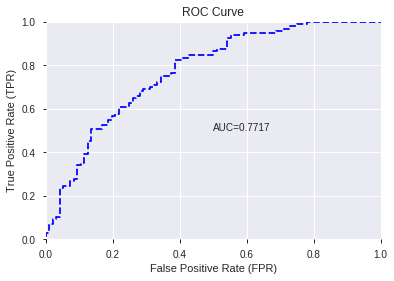

This function is available for GLM models only


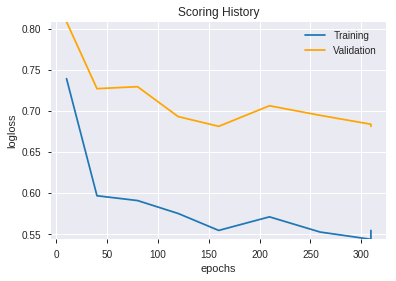

--2019-08-25 15:14:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.166.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.166.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_150637_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_150637_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_982d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDL3LINESTRIKE',
 'CDLTHRUSTING',
 'CDLONNECK',
 'CDLEVENINGSTAR',
 'CDLPIERCING',
 'CDLEVENINGDOJISTAR',
 'CDLINNECK',
 'CDLTASUKIGAP',
 'CDLMORNINGSTAR',
 'CDLMORNINGDOJISTAR',
 'CDLDARKCLOUDCOVER',
 'CDL3WHITESOLDIERS',
 'CDL2CROWS',
 'CDLLADDERBOTTOM',
 'CDLGAPSIDESIDEWHITE',
 'CDLSTALLEDPATTERN',
 'CDLHOMINGPIGEON',
 'CDLADVANCEBLOCK',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'CDLHIKKAKEMOD',
 'CDLCLOSINGMARUBOZU',
 'CDLSHOOTINGSTAR',
 'CDLSEPARATINGLINES',
 'CDLTAKURI',
 'BOP',
 'hour',
 'CDLDRAGONFLYDOJI',
 'CDLLONGLINE',
 'CDLHAMMER',
 'CDLMATCHINGLOW',
 'SUB',
 'TRANGE',
 'CDLMARUBOZU',
 'STOCHRSI_fastk',
 'DIV',
 'CEIL',
 'CDLGRAVESTONEDOJI',
 'FLOOR',
 'is_month_end',
 'CDL3INSIDE',
 'CDLHARAMICROSS',
 'is_month_start',
 'CDLSPINNINGTOP',
 'BETA_8',
 'CDLENGULFING',
 'ULTOSC',
 'weekday_name',
 'CDLLONGLEGGEDDOJI',
 'CDLXSIDEGAP3METHODS']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_151413_model_1  0.753866  0.577499               0.31744  0.445981  0.198899

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.363077           1.000000    0.108199
1                  hour             0.236455           0.651252    0.070465
2    CDLCLOSINGMARUBOZU             0.204545           0.563366    0.060956
3           CDLLONGLINE             0.143100           0.394131    0.042645
4             CDLHAMMER             0.130997           0.360798    0.039038
5        CDLMATCHINGLOW             0.127242           0.350456    0.037919
6                TRANGE             0.125438           0.345487    0.037381
7        CDLSPINNINGTOP             0.115378           0.317778    0.034383
8                   SUB             0.114537           0.315463    0.034133
9        STOCHRSI_fastk             0.110563           0.304517    0.032949
10               ULTOSC             0.109538           0.301694    0.032643
11                  DIV             0.087161           0.240063    0.025975
12         weekday_name             0.071644           0.197325    0.021350
13      CDLLADDERBOTTOM             0.069573           0.191620    0.020733
14    CDLGRAVESTONEDOJI             0.066488           0.183124    0.019814
15            CDLONNECK             0.064636           0.178024    0.019262
16  CDLXSIDEGAP3METHODS             0.064388           0.177340    0.019188
17         CDLTHRUSTING             0.058970           0.162416    0.017573
18    CDLINVERTEDHAMMER             0.058959           0.162388    0.017570
19          CDLPIERCING             0.057774           0.159123    0.017217
20         CDLENGULFING             0.056760           0.156331    0.016915
21       CDLEVENINGSTAR             0.054886           0.151170    0.016357
22            CDL2CROWS             0.053656           0.147783    0.015990
23        CDLHIKKAKEMOD             0.053309           0.146826    0.015886
24            CDLTAKURI             0.050037           0.137814    0.014911
25            CDLINNECK             0.048418           0.133354    0.014429
26               BETA_8             0.047511           0.130855    0.014158
27     CDLDRAGONFLYDOJI             0.044860           0.123556    0.013369
28      CDLADVANCEBLOCK             0.043838           0.120740    0.013064
29         CDLTASUKIGAP             0.042332           0.116591    0.012615
30           CDL3INSIDE             0.038792           0.106843    0.011560
31    CDLSTALLEDPATTERN             0.038481           0.105985    0.011467
32        CDLHANGINGMAN             0.037841           0.104223    0.011277
33       CDLHARAMICROSS             0.037565           0.103463    0.011195
34      CDLSHOOTINGSTAR             0.033963           0.093543    0.010121
35       CDL3LINESTRIKE             0.032561           0.089680    0.009703
36   CDLSEPARATINGLINES             0.027841           0.076681    0.008297
37                 CEIL             0.026505           0.073001    0.007899
38                FLOOR             0.026450           0.072850    0.007882
39   CDLMORNINGDOJISTAR             0.026290           0.072409    0.007835
40       CDLMORNINGSTAR             0.025854           0.071208    0.007705
41    CDL3WHITESOLDIERS             0.022780           0.062741    0.006789
42    CDLDARKCLOUDCOVER             0.020018           0.055134    0.005965
43          CDLMARUBOZU             0.018332           0.050491    0.005463
44       is_month_start             0.018227           0.050201    0.005432
45      CDLHOMINGPIGEON             0.017027           0.046897    0.005074
46   CDLEVENINGDOJISTAR             0.012370           0.034069    0.003686
47    CDLLONGLEGGEDDOJI             0.008241           0.022697    0.002456
48  CDLGAPSIDESIDEWHITE             0.005668           0.015611    0.001689
49         is_month_end             0.004748           0.013077    0.001415

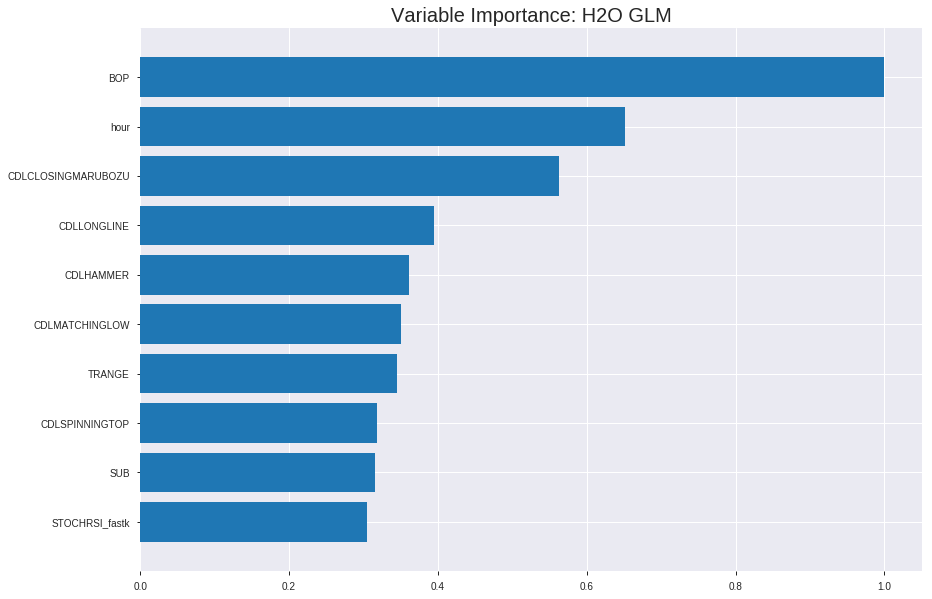

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_151413_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18999349108589042
RMSE: 0.43588242805358696
LogLoss: 0.5621608371050286
Null degrees of freedom: 1345
Residual degrees of freedom: 1295
Null deviance: 1861.1945775256659
Residual deviance: 1513.336973486737
AIC: 1615.336973486737
AUC: 0.7885622240095362
pr_auc: 0.757380375240563
Gini: 0.5771244480190725
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37729895428865834: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      375  338  0.4741   (338.0/713.0)
1      81   552  0.128    (81.0/633.0)
Total  456  890  0.3113   (419.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.377299     0.724885  256
max f2                       0.22931      0.832431  330
max f0point5                 0.574993     0.711715  144
max accuracy                 0.512775     0.719168  175
max precision                0.918771     1         0
max recall                   0.0754975    1         388
max specificity              0.918771     1         0
max absolute_mcc             0.431726     0.435141  223
max min_per_class_accuracy   0.478367     0.7109    196
max mean_per_class_accuracy  0.465514     0.716358  204

Gains/Lift Table: Avg response rate: 47.03 %, avg score: 47.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.87986            1.82261   1.82261            0.857143         0.899063  0.857143                    0.899063            0.0189573       0.0189573                  82.2613   82.2613
    2        0.0200594                   0.859708           1.96281   1.89012            0.923077         0.870298  0.888889                    0.885213            0.0189573       0.0379147                  96.2814   89.0118
    3        0.0304606                   0.841249           1.82261   1.86707            0.857143         0.850334  0.878049                    0.873303            0.0189573       0.056872                   82.2613   86.7067
    4        0.0401189                   0.814167           2.12638   1.9295             1                0.824721  0.907407                    0.861608            0.0205371       0.0774092                  112.638   92.9495
    5        0.0505201                   0.800124           2.12638   1.97003            1                0.806028  0.926471                    0.850165            0.0221169       0.0995261                  112.638   97.0031
    6        0.100297                    0.733535           1.84075   1.90587            0.865672         0.762361  0.896296                    0.806588            0.0916272       0.191153                   84.0749   90.5869
    7        0.150074                    0.681114           1.49164   1.76848            0.701493         0.704922  0.831683                    0.772867            0.0742496       0.265403                   49.1641   76.8476
    8        0.200594                    0.652154           1.78241   1.77199            0.838235         0.666927  0.833333                    0.746186            0.0900474       0.35545                    78.2409   77.1985
    9        0.300149                    0.599808           1.4123    1.65268            0.664179         0.623454  0.777228                    0.705478            0.1406          0.496051                   41.2299   65.2683
    10       0.400446                    0.534253           1.21283   1.54251            0.57037          0.569699  0.725417                    0.67147             0.121643        0.617694                   21.2825   54.2515
    11       0.5                         0.47069            1.09493   1.4534             0.514925         0.500427  0.683507                    0.637414            0.109005        0.726698                   9.49282   45.3397
    12       0.600297                    0.412837           0.897806  1.36057            0.422222         0.441652  0.639851                    0.604706            0.0900474       0.816746                   -10.2194  36.0569
    13       0.699851                    0.354542           0.761689  1.27538            0.358209         0.384003  0.599788                    0.573311            0.0758294       0.892575                   -23.8311  27.5378
    14       0.800149                    0.289841           0.519782  1.18067            0.244444         0.323089  0.555246                    0.541946            0.0521327       0.944708                   -48.0218  18.0665
    15       0.899703                    0.19163            0.349108  1.08865            0.164179         0.242337  0.511974                    0.508794            0.0347551       0.979463                   -65.0892  8.86516
    16       1                           0.0173893          0.204763  1                  0.0962963        0.124822  0.470282                    0.470282         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19925411530430437
RMSE: 0.44637889209090564
LogLoss: 0.5845209521152754
Null degrees of freedom: 383
Residual degrees of freedom: 333
Null deviance: 530.1256103466318
Residual deviance: 448.91209122453154
AIC: 550.9120912245315
AUC: 0.7609105051993778
pr_auc: 0.715014075944042
Gini: 0.5218210103987555
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45934410326438135: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      143  64   0.3092   (64.0/207.0)
1      47   130  0.2655   (47.0/177.0)
Total  190  194  0.2891   (111.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459344     0.700809  193
max f2                       0.283736     0.817734  306
max f0point5                 0.527113     0.703794  159
max accuracy                 0.527113     0.721354  159
max precision                0.952979     1         0
max recall                   0.0897401    1         374
max specificity              0.952979     1         0
max absolute_mcc             0.527113     0.437119  159
max min_per_class_accuracy   0.475956     0.706215  184
max mean_per_class_accuracy  0.527113     0.716163  159

Gains/Lift Table: Avg response rate: 46.09 %, avg score: 47.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.907581           2.16949   2.16949            1                0.936175  1                           0.936175            0.0225989       0.0225989                  116.949   116.949
    2        0.0208333                   0.878027           2.16949   2.16949            1                0.890584  1                           0.913379            0.0225989       0.0451977                  116.949   116.949
    3        0.03125                     0.848379           1.62712   1.9887             0.75             0.862209  0.916667                    0.896323            0.0169492       0.0621469                  62.7119   98.8701
    4        0.0416667                   0.833426           1.62712   1.89831            0.75             0.842294  0.875                       0.882815            0.0169492       0.079096                   62.7119   89.8305
    5        0.0520833                   0.822948           1.62712   1.84407            0.75             0.828513  0.85                        0.871955            0.0169492       0.0960452                  62.7119   84.4068
    6        0.101562                    0.756096           1.59857   1.72447            0.736842         0.788871  0.794872                    0.831478            0.079096        0.175141                   59.8573   72.4468
    7        0.151042                    0.699372           1.48439   1.64582            0.684211         0.726958  0.758621                    0.797239            0.0734463       0.248588                   48.4389   64.5821
    8        0.200521                    0.654526           1.82694   1.69051            0.842105         0.671138  0.779221                    0.766123            0.0903955       0.338983                   82.694    69.0513
    9        0.299479                    0.60357            1.4273    1.60354            0.657895         0.633754  0.73913                     0.722384            0.141243        0.480226                   42.7297   60.3537
    10       0.401042                    0.5445             1.44633   1.56372            0.666667         0.576628  0.720779                    0.685471            0.146893        0.627119                   44.6328   56.3724
    11       0.5                         0.462589           0.970562  1.44633            0.447368         0.499519  0.666667                    0.648668            0.0960452       0.723164                   -2.9438   44.6328
    12       0.598958                    0.410722           0.742194  1.32999            0.342105         0.432307  0.613043                    0.612922            0.0734463       0.79661                    -25.7806  32.9993
    13       0.700521                    0.3539             0.667536  1.23395            0.307692         0.379301  0.568773                    0.579051            0.0677966       0.864407                   -33.2464  23.3949
    14       0.799479                    0.283633           0.742194  1.17308            0.342105         0.318951  0.540717                    0.546856            0.0734463       0.937853                   -25.7806  17.308
    15       0.898438                    0.191438           0.228368  1.06902            0.105263         0.241806  0.492754                    0.513257            0.0225989       0.960452                   -77.1632  6.90248
    16       1                           0.0462524          0.389396  1                  0.179487         0.125375  0.460938                    0.473862          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 15:14:13  0.000 sec   2            18        51            1.36673           1.36488
    2019-08-25 15:14:13  0.007 sec   4            11        51            1.35787           1.35626
    2019-08-25 15:14:13  0.015 sec   6            7.1       51            1.34485           1.34365
    2019-08-25 15:14:13  0.022 sec   8            4.4       51            1.32661           1.32609
    2019-08-25 15:14:13  0.029 sec   10           2.7       51            1.30266           1.30328
    2019-08-25 15:14:13  0.037 sec   12           1.7       51            1.27371           1.27623
    2019-08-25 15:14:13  0.044 sec   14           1.1       51            1.24192           1.24749
    2019-08-25 15:14:13  0.051 sec   16           0.65      51            1.21021           1.2204
    2019-08-25 15:14:13  0.059 sec   18           0.41      51            1.18135           1.19798
    2019-08-25 15:14:13  0.071 sec   20           0.25      51            1.15716           1.18195
    2019-08-25 15:14:13  0.088 sec   22           0.16      51            1.13825           1.17259
    2019-08-25 15:14:13  0.097 sec   24           0.097     51            1.12432           1.16904
    2019-08-25 15:14:13  0.109 sec   26           0.06      51            1.11454           1.16998
    2019-08-25 15:14:13  0.124 sec   28           0.037     51            1.10793           1.17412
    2019-08-25 15:14:13  0.140 sec   30           0.023     51            1.10363           1.18046
    2019-08-25 15:14:13  0.149 sec   32           0.014     51            1.10089           1.18831
    2019-08-25 15:14:13  0.158 sec   34           0.009     51            1.0991            1.19711

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.694300518134715)

('F1', 0.7510204081632653)

('auc', 0.7538659793814433)

('logloss', 0.5774989402160231)

('mean_per_class_error', 0.30670103092783507)

('rmse', 0.44598067233802324)

('mse', 0.19889876009907523)

glm prediction progress: |████████████████████████████████████████████████| 100%


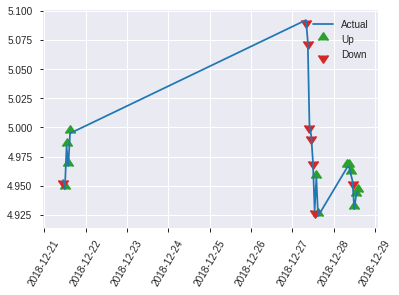


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19889876009907523
RMSE: 0.44598067233802324
LogLoss: 0.5774989402160231
Null degrees of freedom: 192
Residual degrees of freedom: 142
Null deviance: 268.35681432348866
Residual deviance: 222.9145909233849
AIC: 324.91459092338494
AUC: 0.7538659793814433
pr_auc: 0.7230668379356129
Gini: 0.5077319587628866
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3236131966815971: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      40   56   0.5833   (56.0/96.0)
1      5    92   0.0515   (5.0/97.0)
Total  45   148  0.3161   (61.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.323613     0.75102   147
max f2                       0.238858     0.863309  167
max f0point5                 0.556333     0.699301  82
max accuracy                 0.38141      0.694301  133
max precision                0.942164     1         0
max recall                   0.192537     1         175
max specificity              0.942164     1         0
max absolute_mcc             0.323613     0.431738  147
max min_per_class_accuracy   0.513719     0.670103  94
max mean_per_class_accuracy  0.38141      0.693299  133

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 48.97 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.894622           1.98969    1.98969            1                0.927164  1                           0.927164            0.0206186       0.0206186                  98.9691    98.9691
    2        0.0207254                   0.866061           1.98969    1.98969            1                0.892665  1                           0.909915            0.0206186       0.0412371                  98.9691    98.9691
    3        0.0310881                   0.841935           1.98969    1.98969            1                0.85874   1                           0.892856            0.0206186       0.0618557                  98.9691    98.9691
    4        0.0414508                   0.780992           1.98969    1.98969            1                0.81017   1                           0.872185            0.0206186       0.0824742                  98.9691    98.9691
    5        0.0518135                   0.771467           1.98969    1.98969            1                0.776242  1                           0.852996            0.0206186       0.103093                   98.9691    98.9691
    6        0.103627                    0.72221            0.994845   1.49227            0.5              0.745399  0.75                        0.799197            0.0515464       0.154639                   -0.515464  49.2268
    7        0.150259                    0.707399           1.54754    1.50942            0.777778         0.71391   0.758621                    0.772729            0.0721649       0.226804                   54.7537    50.9421
    8        0.202073                    0.675029           1.59175    1.53053            0.8              0.687045  0.769231                    0.750759            0.0824742       0.309278                   59.1753    53.0531
    9        0.300518                    0.629715           1.36137    1.47512            0.684211         0.650835  0.741379                    0.718025            0.134021        0.443299                   36.1367    47.5116
    10       0.398964                    0.568994           1.15193    1.39537            0.578947         0.597025  0.701299                    0.688168            0.113402        0.556701                   15.1926    39.5368
    11       0.502591                    0.505801           1.09433    1.3333             0.55             0.539732  0.670103                    0.657563            0.113402        0.670103                   9.43299    33.3298
    12       0.601036                    0.456806           1.04721    1.28644            0.526316         0.4799    0.646552                    0.628463            0.103093        0.773196                   4.72056    28.6438
    13       0.699482                    0.380703           1.15193    1.26751            0.578947         0.41041   0.637037                    0.597774            0.113402        0.886598                   15.1926    26.7507
    14       0.797927                    0.294028           0.733044   1.20157            0.368421         0.331067  0.603896                    0.564868            0.0721649       0.958763                   -26.6956   20.1566
    15       0.896373                    0.215101           0.314162   1.10411            0.157895         0.253917  0.554913                    0.530718            0.0309278       0.989691                   -68.5838   10.4106
    16       1                           0.0500971          0.0994845  1                  0.05             0.134522  0.502591  

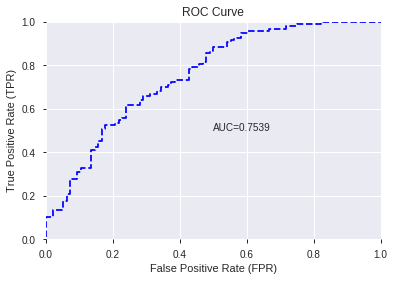

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


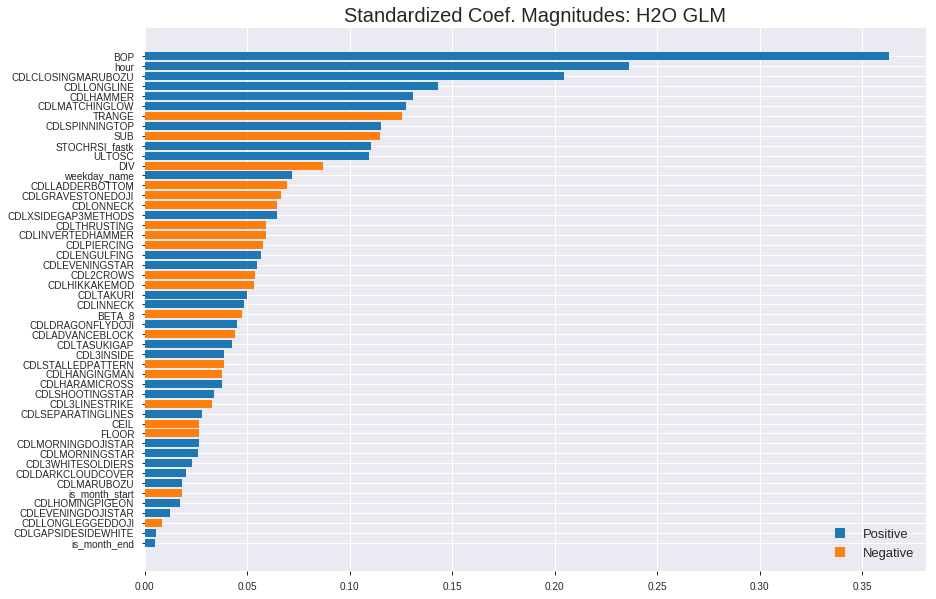

'log_likelihood'
--2019-08-25 15:14:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_151413_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_151413_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_982d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'hour',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLHAMMER',
 'CDLMATCHINGLOW',
 'TRANGE',
 'CDLSPINNINGTOP',
 'SUB',
 'STOCHRSI_fastk',
 'ULTOSC',
 'DIV',
 'weekday_name',
 'CDLLADDERBOTTOM',
 'CDLGRAVESTONEDOJI',
 'CDLONNECK',
 'CDLXSIDEGAP3METHODS',
 'CDLTHRUSTING',
 'CDLINVERTEDHAMMER',
 'CDLPIERCING',
 'CDLENGULFING',
 'CDLEVENINGSTAR',
 'CDL2CROWS',
 'CDLHIKKAKEMOD',
 'CDLTAKURI',
 'CDLINNECK',
 'BETA_8',
 'CDLDRAGONFLYDOJI',
 'CDLADVANCEBLOCK',
 'CDLTASUKIGAP',
 'CDL3INSIDE',
 'CDLSTALLEDPATTERN',
 'CDLHANGINGMAN',
 'CDLHARAMICROSS',
 'CDLSHOOTINGSTAR',
 'CDL3LINESTRIKE',
 'CDLSEPARATINGLINES',
 'CEIL',
 'FLOOR',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDL3WHITESOLDIERS',
 'CDLDARKCLOUDCOVER',
 'CDLMARUBOZU',
 'is_month_start',
 'CDLHOMINGPIGEON',
 'CDLEVENINGDOJISTAR',
 'CDLLONGLEGGEDDOJI',
 'CDLGAPSIDESIDEWHITE',
 'is_month_end']

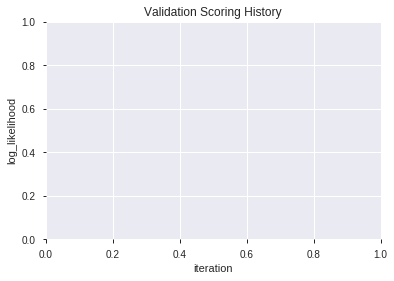

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_151432_model_7  0.775451  0.574787              0.275021  0.440954  0.194440
1               XGBoost_3_AutoML_20190825_151432  0.770619  0.576224              0.301332  0.442255  0.195590
2  XGBoost_grid_1_AutoML_20190825_151432_model_1  0.768256  0.577363              0.306808  0.443204  0.196430
3               XGBoost_1_AutoML_20190825_151432  0.767612  0.577652              0.296070  0.443626  0.196804
4  XGBoost_grid_1_AutoML_20190825_151432_model_3  0.763209  0.577366              0.327695  0.444155  0.197274
5  XGBoost_grid_1_AutoML_20190825_151432_model_5  0.762350  0.587471              0.311802  0.445924  0.198848
6  XGBoost_grid_1_AutoML_20190825_151432_model_6  0.760095  0.585420              0.333011  0.446984  0.199794
7  XGBoost_grid_1_AutoML_20190825_151432_model_2  0.752577  0.592426              0.311909  0.449909  0.202418
8               XGBoost_2_AutoML_20190825_151432  0.750430  0.595875              0.311856  0.451728  0.204058
9  XGBoost_grid_1_AutoML_20190825_151432_model_4  0.745168  0.596670              0.296177  0.452043  0.204343

variable  relative_importance  scaled_importance  percentage
0                  BOP          1455.728638           1.000000    0.228297
1       STOCHRSI_fastk           711.958313           0.489074    0.111654
2                  DIV           664.037903           0.456155    0.104139
3               TRANGE           652.548157           0.448262    0.102337
4               ULTOSC           605.764404           0.416125    0.095000
5               BETA_8           603.515869           0.414580    0.094648
6                 hour           503.581238           0.345931    0.078975
7                  SUB           459.347900           0.315545    0.072038
8         weekday_name           262.482269           0.180310    0.041164
9   CDLCLOSINGMARUBOZU           191.885849           0.131814    0.030093
10           CDLHAMMER            92.903625           0.063819    0.014570
11         CDLLONGLINE            43.411263           0.029821    0.006808
12      CDLSPINNINGTOP            40.370438           0.027732    0.006331
13   CDLLONGLEGGEDDOJI            37.080357           0.025472    0.005815
14                CEIL            20.754309           0.014257    0.003255
15   CDLGRAVESTONEDOJI            16.581991           0.011391    0.002601
16      CDLMATCHINGLOW             8.962259           0.006157    0.001406
17               FLOOR             5.542840           0.003808    0.000869

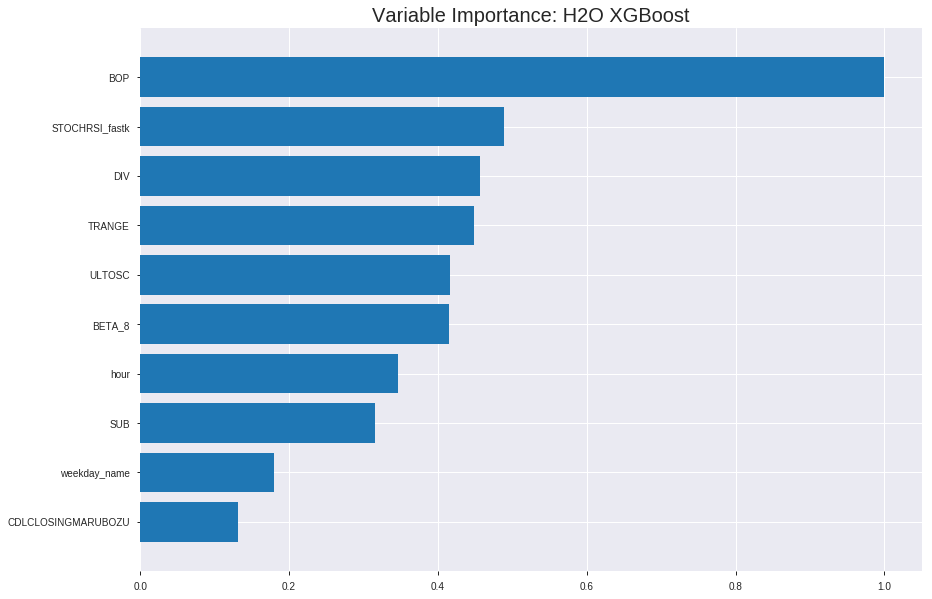

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_151432_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13527909297727264
RMSE: 0.3678030627622242
LogLoss: 0.43335518497732023
Mean Per-Class Error: 0.16384167647104442
AUC: 0.9107679763542781
pr_auc: 0.8964965409872842
Gini: 0.8215359527085562
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4790356382727623: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      581  132  0.1851   (132.0/713.0)
1      91   542  0.1438   (91.0/633.0)
Total  672  674  0.1657   (223.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479036     0.82938   203
max f2                       0.282966     0.879168  291
max f0point5                 0.609611     0.852387  139
max accuracy                 0.489587     0.83581   198
max precision                0.92343      1         0
max recall                   0.118007     1         363
max specificity              0.92343      1         0
max absolute_mcc             0.489587     0.671396  198
max min_per_class_accuracy   0.496397     0.834502  196
max mean_per_class_accuracy  0.489587     0.836158  198

Gains/Lift Table: Avg response rate: 47.03 %, avg score: 46.87 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.88846            2.12638    2.12638            1                0.902036   1                           0.902036            0.0221169       0.0221169                  112.638   112.638
    2        0.0200594                   0.874815           1.96281    2.04763            0.923077         0.881706   0.962963                    0.892247            0.0189573       0.0410742                  96.2814   104.763
    3        0.0304606                   0.861879           2.12638    2.07452            1                0.868946   0.97561                     0.884291            0.0221169       0.0631912                  112.638   107.452
    4        0.0401189                   0.854524           2.12638    2.087              1                0.858708   0.981481                    0.878132            0.0205371       0.0837283                  112.638   108.7
    5        0.0505201                   0.845767           2.12638    2.09511            1                0.850317   0.985294                    0.872405            0.0221169       0.105845                   112.638   109.511
    6        0.100297                    0.796251           1.99943    2.04763            0.940299         0.820203   0.962963                    0.846497            0.0995261       0.205371                   99.9434   104.763
    7        0.150074                    0.751689           1.99943    2.03164            0.940299         0.774158   0.955446                    0.822504            0.0995261       0.304897                   99.9434   103.164
    8        0.200594                    0.721836           2.0013     2.024              0.941176         0.737852   0.951852                    0.801184            0.101106        0.406003                   100.13    102.4
    9        0.300149                    0.643471           1.87249    1.97375            0.880597         0.683182   0.928218                    0.762045            0.186414        0.592417                   87.2486   97.3746
    10       0.400446                    0.566047           1.46484    1.84628            0.688889         0.60534    0.868275                    0.722796            0.146919        0.739336                   46.4841   84.6284
    11       0.5                         0.478711           1.1584     1.70932            0.544776         0.521441   0.803863                    0.682704            0.115324        0.85466                    15.8402   70.9321
    12       0.600297                    0.39387            0.582786   1.5211             0.274074         0.438055   0.715347                    0.641828            0.0584518       0.913112                   -41.7214  52.11
    13       0.699851                    0.305171           0.476056   1.37244            0.223881         0.347436   0.645435                    0.599951            0.0473934       0.960506                   -52.3944  37.2442
    14       0.800149                    0.191729           0.31502    1.2399             0.148148         0.250935   0.583101                    0.556202            0.0315956       0.992101                   -68.498   23.9896
    15       0.899703                    0.116685           0.0793426  1.11148            0.0373134        0.149483   0.522709                    0.511198            0.00789889      1                          -92.0657  11.1478
    16       1                           0.0435974          0          1                  0                0.0876494  0.470282       



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20165088388261868
RMSE: 0.4490555465447662
LogLoss: 0.5865849579380694
Mean Per-Class Error: 0.30246458691558176
AUC: 0.7530773219793117
pr_auc: 0.6981017156628277
Gini: 0.5061546439586233
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3371801972389221: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      107  100  0.4831   (100.0/207.0)
1      27   150  0.1525   (27.0/177.0)
Total  134  250  0.3307   (127.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.33718      0.702576  249
max f2                       0.138111     0.83652   337
max f0point5                 0.586018     0.699001  130
max accuracy                 0.586018     0.708333  130
max precision                0.898138     1         0
max recall                   0.0939622    1         369
max specificity              0.898138     1         0
max absolute_mcc             0.586018     0.414524  130
max min_per_class_accuracy   0.49353      0.671498  186
max mean_per_class_accuracy  0.583447     0.697535  132

Gains/Lift Table: Avg response rate: 46.09 %, avg score: 46.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.874939           1.62712   1.62712            0.75             0.89251    0.75                        0.89251             0.0169492       0.0169492                  62.7119   62.7119
    2        0.0208333                   0.85208            2.16949   1.89831            1                0.869092   0.875                       0.880801            0.0225989       0.039548                   116.949   89.8305
    3        0.03125                     0.842975           2.16949   1.9887             1                0.846953   0.916667                    0.869519            0.0225989       0.0621469                  116.949   98.8701
    4        0.0416667                   0.834529           2.16949   2.0339             1                0.838312   0.9375                      0.861717            0.0225989       0.0847458                  116.949   103.39
    5        0.0520833                   0.819618           1.08475   1.84407            0.5              0.825896   0.85                        0.854553            0.0112994       0.0960452                  8.47458   84.4068
    6        0.101562                    0.767419           1.59857   1.72447            0.736842         0.790638   0.794872                    0.823415            0.079096        0.175141                   59.8573   72.4468
    7        0.151042                    0.740597           1.71276   1.72063            0.789474         0.755121   0.793103                    0.801043            0.0847458       0.259887                   71.2756   72.0631
    8        0.200521                    0.683237           1.14184   1.57781            0.526316         0.716323   0.727273                    0.780138            0.0564972       0.316384                   14.1838   57.7812
    9        0.299479                    0.613754           1.59857   1.58467            0.736842         0.649086   0.730435                    0.736834            0.158192        0.474576                   59.8573   58.4672
    10       0.401042                    0.544219           1.16819   1.4792             0.538462         0.581181   0.681818                    0.697415            0.118644        0.59322                    16.8188   47.9199
    11       0.5                         0.477418           1.02765   1.38983            0.473684         0.51312    0.640625                    0.66094             0.101695        0.694915                   2.76539   38.9831
    12       0.598958                    0.396033           0.91347   1.31113            0.421053         0.439152   0.604348                    0.624297            0.0903955       0.785311                   -8.65299  31.1127
    13       0.700521                    0.298667           0.945676  1.25814            0.435897         0.34154    0.579926                    0.583302            0.0960452       0.881356                   -5.43242  25.8144
    14       0.799479                    0.214615           0.513827  1.16601            0.236842         0.252517   0.537459                    0.542358            0.0508475       0.932203                   -48.6173  16.6013
    15       0.898438                    0.133153           0.570919  1.10047            0.263158         0.169567   0.507246                    0.501297            0.0564972       0.988701                   -42.9081  10.0467
    16       1                           0.0525474          0.111256  1                  0.0512821        0.0974971  0.460938                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:14:45  8.610 sec   0                  0.5              0.693147            0.5             0                  1                0.529718                         0.5                0.693147              0.5               0                    1                  0.539062
    2019-08-25 15:14:45  8.706 sec   5                  0.470743         0.635934            0.830184        0.804895           2.12638          0.268945                         0.481666           0.656884              0.723833          0.683647             2.16949            0.395833
    2019-08-25 15:14:45  8.782 sec   10                 0.450731         0.597477            0.845725        0.817918           2.12638          0.263744                         0.469768           0.633198              0.737738          0.691198             2.16949            0.354167
    2019-08-25 15:14:45  8.861 sec   15                 0.433445         0.564078            0.856478        0.832022           1.9745           0.240713                         0.463264           0.619635              0.735309          0.67889              2.16949            0.377604
    2019-08-25 15:14:45  8.935 sec   20                 0.420688         0.538873            0.863515        0.842941           2.12638          0.224368                         0.457459           0.607121              0.742105          0.68757              2.16949            0.395833
    2019-08-25 15:14:45  9.009 sec   25                 0.410823         0.519065            0.870795        0.851751           2.12638          0.224368                         0.457237           0.605832              0.735637          0.675153             2.16949            0.34375
    2019-08-25 15:14:45  9.089 sec   30                 0.403061         0.503381            0.877948        0.858718           2.12638          0.201337                         0.454011           0.598411              0.742269          0.682063             2.16949            0.335938
    2019-08-25 15:14:46  9.162 sec   35                 0.394987         0.48709             0.887           0.87127            2.12638          0.191679                         0.452652           0.594683              0.743088          0.684468             2.16949            0.328125
    2019-08-25 15:14:46  9.236 sec   40                 0.388077         0.473083            0.891846        0.877016           2.12638          0.187221                         0.450707           0.590398              0.747892          0.691291             1.62712            0.346354
    2019-08-25 15:14:46  9.311 sec   45                 0.382558         0.46197             0.896934        0.882207           2.12638          0.18425                          0.451181           0.591118              0.74549           0.688519             1.62712            0.346354
    2019-08-25 15:14:46  9.388 sec   50                 0.377447         0.451766            0.90165         0.886979           2.12638          0.178306                         0.451045           0.590856              0.746336          0.689133             1.62712            0.351562
    2019-08-25 15:14:46  9.467 sec   55                 0.372276         0.441782            0.906512        0.891988           2.12638          0.167905                         0.450592           0.589868              0.748601          0.

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
BOP                 1455.73                1                    0.228297
STOCHRSI_fastk      711.958                0.489074             0.111654
DIV                 664.038                0.456155             0.104139
TRANGE              652.548                0.448262             0.102337
ULTOSC              605.764                0.416125             0.0950001
BETA_8              603.516                0.41458              0.0946475
hour                503.581                0.345931             0.0789751
SUB                 459.348                0.315545             0.0720381
weekday_name        262.482                0.18031              0.0411643
CDLCLOSINGMARUBOZU  191.886                0.131814             0.0300929
CDLHAMMER           92.9036                0.0638193            0.0145698
CDLLONGLINE         43.4113                0.029821             0.00680805
CDLSPINNINGTOP      40.3704                0.0277321            0.00633117
CDLLONGLEGGEDDOJI   37.0804                0.025472             0.0058152
CEIL                20.7543                0.014257             0.00325483
CDLGRAVESTONEDOJI   16.582                 0.0113909            0.0026005
CDLMATCHINGLOW      8.96226                0.00615655           0.00140552
FLOOR               5.54284                0.00380761           0.000869266

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7253886010362695)

('F1', 0.7464114832535885)

('auc', 0.775451030927835)

('logloss', 0.5747867506579799)

('mean_per_class_error', 0.27502147766323026)

('rmse', 0.44095407731470987)

('mse', 0.1944404983004671)

xgboost prediction progress: |████████████████████████████████████████████| 100%


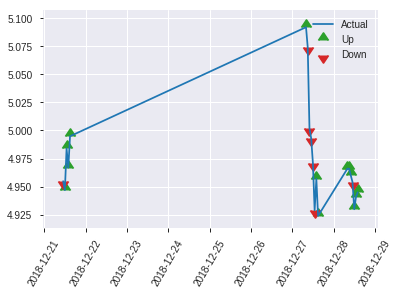


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1944404983004671
RMSE: 0.44095407731470987
LogLoss: 0.5747867506579799
Mean Per-Class Error: 0.27502147766323026
AUC: 0.775451030927835
pr_auc: 0.7747718581647525
Gini: 0.5509020618556699
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41713812947273254: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   34   0.3542   (34.0/96.0)
1      19   78   0.1959   (19.0/97.0)
Total  81   112  0.2746   (53.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.417138     0.746411  111
max f2                       0.179776     0.84392   162
max f0point5                 0.629193     0.723077  56
max accuracy                 0.417138     0.725389  111
max precision                0.910604     1         0
max recall                   0.0497705    1         190
max specificity              0.910604     1         0
max absolute_mcc             0.417138     0.45587   111
max min_per_class_accuracy   0.478376     0.701031  93
max mean_per_class_accuracy  0.417138     0.724979  111

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 46.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.898882           1.98969   1.98969            1                0.910362   1                           0.910362            0.0206186       0.0206186                  98.9691   98.9691
    2        0.0207254                   0.88777            1.98969   1.98969            1                0.894163   1                           0.902263            0.0206186       0.0412371                  98.9691   98.9691
    3        0.0310881                   0.837337           1.98969   1.98969            1                0.865555   1                           0.890027            0.0206186       0.0618557                  98.9691   98.9691
    4        0.0414508                   0.818793           1.98969   1.98969            1                0.831067   1                           0.875287            0.0206186       0.0824742                  98.9691   98.9691
    5        0.0518135                   0.808979           1.98969   1.98969            1                0.81357    1                           0.862943            0.0206186       0.103093                   98.9691   98.9691
    6        0.103627                    0.763347           1.59175   1.79072            0.8              0.784767   0.9                         0.823855            0.0824742       0.185567                   59.1753   79.0722
    7        0.150259                    0.722433           1.76861   1.78386            0.888889         0.741034   0.896552                    0.798152            0.0824742       0.268041                   76.8614   78.3861
    8        0.202073                    0.677214           1.19381   1.63257            0.6              0.701848   0.820513                    0.773459            0.0618557       0.329897                   19.3814   63.2567
    9        0.300518                    0.627658           1.57081   1.61234            0.789474         0.648037   0.810345                    0.732372            0.154639        0.484536                   57.0808   61.2336
    10       0.398964                    0.557632           0.942485  1.44705            0.473684         0.596584   0.727273                    0.698866            0.0927835       0.57732                    -5.75149  44.7048
    11       0.502591                    0.468142           1.19381   1.39483            0.6              0.512973   0.701031                    0.660537            0.123711        0.701031                   19.3814   39.4835
    12       0.601036                    0.380325           1.04721   1.3379             0.526316         0.432254   0.672414                    0.623146            0.103093        0.804124                   4.72056   33.7895
    13       0.699482                    0.30008            0.523603  1.22329            0.263158         0.342224   0.614815                    0.583609            0.0515464       0.85567                    -47.6397  22.3291
    14       0.797927                    0.227917           0.837765  1.17573            0.421053         0.266493   0.590909                    0.544484            0.0824742       0.938144                   -16.2235  17.5726
    15       0.896373                    0.124949           0.209441  1.0696             0.105263         0.177352   0.537572                    0.504164            0.0206186       0.958763                   -79.0559  6.96025
    16       1                           0.0450623          0.397938  1                  0.2              0.0929752  0.502591                   

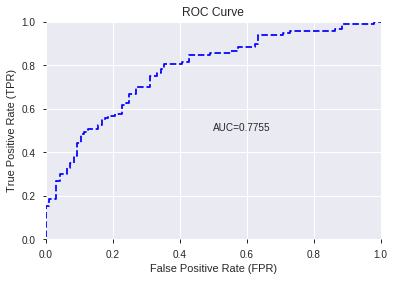

This function is available for GLM models only


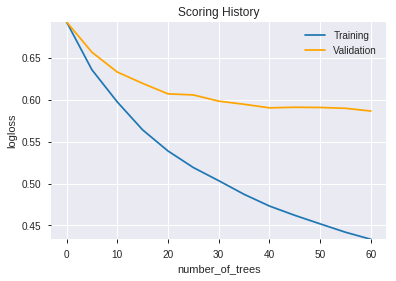

--2019-08-25 15:14:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.95.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.95.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_151432_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_151432_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_982d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHRSI_fastk',
 'DIV',
 'TRANGE',
 'ULTOSC',
 'BETA_8',
 'hour',
 'SUB',
 'weekday_name',
 'CDLCLOSINGMARUBOZU',
 'CDLHAMMER',
 'CDLLONGLINE',
 'CDLSPINNINGTOP',
 'CDLLONGLEGGEDDOJI',
 'CEIL',
 'CDLGRAVESTONEDOJI',
 'CDLMATCHINGLOW',
 'FLOOR']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 917 930 936] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


26

['hour',
 'BOP',
 'CCI_8',
 'CMO_8',
 'RSI_8',
 'WILLR_8',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'WILLR_14',
 'WILLR_20',
 'WILLR_24',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDL3OUTSIDE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_151504_model_4  0.777384  0.652372              0.254349  0.463553  0.214881
1  DeepLearning_grid_1_AutoML_20190825_151504_model_8  0.773625  0.571249              0.290861  0.441959  0.195328
2  DeepLearning_grid_1_AutoML_20190825_151504_model_7  0.768686  0.668193              0.286029  0.483079  0.233365
3  DeepLearning_grid_1_AutoML_20190825_151504_model_9  0.767504  0.583795              0.343535  0.446726  0.199564
4  DeepLearning_grid_1_AutoML_20190825_151504_model_3  0.766001  0.627533              0.259289  0.450917  0.203326
5  DeepLearning_grid_1_AutoML_20190825_151504_model_6  0.762564  0.580966              0.296338  0.446858  0.199682
6  DeepLearning_grid_1_AutoML_20190825_151504_model_2  0.762242  0.594526              0.254457  0.449915  0.202424
7  DeepLearning_grid_1_AutoML_20190825_151504_model_5  0.760524  0.592100              0.280498  0.448366  0.201032
8               DeepLearning_1_AutoML_20190825_151504  0.739261  0.603454              0.332904  0.457457  0.209267
9  DeepLearning_grid_1_AutoML_20190825_151504_model_1  0.731529  0.780267              0.338220  0.481523  0.231865

variable  relative_importance  scaled_importance  percentage
0          CDLMARUBOZU             1.000000           1.000000    0.055857
1          CDL3OUTSIDE             0.808469           0.808469    0.045159
2   CDLCLOSINGMARUBOZU             0.768536           0.768536    0.042928
3          CDLBELTHOLD             0.753889           0.753889    0.042110
4          CDLLONGLINE             0.732431           0.732431    0.040912
5                  SUB             0.724798           0.724798    0.040485
6               TRANGE             0.721120           0.721120    0.040280
7                  DIV             0.719468           0.719468    0.040188
8                 hour             0.698077           0.698077    0.038993
9               ULTOSC             0.677328           0.677328    0.037834
10            WILLR_20             0.671214           0.671214    0.037492
11                 BOP             0.665690           0.665690    0.037184
12            WILLR_14             0.659447           0.659447    0.036835
13               CCI_8             0.658515           0.658515    0.036783
14        CDLENGULFING             0.657080           0.657080    0.036703
15               RSI_8             0.654609           0.654609    0.036565
16        STOCHF_fastk             0.648718           0.648718    0.036236
17              CMO_12             0.648049           0.648049    0.036198
18             WILLR_8             0.640210           0.640210    0.035761
19               ADOSC             0.639250           0.639250    0.035707
20               CMO_8             0.639032           0.639032    0.035695
21            WILLR_24             0.634843           0.634843    0.035461
22      STOCHRSI_fastd             0.634647           0.634647    0.035450
23              RSI_12             0.633691           0.633691    0.035396
24            WILLR_12             0.630755           0.630755    0.035232
25      STOCHRSI_fastk             0.582841           0.582841    0.032556

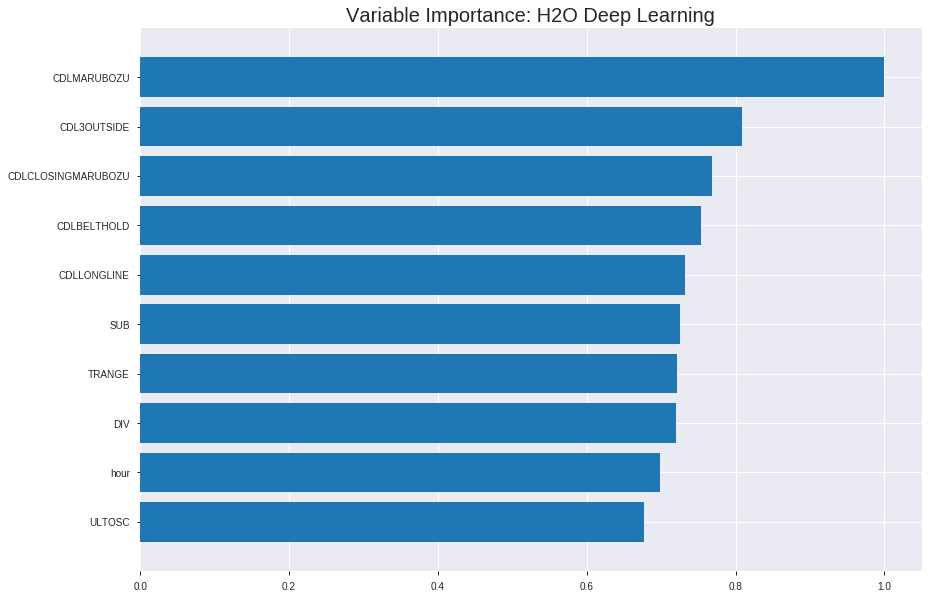

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_151504_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18439851190653078
RMSE: 0.4294164783826196
LogLoss: 0.5653300600397343
Mean Per-Class Error: 0.2658371166045168
AUC: 0.8099845124066922
pr_auc: 0.7790440636679442
Gini: 0.6199690248133845
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2754830285612751: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      451  262  0.3675   (262.0/713.0)
1      111  522  0.1754   (111.0/633.0)
Total  562  784  0.2771   (373.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.275483     0.736768  271
max f2                       0.0390994    0.84078   372
max f0point5                 0.643332     0.73274   141
max accuracy                 0.544685     0.734027  177
max precision                0.999171     1         0
max recall                   0.000973958  1         399
max specificity              0.999171     1         0
max absolute_mcc             0.377323     0.467665  237
max min_per_class_accuracy   0.413398     0.7223    223
max mean_per_class_accuracy  0.377323     0.734163  237

Gains/Lift Table: Avg response rate: 47.03 %, avg score: 43.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0104012                   0.99803            2.12638   2.12638            1                0.998876    1                           0.998876            0.0221169       0.0221169                  112.638     112.638
    2        0.0200594                   0.994238           2.12638   2.12638            1                0.99632     1                           0.997645            0.0205371       0.042654                   112.638     112.638
    3        0.0304606                   0.988607           1.9745    2.07452            0.928571         0.991689    0.97561                     0.995611            0.0205371       0.0631912                  97.4498     107.452
    4        0.0401189                   0.978767           1.79925   2.00825            0.846154         0.984888    0.944444                    0.99303             0.0173776       0.0805687                  79.9247     100.825
    5        0.0505201                   0.966533           1.9745    2.0013             0.928571         0.971739    0.941176                    0.988646            0.0205371       0.101106                   97.4498     100.13
    6        0.100297                    0.922144           1.87249   1.93737            0.880597         0.94523     0.911111                    0.967099            0.093207        0.194313                   87.2486     93.7371
    7        0.150074                    0.872864           1.80901   1.8948             0.850746         0.897762    0.891089                    0.944101            0.0900474       0.28436                    80.9012     89.4796
    8        0.200594                    0.808801           1.75114   1.85862            0.823529         0.842108    0.874074                    0.918414            0.0884676       0.372828                   75.1138     85.8616
    9        0.300149                    0.665084           1.39643   1.70532            0.656716         0.732913    0.80198                     0.856887            0.139021        0.511848                   39.643      70.5317
    10       0.400446                    0.539657           1.29158   1.60169            0.607407         0.606732    0.753247                    0.794232            0.129542        0.64139                    29.158      60.1691
    11       0.5                         0.399423           0.999717  1.48183            0.470149         0.4624      0.69688                     0.728161            0.0995261       0.740916                   -0.0282945  48.1833
    12       0.600297                    0.25141            0.929308  1.38952            0.437037         0.32695     0.653465                    0.661127            0.093207        0.834123                   -7.06922    38.9517
    13       0.699851                    0.15073            0.714084  1.29344            0.335821         0.197782    0.60828                     0.595216            0.07109         0.905213                   -28.5916    29.3436
    14       0.800149                    0.0686798          0.441027  1.18659            0.207407         0.108982    0.558032                    0.534268            0.0442338       0.949447                   -55.8973    18.6588
    15       0.899703                    0.021284           0.349108  1.09392            0.164179         0.0447207   0.514451                    0.480098            0.0347551       0.984202                   -65.0892    9.39192
    16       1                           0.000148421        0.15751   1                  0.074



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.22993628289423826
RMSE: 0.4795167180549999
LogLoss: 0.6937827751651042
Mean Per-Class Error: 0.32309833783673136
AUC: 0.7328529708780261
pr_auc: 0.6905244463751784
Gini: 0.4657059417560523
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11257651945559509: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      75   132  0.6377   (132.0/207.0)
1      11   166  0.0621   (11.0/177.0)
Total  86   298  0.3724   (143.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.112577     0.698947  297
max f2                       0.0373473    0.835735  332
max f0point5                 0.359749     0.637409  194
max accuracy                 0.359749     0.666667  194
max precision                0.999464     1         0
max recall                   0.00255509   1         379
max specificity              0.999464     1         0
max absolute_mcc             0.231636     0.363562  248
max min_per_class_accuracy   0.383438     0.655367  186
max mean_per_class_accuracy  0.258927     0.676902  236

Gains/Lift Table: Avg response rate: 46.09 %, avg score: 42.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.997746           2.16949   2.16949            1                0.998849    1                           0.998849            0.0225989       0.0225989                  116.949   116.949
    2        0.0208333                   0.996019           2.16949   2.16949            1                0.997296    1                           0.998073            0.0225989       0.0451977                  116.949   116.949
    3        0.03125                     0.994058           2.16949   2.16949            1                0.994986    1                           0.997044            0.0225989       0.0677966                  116.949   116.949
    4        0.0416667                   0.990409           1.08475   1.89831            0.5              0.991836    0.875                       0.995742            0.0112994       0.079096                   8.47458   89.8305
    5        0.0520833                   0.988322           1.08475   1.73559            0.5              0.989467    0.8                         0.994487            0.0112994       0.0903955                  8.47458   73.5593
    6        0.101562                    0.934842           1.94112   1.83572            0.894737         0.955293    0.846154                    0.975392            0.0960452       0.186441                   94.1124   83.5724
    7        0.151042                    0.854619           1.48439   1.72063            0.684211         0.897277    0.793103                    0.949803            0.0734463       0.259887                   48.4389   72.0631
    8        0.200521                    0.791581           1.37021   1.63416            0.631579         0.82449     0.753247                    0.918881            0.0677966       0.327684                   37.0205   63.4162
    9        0.299479                    0.645748           1.19893   1.49035            0.552632         0.712967    0.686957                    0.85084             0.118644        0.446328                   19.893    49.0346
    10       0.401042                    0.486907           1.0013    1.3665             0.461538         0.581232    0.62987                     0.782563            0.101695        0.548023                   0.130378  36.6498
    11       0.5                         0.372101           1.25602   1.34463            0.578947         0.424303    0.619792                    0.711657            0.124294        0.672316                   25.6021   34.4633
    12       0.598958                    0.277322           1.02765   1.29226            0.473684         0.314895    0.595652                    0.646105            0.101695        0.774011                   2.76539   29.2262
    13       0.700521                    0.168343           0.890048  1.23395            0.410256         0.226463    0.568773                    0.585265            0.0903955       0.864407                   -10.9952  23.3949
    14       0.799479                    0.0929002          0.856378  1.18721            0.394737         0.13644     0.547231                    0.52971             0.0847458       0.949153                   -14.3622  18.7214
    15       0.898438                    0.0176463          0.342551  1.09418            0.157895         0.0554385   0.504348                    0.477471            0.0338983       0.983051                   -65.7449  9.41783
    16       1                           0.000728786        0.166884  1                  0.0769231        0.00798467  0.460938 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:16:34  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 15:16:45  10.978 sec        372 obs/sec       2.9049    1             3910       0.524974         1.2085              -0.1063        0.734746        0.606194           1.82261          0.352155                         0.544462           1.31913               -0.193035        0.711974          0.683095             2.16949            0.40625
    2019-08-25 15:16:53  19.492 sec        420 obs/sec       5.82095   2             7835       0.475621         0.785162            0.0919321      0.76721         0.716596           1.9745           0.317979                         0.507166           0.88389               -0.0351889       0.724747          0.697699             2.16949            0.377604
    2019-08-25 15:17:01  27.038 sec        456 obs/sec       8.73031   3             11751      0.501098         0.883661            -0.00795591    0.755053        0.716698           2.12638          0.344725                         0.516181           0.938724              -0.072316        0.715604          0.70269              2.16949            0.427083
    2019-08-25 15:17:07  33.838 sec        487 obs/sec       11.6426   4             15671      0.493749         0.848805            0.0213917      0.76859         0.691514           2.12638          0.320208                         0.52572            0.966907              -0.112315        0.723             0.69319              2.16949            0.377604
    2019-08-25 15:17:13  39.838 sec        518 obs/sec       14.555    5             19591      0.441885         0.594825            0.21618        0.787827        0.753779           2.12638          0.314264                         0.475241           0.6994                0.0910368        0.727776          0.676735             1.62712            0.385417
    2019-08-25 15:17:19  45.507 sec        546 obs/sec       17.4695   6             23514      0.435368         0.581288            0.239131       0.807182        0.760118           2.12638          0.271917                         0.488008           0.731301              0.0415421        0.729796          0.69872              2.16949            0.398438
    2019-08-25 15:17:24  50.629 sec        574 obs/sec       20.3848   7             27438      0.442077         0.613891            0.215499       0.793752        0.751918           2.12638          0.288262                         0.490605           0.74564               0.0313149        0.726057          0.70183              2.16949            0.395833
    2019-08-25 15:17:33  59.249 sec        630 obs/sec       26.2132   9             35283      0.429416         0.56533             0.259791       0.809985        0.779044           2.12638          0.277117                         0.479517           0.693783              0.0746067        0.732853          0.690524             2.16949            0.372396
    2019-08-25 15:17:41 

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLMARUBOZU         1.0                    1.0                  0.05585747029778054
CDL3OUTSIDE         0.8084689378738403     0.8084689378738403   0.04515902968396622
CDLCLOSINGMARUBOZU  0.7685362100601196     0.7685362100601196   0.04292848852620196
CDLBELTHOLD         0.7538889646530151     0.7538889646530151   0.042110330450930315
CDLLONGLINE         0.7324314713478088     0.7324314713478088   0.04091176915596993
---                 ---                    ---                  ---
WILLR_24            0.6348426938056946     0.6348426938056946   0.03546070691301457
STOCHRSI_fastd      0.6346467733383179     0.6346467733383179   0.035449763291327346
RSI_12              0.6336908936500549     0.6336908936500549   0.03539637027003195
WILLR_12            0.6307554841041565     0.6307554841041565   0.03523240571851011
STOCHRSI_fastk      0.5828413367271423     0.5828413367271423   0.032556042654555056


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7461139896373057)

('F1', 0.7677725118483414)

('auc', 0.7773840206185567)

('logloss', 0.6523716248401392)

('mean_per_class_error', 0.25434922680412364)

('rmse', 0.46355283305805095)

('mse', 0.21488122903614526)

deeplearning prediction progress: |███████████████████████████████████████| 100%


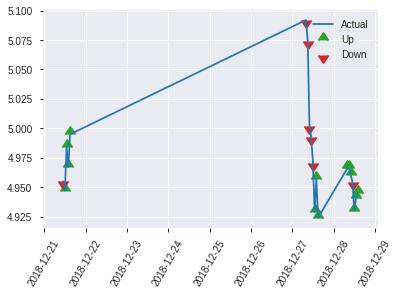


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21488122903614526
RMSE: 0.46355283305805095
LogLoss: 0.6523716248401392
Mean Per-Class Error: 0.25434922680412364
AUC: 0.7773840206185567
pr_auc: 0.7400582859984574
Gini: 0.5547680412371134
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2513179591692709: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      63   33   0.3438   (33.0/96.0)
1      16   81   0.1649   (16.0/97.0)
Total  79   114  0.2539   (49.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.251318     0.767773  113
max f2                       0.0381419    0.864865  166
max f0point5                 0.251318     0.732369  113
max accuracy                 0.251318     0.746114  113
max precision                0.999151     1         0
max recall                   0.0165328    1         177
max specificity              0.999151     1         0
max absolute_mcc             0.251318     0.499578  113
max min_per_class_accuracy   0.386269     0.721649  95
max mean_per_class_accuracy  0.251318     0.745651  113

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 42.94 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.998752           1.98969    1.98969            1                0.999057   1                           0.999057            0.0206186       0.0206186                  98.9691    98.9691
    2        0.0207254                   0.996403           1.98969    1.98969            1                0.997691   1                           0.998374            0.0206186       0.0412371                  98.9691    98.9691
    3        0.0310881                   0.995154           1.98969    1.98969            1                0.996169   1                           0.997639            0.0206186       0.0618557                  98.9691    98.9691
    4        0.0414508                   0.984642           1.98969    1.98969            1                0.993076   1                           0.996498            0.0206186       0.0824742                  98.9691    98.9691
    5        0.0518135                   0.968488           0.994845   1.79072            0.5              0.979798   0.9                         0.993158            0.0103093       0.0927835                  -0.515464  79.0722
    6        0.103627                    0.936558           1.39278    1.59175            0.7              0.949744   0.8                         0.971451            0.0721649       0.164948                   39.2784    59.1753
    7        0.150259                    0.884964           1.32646    1.50942            0.666667         0.91142    0.758621                    0.952821            0.0618557       0.226804                   32.646     50.9421
    8        0.202073                    0.797615           1.39278    1.47951            0.7              0.851863   0.74359                     0.926934            0.0721649       0.298969                   39.2784    47.9514
    9        0.300518                    0.674559           1.36137    1.44081            0.684211         0.736624   0.724138                    0.864591            0.134021        0.43299                    36.1367    44.0811
    10       0.398964                    0.49867            1.46609    1.44705            0.736842         0.612425   0.727273                    0.802368            0.14433         0.57732                    46.6088    44.7048
    11       0.502591                    0.378946           1.39278    1.43586            0.7              0.448452   0.721649                    0.729396            0.14433         0.721649                   39.2784    43.5859
    12       0.601036                    0.232498           1.15193    1.38935            0.578947         0.303868   0.698276                    0.659697            0.113402        0.835052                   15.1926    38.9353
    13       0.699482                    0.128815           0.523603   1.26751            0.263158         0.178405   0.637037                    0.59196             0.0515464       0.886598                   -47.6397   26.7507
    14       0.797927                    0.0775191          0.628323   1.18865            0.315789         0.0953586  0.597403                    0.530691            0.0618557       0.948454                   -37.1677   18.8646
    15       0.896373                    0.0231011          0.418882   1.10411            0.210526         0.0494557  0.554913                    0.477838            0.0412371       0.989691                   -58.1118   10.4106
    16       1                           0.00167188         0.0994845  1                  0.05             0.0

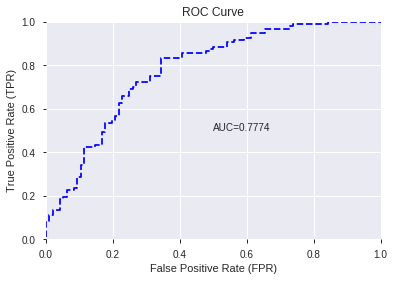

This function is available for GLM models only


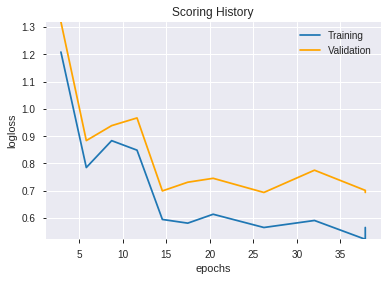

--2019-08-25 15:21:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.16.144
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.16.144|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_151504_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_151504_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_982d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLMARUBOZU',
 'CDL3OUTSIDE',
 'CDLCLOSINGMARUBOZU',
 'CDLBELTHOLD',
 'CDLLONGLINE',
 'SUB',
 'TRANGE',
 'DIV',
 'hour',
 'ULTOSC',
 'WILLR_20',
 'BOP',
 'WILLR_14',
 'CCI_8',
 'CDLENGULFING',
 'RSI_8',
 'STOCHF_fastk',
 'CMO_12',
 'WILLR_8',
 'ADOSC',
 'CMO_8',
 'WILLR_24',
 'STOCHRSI_fastd',
 'RSI_12',
 'WILLR_12',
 'STOCHRSI_fastk']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_152200_model_1  0.765893  0.576381              0.333119  0.446939  0.199755

variable  relative_importance  scaled_importance  percentage
0                  DIV             1.077733           1.000000    0.155601
1                  SUB             0.919499           0.853178    0.132755
2                  BOP             0.705334           0.654460    0.101835
3               TRANGE             0.657281           0.609873    0.094897
4                CCI_8             0.559769           0.519395    0.080818
5              WILLR_8             0.378190           0.350912    0.054602
6                 hour             0.335205           0.311028    0.048396
7   CDLCLOSINGMARUBOZU             0.324754           0.301331    0.046887
8             WILLR_12             0.211096           0.195870    0.030478
9             WILLR_14             0.195491           0.181391    0.028225
10            WILLR_20             0.180887           0.167840    0.026116
11         CDLLONGLINE             0.170657           0.158348    0.024639
12         CDLBELTHOLD             0.161942           0.150262    0.023381
13              ULTOSC             0.148737           0.138009    0.021474
14              RSI_12             0.134704           0.124988    0.019448
15              CMO_12             0.123729           0.114805    0.017864
16         CDL3OUTSIDE             0.111223           0.103201    0.016058
17      STOCHRSI_fastk             0.104528           0.096989    0.015092
18         CDLMARUBOZU             0.090105           0.083606    0.013009
19      STOCHRSI_fastd             0.074976           0.069568    0.010825
20               RSI_8             0.065009           0.060320    0.009386
21               CMO_8             0.056662           0.052575    0.008181
22        STOCHF_fastk             0.051589           0.047868    0.007448
23            WILLR_24             0.043681           0.040531    0.006307
24               ADOSC             0.034971           0.032449    0.005049
25        CDLENGULFING             0.008508           0.007894    0.001228

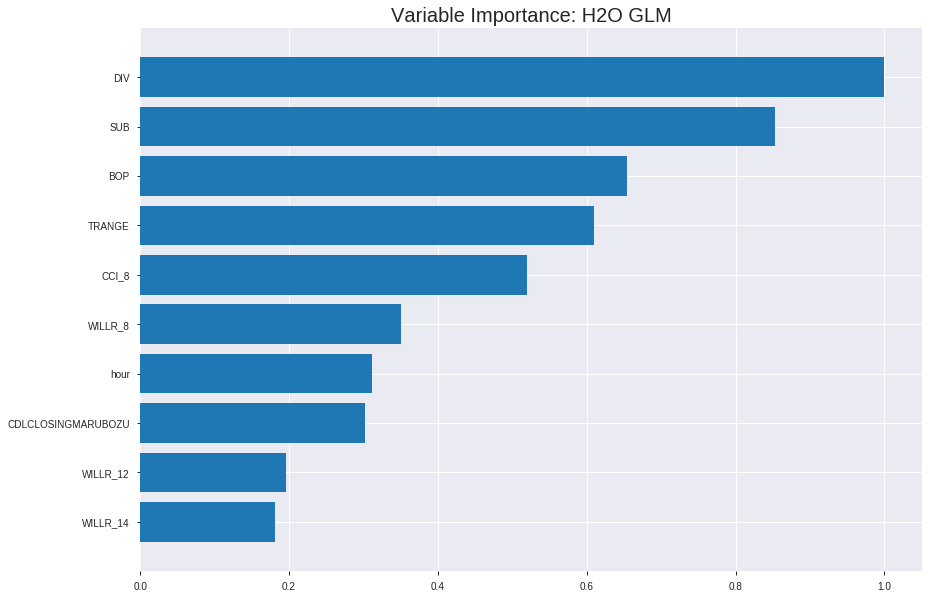

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_152200_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19143735638657147
RMSE: 0.43753554871184064
LogLoss: 0.5640718440736545
Null degrees of freedom: 1345
Residual degrees of freedom: 1319
Null deviance: 1861.1945775256659
Residual deviance: 1518.4814042462776
AIC: 1572.4814042462776
AUC: 0.7783401908585533
pr_auc: 0.7442838747265798
Gini: 0.5566803817171067
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.348676609882864: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      359  354  0.4965   (354.0/713.0)
1      80   553  0.1264   (80.0/633.0)
Total  439  907  0.3224   (434.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348677     0.718182  264
max f2                       0.148332     0.837809  346
max f0point5                 0.579096     0.691973  152
max accuracy                 0.480278     0.707281  198
max precision                0.954446     1         0
max recall                   0.0340029    1         393
max specificity              0.954446     1         0
max absolute_mcc             0.42861      0.423398  224
max min_per_class_accuracy   0.480278     0.70547   198
max mean_per_class_accuracy  0.42861      0.710335  224

Gains/Lift Table: Avg response rate: 47.03 %, avg score: 47.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.927818           1.82261   1.82261            0.857143         0.936959   0.857143                    0.936959            0.0189573       0.0189573                  82.2613   82.2613
    2        0.0200594                   0.909018           2.12638   1.96887            1                0.91618    0.925926                    0.926954            0.0205371       0.0394945                  112.638   96.8873
    3        0.0304606                   0.885487           1.9745    1.97079            0.928571         0.898392   0.926829                    0.917201            0.0205371       0.0600316                  97.4498   97.0793
    4        0.0401189                   0.869384           2.12638   2.00825            1                0.875352   0.944444                    0.907126            0.0205371       0.0805687                  112.638   100.825
    5        0.0505201                   0.853465           1.06319   1.81368            0.5              0.859532   0.852941                    0.897327            0.0110585       0.0916272                  6.31912   81.3679
    6        0.100297                    0.79286            1.87249   1.84286            0.880597         0.821312   0.866667                    0.859601            0.093207        0.184834                   87.2486   84.2865
    7        0.150074                    0.731076           1.7138    1.80006            0.80597          0.759564   0.846535                    0.826421            0.0853081       0.270142                   71.3801   80.0056
    8        0.200594                    0.694874           1.50098   1.72473            0.705882         0.714292   0.811111                    0.798181            0.0758294       0.345972                   50.0976   72.4732
    9        0.300149                    0.622356           1.44404   1.63163            0.679104         0.658171   0.767327                    0.751742            0.14376         0.489731                   44.4036   63.163
    10       0.400446                    0.54102            1.13407   1.50701            0.533333         0.58126    0.70872                     0.709043            0.113744        0.603476                   13.4071   50.7009
    11       0.5                         0.474891           1.1584    1.4376             0.544776         0.508221   0.676077                    0.669057            0.115324        0.718799                   15.8402   43.7599
    12       0.600297                    0.402702           0.96081   1.35794            0.451852         0.438308   0.638614                    0.630504            0.0963665       0.815166                   -3.91902  35.7937
    13       0.699851                    0.328664           0.682347  1.26183            0.320896         0.366243   0.593418                    0.592913            0.0679305       0.883096                   -31.7653  26.1834
    14       0.800149                    0.241501           0.582786  1.17672            0.274074         0.283307   0.553389                    0.554104            0.0584518       0.941548                   -41.7214  17.6717
    15       0.899703                    0.136301           0.444319  1.09568            0.208955         0.185836   0.515277                    0.513354            0.0442338       0.985782                   -55.5681  9.56751
    16       1                           0.000180268        0.141759  1                  0.0666667        0.0839107  0.470282                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19301612039539917
RMSE: 0.4393359994302757
LogLoss: 0.5735051583436837
Null degrees of freedom: 383
Residual degrees of freedom: 357
Null deviance: 530.1256103466318
Residual deviance: 440.45196160794904
AIC: 494.45196160794904
AUC: 0.7772319113512923
pr_auc: 0.7126913328135993
Gini: 0.5544638227025847
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37917849529111036: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      116  91   0.4396   (91.0/207.0)
1      23   154  0.1299   (23.0/177.0)
Total  139  245  0.2969   (114.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.379178     0.729858  244
max f2                       0.17631      0.827751  336
max f0point5                 0.585126     0.713376  151
max accuracy                 0.585126     0.726562  151
max precision                0.967284     1         0
max recall                   0.054405     1         375
max specificity              0.967284     1         0
max absolute_mcc             0.585126     0.448019  151
max min_per_class_accuracy   0.500968     0.714976  185
max mean_per_class_accuracy  0.562816     0.720994  157

Gains/Lift Table: Avg response rate: 46.09 %, avg score: 48.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.947492           1.62712   1.62712            0.75             0.955578   0.75                        0.955578            0.0169492       0.0169492                  62.7119   62.7119
    2        0.0208333                   0.931252           2.16949   1.89831            1                0.940051   0.875                       0.947814            0.0225989       0.039548                   116.949   89.8305
    3        0.03125                     0.905387           1.62712   1.80791            0.75             0.917934   0.833333                    0.937854            0.0169492       0.0564972                  62.7119   80.791
    4        0.0416667                   0.894547           1.08475   1.62712            0.5              0.902209   0.75                        0.928943            0.0112994       0.0677966                  8.47458   62.7119
    5        0.0520833                   0.865998           2.16949   1.73559            1                0.874544   0.8                         0.918063            0.0225989       0.0903955                  116.949   73.5593
    6        0.101562                    0.810128           1.59857   1.66884            0.736842         0.835476   0.769231                    0.877828            0.079096        0.169492                   59.8573   66.884
    7        0.151042                    0.752905           1.94112   1.75804            0.894737         0.783809   0.810345                    0.847029            0.0960452       0.265537                   94.1124   75.8036
    8        0.200521                    0.713096           1.37021   1.66234            0.631579         0.729911   0.766234                    0.81813             0.0677966       0.333333                   37.0205   66.2338
    9        0.299479                    0.638011           1.54148   1.6224             0.710526         0.673472   0.747826                    0.77033             0.152542        0.485876                   54.1481   62.2402
    10       0.401042                    0.575761           1.44633   1.57781            0.666667         0.609936   0.727273                    0.72971             0.146893        0.632768                   44.6328   57.7812
    11       0.5                         0.478232           0.970562  1.45763            0.447368         0.525466   0.671875                    0.689287            0.0960452       0.728814                   -2.9438   45.7627
    12       0.598958                    0.392398           0.970562  1.37716            0.447368         0.434404   0.634783                    0.647176            0.0960452       0.824859                   -2.9438   37.7155
    13       0.700521                    0.335882           0.723164  1.28234            0.333333         0.367079   0.591078                    0.606567            0.0734463       0.898305                   -27.6836  28.2339
    14       0.799479                    0.240444           0.342551  1.16601            0.157895         0.290474   0.537459                    0.567442            0.0338983       0.932203                   -65.7449  16.6013
    15       0.898438                    0.153196           0.456735  1.08789            0.210526         0.201336   0.501449                    0.527117            0.0451977       0.977401                   -54.3265  8.789
    16       1                           0.00033238         0.222512  1                  0.102564         0.0880478  0.460938                    0.4


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-25 15:22:01  0.000 sec   2            .18E2     27            1.361978347310756   1.3593564869856998
     2019-08-25 15:22:01  0.007 sec   4            .11E2     27            1.3518124599940615  1.3491422543186218
     2019-08-25 15:22:01  0.012 sec   6            .71E1     27            1.338129462096928   1.335554729217429
     2019-08-25 15:22:01  0.018 sec   8            .44E1     27            1.3208340441342585  1.3186504216402595
     2019-08-25 15:22:01  0.023 sec   10           .27E1     27            1.3002283848533185  1.2988956455251222
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-25 15:22:01  0.144 sec   46           .51E-3    27            1.1269621010865818  1.1470168148750337
     2019-08-25 15:22:01  0.154 sec   48           .32E-3    27            1.1258994444427615  1.147283892938705
     2019-08-25 15:22:01  0.164 sec   50           .2E-3     27            1.125051658378041   1.147790935633512
     2019-08-25 15:22:01  0.174 sec   52           .12E-3    27            1.1244612056951797  1.1484910393112138
     2019-08-25 15:22:01  0.180 sec   53           .77E-4    27            1.124105742549442   1.1492422656240062


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7253886010362695)

('F1', 0.7439999999999999)

('auc', 0.765893470790378)

('logloss', 0.5763812279548919)

('mean_per_class_error', 0.274645618556701)

('rmse', 0.44693918488348694)

('mse', 0.1997546349843157)

glm prediction progress: |████████████████████████████████████████████████| 100%


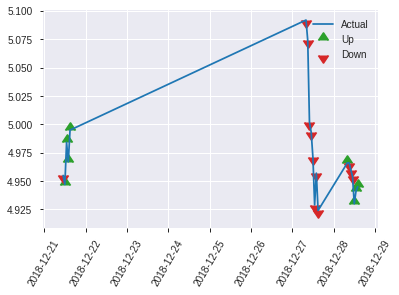


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1997546349843157
RMSE: 0.44693918488348694
LogLoss: 0.5763812279548919
Null degrees of freedom: 192
Residual degrees of freedom: 166
Null deviance: 268.35681432348866
Residual deviance: 222.48315399058828
AIC: 276.4831539905883
AUC: 0.765893470790378
pr_auc: 0.7379958095487689
Gini: 0.5317869415807559
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20809852948728508: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      36   60   0.625    (60.0/96.0)
1      4    93   0.0412   (4.0/97.0)
Total  40   153  0.3316   (64.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.208099     0.744     152
max f2                       0.137788     0.870736  168
max f0point5                 0.4357       0.725971  97
max accuracy                 0.4357       0.725389  97
max precision                0.958862     1         0
max recall                   0.137788     1         168
max specificity              0.958862     1         0
max absolute_mcc             0.4357       0.450757  97
max min_per_class_accuracy   0.438637     0.71875   96
max mean_per_class_accuracy  0.4357       0.725354  97

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 45.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.925135           1.98969   1.98969            1                0.945901   1                           0.945901            0.0206186       0.0206186                  98.9691    98.9691
    2        0.0207254                   0.906398           1.98969   1.98969            1                0.917996   1                           0.931949            0.0206186       0.0412371                  98.9691    98.9691
    3        0.0310881                   0.897569           1.98969   1.98969            1                0.904366   1                           0.922754            0.0206186       0.0618557                  98.9691    98.9691
    4        0.0414508                   0.879747           0.994845  1.74098            0.5              0.893839   0.875                       0.915526            0.0103093       0.0721649                  -0.515464  74.0979
    5        0.0518135                   0.850905           1.98969   1.79072            1                0.864168   0.9                         0.905254            0.0206186       0.0927835                  98.9691    79.0722
    6        0.103627                    0.793877           1.39278   1.59175            0.7              0.821803   0.8                         0.863528            0.0721649       0.164948                   39.2784    59.1753
    7        0.150259                    0.757881           1.76861   1.64664            0.888889         0.778178   0.827586                    0.83704             0.0824742       0.247423                   76.8614    64.6641
    8        0.202073                    0.711263           1.59175   1.63257            0.8              0.734343   0.820513                    0.810708            0.0824742       0.329897                   59.1753    63.2567
    9        0.300518                    0.602335           1.25665   1.50942            0.631579         0.661136   0.758621                    0.76171             0.123711        0.453608                   25.6647    50.9421
    10       0.398964                    0.530001           1.25665   1.44705            0.631579         0.5673     0.727273                    0.713739            0.123711        0.57732                    25.6647    44.7048
    11       0.502591                    0.438637           1.39278   1.43586            0.7              0.487101   0.721649                    0.667009            0.14433         0.721649                   39.2784    43.5859
    12       0.601036                    0.357985           0.314162  1.25213            0.157895         0.398719   0.62931                     0.623065            0.0309278       0.752577                   -68.5838   25.2133
    13       0.699482                    0.299322           1.25665   1.25277            0.631579         0.324147   0.62963                     0.580995            0.123711        0.876289                   25.6647    25.2768
    14       0.797927                    0.197919           0.837765  1.20157            0.421053         0.246162   0.603896                    0.539685            0.0824742       0.958763                   -16.2235   20.1566
    15       0.896373                    0.10574            0.418882  1.11561            0.210526         0.159552   0.560694                    0.497936            0.0412371       1                          -58.1118   11.5607
    16       1                           0.013958           0         1                  0                0.0665518  0.502591  

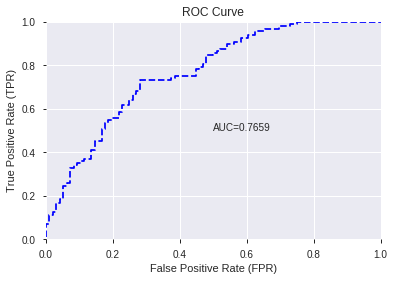

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


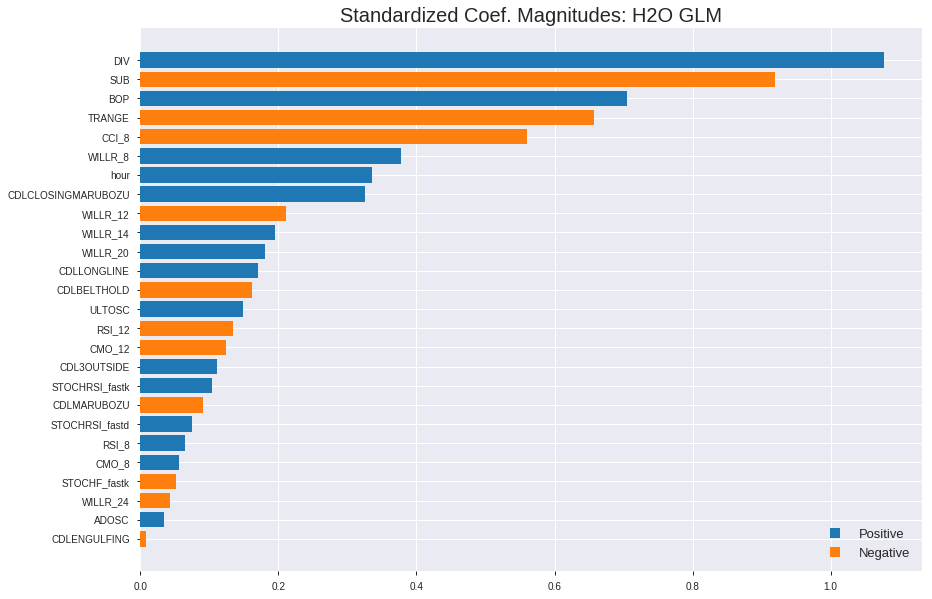

'log_likelihood'
--2019-08-25 15:22:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.105.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.105.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_152200_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_152200_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_982d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['DIV',
 'SUB',
 'BOP',
 'TRANGE',
 'CCI_8',
 'WILLR_8',
 'hour',
 'CDLCLOSINGMARUBOZU',
 'WILLR_12',
 'WILLR_14',
 'WILLR_20',
 'CDLLONGLINE',
 'CDLBELTHOLD',
 'ULTOSC',
 'RSI_12',
 'CMO_12',
 'CDL3OUTSIDE',
 'STOCHRSI_fastk',
 'CDLMARUBOZU',
 'STOCHRSI_fastd',
 'RSI_8',
 'CMO_8',
 'STOCHF_fastk',
 'WILLR_24',
 'ADOSC',
 'CDLENGULFING']

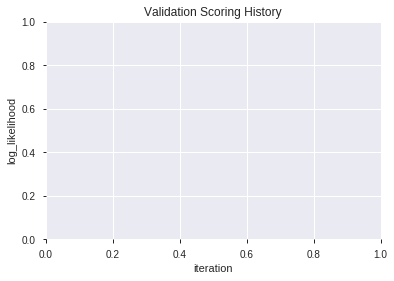

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_152218_model_5  0.786834  0.567352              0.296499  0.438671  0.192433
1  XGBoost_grid_1_AutoML_20190825_152218_model_3  0.782109  0.567865              0.291022  0.439741  0.193372
2               XGBoost_1_AutoML_20190825_152218  0.776847  0.569067              0.275397  0.439526  0.193183
3  XGBoost_grid_1_AutoML_20190825_152218_model_6  0.775666  0.569344              0.301493  0.438694  0.192453
4  XGBoost_grid_1_AutoML_20190825_152218_model_7  0.771907  0.572730              0.317547  0.442726  0.196006
5               XGBoost_3_AutoML_20190825_152218  0.769867  0.575809              0.270243  0.443261  0.196480
6               XGBoost_2_AutoML_20190825_152218  0.769759  0.577663              0.290969  0.443456  0.196653
7  XGBoost_grid_1_AutoML_20190825_152218_model_1  0.765786  0.581847              0.296231  0.446009  0.198924
8  XGBoost_grid_1_AutoML_20190825_152218_model_2  0.755155  0.587763              0.259611  0.447446  0.200208
9  XGBoost_grid_1_AutoML_20190825_152218_model_4  0.752577  0.590818              0.322541  0.449276  0.201849

variable  relative_importance  scaled_importance  percentage
0                  BOP          2591.163818           1.000000    0.131032
1                CCI_8          1385.592285           0.534737    0.070068
2                ADOSC          1266.734619           0.488867    0.064057
3               TRANGE          1237.536133           0.477599    0.062581
4              WILLR_8          1167.221680           0.450462    0.059025
5                CMO_8          1163.052979           0.448854    0.058814
6       STOCHRSI_fastd          1083.088989           0.417993    0.054770
7         STOCHF_fastk          1038.969482           0.400966    0.052539
8               ULTOSC           980.857422           0.378539    0.049601
9                  DIV           952.931091           0.367762    0.048188
10                hour           843.681213           0.325599    0.042664
11            WILLR_12           737.031006           0.284440    0.037271
12                 SUB           708.310669           0.273356    0.035818
13              CMO_12           680.164246           0.262494    0.034395
14            WILLR_14           668.988281           0.258181    0.033830
15            WILLR_24           643.104126           0.248191    0.032521
16            WILLR_20           614.678467           0.237221    0.031083
17      STOCHRSI_fastk           607.659119           0.234512    0.030729
18               RSI_8           468.977142           0.180991    0.023716
19              RSI_12           429.477020           0.165747    0.021718
20  CDLCLOSINGMARUBOZU           129.190277           0.049858    0.006533
21         CDLBELTHOLD           127.806259           0.049324    0.006463
22         CDLLONGLINE           122.252983           0.047181    0.006182
23        CDLENGULFING            62.927605           0.024285    0.003182
24         CDL3OUTSIDE            54.236763           0.020931    0.002743
25         CDLMARUBOZU             9.458875           0.003650    0.000478

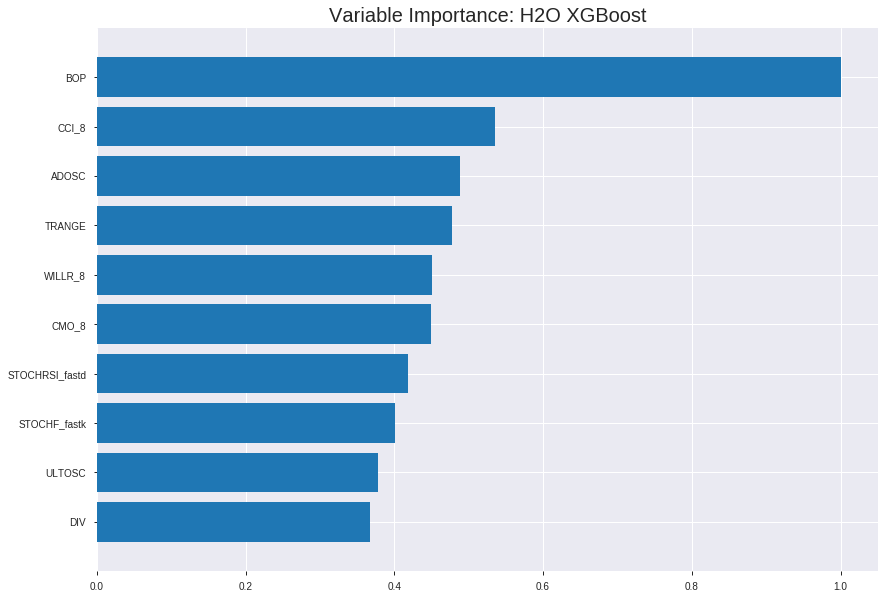

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_152218_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.028792030392673248
RMSE: 0.16968214517937133
LogLoss: 0.16531475651891717
Mean Per-Class Error: 0.0007012622720897754
AUC: 0.9999977843214152
pr_auc: 0.9984177274361001
Gini: 0.9999955686428303
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4450668692588806: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      712  1    0.0014   (1.0/713.0)
1      0    633  0        (0.0/633.0)
Total  712  634  0.0007   (1.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.445067     0.999211  191
max f2                       0.445067     0.999684  191
max f0point5                 0.517901     0.999684  189
max accuracy                 0.517901     0.999257  189
max precision                0.960889     1         0
max recall                   0.445067     1         191
max specificity              0.960889     1         0
max absolute_mcc             0.445067     0.99851   191
max min_per_class_accuracy   0.445067     0.998597  191
max mean_per_class_accuracy  0.445067     0.999299  191

Gains/Lift Table: Avg response rate: 47.03 %, avg score: 47.01 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0104012                   0.943699           2.12638  2.12638            1                0.949723   1                           0.949723            0.0221169       0.0221169                  112.638  112.638
    2        0.0200594                   0.936802           2.12638  2.12638            1                0.939738   1                           0.944916            0.0205371       0.042654                   112.638  112.638
    3        0.0304606                   0.932273           2.12638  2.12638            1                0.934353   1                           0.941309            0.0221169       0.0647709                  112.638  112.638
    4        0.0401189                   0.926245           2.12638  2.12638            1                0.929      1                           0.938346            0.0205371       0.0853081                  112.638  112.638
    5        0.0505201                   0.923789           2.12638  2.12638            1                0.924648   1                           0.935526            0.0221169       0.107425                   112.638  112.638
    6        0.100297                    0.908237           2.12638  2.12638            1                0.915702   1                           0.925687            0.105845        0.21327                    112.638  112.638
    7        0.150074                    0.890465           2.12638  2.12638            1                0.898954   1                           0.91682             0.105845        0.319115                   112.638  112.638
    8        0.200594                    0.876328           2.12638  2.12638            1                0.883526   1                           0.908435            0.107425        0.42654                    112.638  112.638
    9        0.300149                    0.834858           2.12638  2.12638            1                0.856537   1                           0.891221            0.21169         0.638231                   112.638  112.638
    10       0.400446                    0.760017           2.12638  2.12638            1                0.801512   1                           0.868752            0.21327         0.851501                   112.638  112.638
    11       0.5                         0.303992           1.49164  2                  0.701493         0.59226    0.940565                    0.8137              0.148499        1                          49.1641  100
    12       0.600297                    0.188365           0        1.66584            0                0.232314   0.783416                    0.716563            0               1                          -100     66.5842
    13       0.699851                    0.134898           0        1.42887            0                0.159889   0.671975                    0.637376            0               1                          -100     42.8875
    14       0.800149                    0.0930975          0        1.24977            0                0.112219   0.587744                    0.571548            0               1                          -100     24.9768
    15       0.899703                    0.0645919          0        1.11148            0                0.077849   0.522709                    0.516919            0               1                          -100     11.1478
    16       1                           0.0294302          0        1                  0                0.0501648  0.470282                    0.470105            0               1 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20981835028464846
RMSE: 0.4580593305289703
LogLoss: 0.6112172262409844
Mean Per-Class Error: 0.311512322934578
AUC: 0.7404951008488223
pr_auc: 0.6730469523883732
Gini: 0.4809902016976446
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2745838761329651: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      99   108  0.5217   (108.0/207.0)
1      23   154  0.1299   (23.0/177.0)
Total  122  262  0.3411   (131.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.274584     0.701595  261
max f2                       0.0801222    0.827068  355
max f0point5                 0.474079     0.658043  177
max accuracy                 0.474079     0.684896  177
max precision                0.933029     1         0
max recall                   0.0581105    1         369
max specificity              0.933029     1         0
max absolute_mcc             0.374707     0.377809  214
max min_per_class_accuracy   0.444707     0.676329  186
max mean_per_class_accuracy  0.396625     0.688488  203

Gains/Lift Table: Avg response rate: 46.09 %, avg score: 45.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.922711           1.62712   1.62712            0.75             0.931672   0.75                        0.931672            0.0169492       0.0169492                  62.7119   62.7119
    2        0.0208333                   0.908903           2.16949   1.89831            1                0.913283   0.875                       0.922478            0.0225989       0.039548                   116.949   89.8305
    3        0.03125                     0.897307           1.08475   1.62712            0.5              0.904357   0.75                        0.916437            0.0112994       0.0508475                  8.47458   62.7119
    4        0.0416667                   0.880594           1.62712   1.62712            0.75             0.886628   0.75                        0.908985            0.0169492       0.0677966                  62.7119   62.7119
    5        0.0520833                   0.870133           1.62712   1.62712            0.75             0.874094   0.75                        0.902007            0.0169492       0.0847458                  62.7119   62.7119
    6        0.101562                    0.815489           1.48439   1.55758            0.684211         0.844646   0.717949                    0.874062            0.0734463       0.158192                   48.4389   55.7584
    7        0.151042                    0.77603            1.82694   1.64582            0.842105         0.798889   0.758621                    0.849436            0.0903955       0.248588                   82.694    64.5821
    8        0.200521                    0.732618           1.48439   1.60599            0.684211         0.754828   0.74026                     0.826091            0.0734463       0.322034                   48.4389   60.5987
    9        0.299479                    0.640554           1.4273    1.54694            0.657895         0.689484   0.713043                    0.780952            0.141243        0.463277                   42.7297   54.6942
    10       0.401042                    0.548873           1.16819   1.45102            0.538462         0.597664   0.668831                    0.734535            0.118644        0.581921                   16.8188   45.1024
    11       0.5                         0.420805           1.08475   1.37853            0.5              0.488728   0.635417                    0.685885            0.107345        0.689266                   8.47458   37.8531
    12       0.598958                    0.338941           0.970562  1.31113            0.447368         0.378521   0.604348                    0.635103            0.0960452       0.785311                   -2.9438   31.1127
    13       0.700521                    0.262706           0.890048  1.25008            0.410256         0.299708   0.576208                    0.586477            0.0903955       0.875706                   -10.9952  25.0079
    14       0.799479                    0.179766           0.513827  1.15895            0.236842         0.227114   0.534202                    0.541996            0.0508475       0.926554                   -48.6173  15.8947
    15       0.898438                    0.0993116          0.456735  1.0816             0.210526         0.138084   0.498551                    0.497507            0.0451977       0.971751                   -54.3265  8.16016
    16       1                           0.0339464          0.27814   1                  0.128205         0.0655803  0.460938                   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:22:25  3.368 sec   0                  0.5              0.693147            0.5             0                  1                0.529718                         0.5                0.693147              0.5               0                    1                  0.539062
    2019-08-25 15:22:26  3.639 sec   5                  0.437389         0.574638            0.985146        0.981679           2.12638          0.0624071                        0.485836           0.664983              0.66563           0.596513             1.62712            0.372396
    2019-08-25 15:22:26  3.886 sec   10                 0.387464         0.487837            0.993561        0.991562           2.12638          0.0408618                        0.475317           0.643902              0.694096          0.613271             1.08475            0.388021
    2019-08-25 15:22:26  4.156 sec   15                 0.34551          0.41915             0.997439        0.995651           2.12638          0.0222883                        0.468688           0.630257              0.707088          0.62902              1.08475            0.351562
    2019-08-25 15:22:26  4.413 sec   20                 0.310339         0.363651            0.998447        0.992049           2.12638          0.0193165                        0.464117           0.620401              0.71443           0.639866             1.62712            0.3125
    2019-08-25 15:22:27  4.685 sec   25                 0.282346         0.321025            0.99909         0.997455           2.12638          0.013373                         0.460814           0.61354               0.721499          0.649035             1.62712            0.322917
    2019-08-25 15:22:27  4.958 sec   30                 0.258544         0.285667            0.999445        0.997819           2.12638          0.00965825                       0.458896           0.609191              0.727394          0.654435             1.62712            0.320312
    2019-08-25 15:22:27  5.217 sec   35                 0.238919         0.257297            0.999662        0.998057           2.12638          0.00742942                       0.456521           0.604276              0.734354          0.662643             1.62712            0.335938
    2019-08-25 15:22:28  5.518 sec   40                 0.221151         0.232492            0.999784        0.996605           2.12638          0.00668648                       0.455444           0.602136              0.737738          0.667899             1.62712            0.348958
    2019-08-25 15:22:28  5.800 sec   45                 0.206451         0.212315            0.999895        0.996722           2.12638          0.00520059                       0.454579           0.601234              0.741751          0.674091             1.62712            0.341146
    2019-08-25 15:22:28  6.098 sec   50                 0.192033         0.193458            0.99996         0.998376           2.12638          0.00297177                       0.456493           0.606133              0.740277          0.6719               1.62712            0.348958
    2019-08-25 15:22:28  6.376 sec   55                 0.180373         0.178511            0.99998         0.998398           2.12638          0.000742942                      0.457697           0.609577              0.739376          0.6

Variable Importances: 


variable      relative_importance    scaled_importance      percentage
------------  ---------------------  ---------------------  ----------------------
BOP           2591.163818359375      1.0                    0.13103169109810045
CCI_8         1385.59228515625       0.5347374316277516     0.07006754995963917
ADOSC         1266.734619140625      0.48886705277579573    0.06405707664735684
TRANGE        1237.5361328125        0.47759856943204004    0.06258054821871376
WILLR_8       1167.2216796875        0.4504623256226771     0.059024840302322565
---           ---                    ---                    ---
CDLBELTHOLD   127.80625915527344     0.04932388228398289    0.006462991707193916
CDLLONGLINE   122.25298309326172     0.0471807232823541     0.006182169958918379
CDLENGULFING  62.92760467529297      0.024285459772719543   0.003182164863114332
CDL3OUTSIDE   54.23676300048828      0.020931429582414018   0.0027426806152845156
CDLMARUBOZU   9.458874702453613      0.0036504348491723723  0.00047832265153049524


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7305699481865285)

('F1', 0.759493670886076)

('auc', 0.7868341924398625)

('logloss', 0.5673522820592477)

('mean_per_class_error', 0.2692762027491409)

('rmse', 0.4386714096490529)

('mse', 0.1924326056434872)

xgboost prediction progress: |████████████████████████████████████████████| 100%


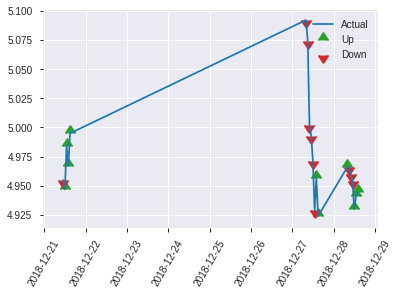


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1924326056434872
RMSE: 0.4386714096490529
LogLoss: 0.5673522820592477
Mean Per-Class Error: 0.2692762027491409
AUC: 0.7868341924398625
pr_auc: 0.7554404040681029
Gini: 0.573668384879725
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21794885396957397: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      46   50   0.5208   (50.0/96.0)
1      7    90   0.0722   (7.0/97.0)
Total  53   140  0.2953   (57.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.217949     0.759494  139
max f2                       0.149425     0.860806  157
max f0point5                 0.521833     0.745721  77
max accuracy                 0.465676     0.73057   90
max precision                0.938221     1         0
max recall                   0.0665855    1         187
max specificity              0.938221     1         0
max absolute_mcc             0.465676     0.462193  90
max min_per_class_accuracy   0.43085      0.71875   96
max mean_per_class_accuracy  0.465676     0.730724  90

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 45.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.935607           1.98969   1.98969            1                0.937513   1                           0.937513            0.0206186       0.0206186                  98.9691    98.9691
    2        0.0207254                   0.905691           1.98969   1.98969            1                0.926554   1                           0.932034            0.0206186       0.0412371                  98.9691    98.9691
    3        0.0310881                   0.90006            0.994845  1.65808            0.5              0.902417   0.833333                    0.922161            0.0103093       0.0515464                  -0.515464  65.8076
    4        0.0414508                   0.893307           1.98969   1.74098            1                0.899116   0.875                       0.9164              0.0206186       0.0721649                  98.9691    74.0979
    5        0.0518135                   0.887384           1.98969   1.79072            1                0.890435   0.9                         0.911207            0.0206186       0.0927835                  98.9691    79.0722
    6        0.103627                    0.844658           1.59175   1.69124            0.8              0.859561   0.85                        0.885384            0.0824742       0.175258                   59.1753    69.1237
    7        0.150259                    0.807382           1.76861   1.71525            0.888889         0.831546   0.862069                    0.868676            0.0824742       0.257732                   76.8614    71.5251
    8        0.202073                    0.760176           1.39278   1.63257            0.7              0.781167   0.820513                    0.846237            0.0721649       0.329897                   39.2784    63.2567
    9        0.300518                    0.684056           1.25665   1.50942            0.631579         0.724885   0.758621                    0.806484            0.123711        0.453608                   25.6647    50.9421
    10       0.398964                    0.521898           1.67553   1.55041            0.842105         0.610062   0.779221                    0.758016            0.164948        0.618557                   67.5529    55.0408
    11       0.502591                    0.43085            0.994845  1.43586            0.5              0.478489   0.721649                    0.700382            0.103093        0.721649                   -0.515464  43.5859
    12       0.601036                    0.318368           0.628323  1.30359            0.315789         0.38006    0.655172                    0.647915            0.0618557       0.783505                   -37.1677   30.359
    13       0.699482                    0.228932           1.04721   1.26751            0.526316         0.264114   0.637037                    0.593899            0.103093        0.886598                   4.72056    26.7507
    14       0.797927                    0.163509           0.628323  1.18865            0.315789         0.196496   0.597403                    0.544869            0.0618557       0.948454                   -37.1677   18.8646
    15       0.896373                    0.117845           0.314162  1.0926             0.157895         0.142127   0.549133                    0.500637            0.0309278       0.979381                   -68.5838   9.26047
    16       1                           0.0426361          0.198969  1                  0.1              0.0813046  0.502591   

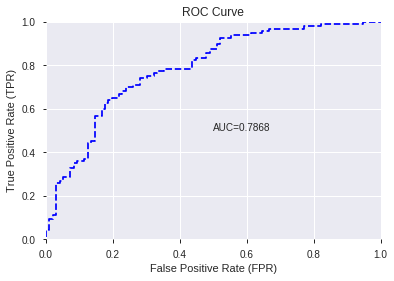

This function is available for GLM models only


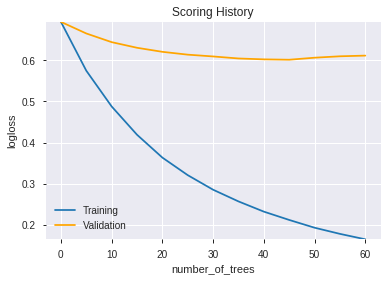

--2019-08-25 15:22:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.188
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.188|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_152218_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_152218_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_982d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'CCI_8',
 'ADOSC',
 'TRANGE',
 'WILLR_8',
 'CMO_8',
 'STOCHRSI_fastd',
 'STOCHF_fastk',
 'ULTOSC',
 'DIV',
 'hour',
 'WILLR_12',
 'SUB',
 'CMO_12',
 'WILLR_14',
 'WILLR_24',
 'WILLR_20',
 'STOCHRSI_fastk',
 'RSI_8',
 'RSI_12',
 'CDLCLOSINGMARUBOZU',
 'CDLBELTHOLD',
 'CDLLONGLINE',
 'CDLENGULFING',
 'CDL3OUTSIDE',
 'CDLMARUBOZU']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

152

['MAVP_14_6',
 'BBANDS_middleband_14_6_2',
 'BBANDS_upperband_14_6_3',
 'BBANDS_middleband_14_6_3',
 'BBANDS_lowerband_14_6_3',
 'BBANDS_upperband_14_6_4',
 'BBANDS_middleband_14_6_4',
 'BBANDS_lowerband_14_6_4',
 'BBANDS_upperband_14_6_5',
 'BBANDS_middleband_14_6_5',
 'MA_14_7',
 'BBANDS_upperband_14_7_2',
 'BBANDS_middleband_14_7_2',
 'BBANDS_lowerband_14_7_2',
 'BBANDS_upperband_14_7_3',
 'BBANDS_middleband_14_7_3',
 'BBANDS_lowerband_14_7_3',
 'BBANDS_lowerband_14_7_4',
 'EMA_20',
 'MIDPOINT_20',
 'TRIMA_20',
 'BBANDS_upperband_20_0_3',
 'BBANDS_upperband_20_0_4',
 'BBANDS_middleband_20_0_4',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_upperband_20_0_5',
 'BBANDS_upperband_20_1_4',
 'BBANDS_middleband_20_1_4',
 'BBANDS_lowerband_20_1_5',
 'MA_20_2',
 'BBANDS_lowerband_20_2_5',
 'BBANDS_lowerband_20_3_4',
 'BBANDS_upperband_20_5_2',
 'BBANDS_upperband_20_5_3',
 'BBANDS_upperband_20_5_5',
 'BBANDS_lowerband_20_5_5',
 'BBANDS_upperband_20_6_2',
 'BBANDS_middleband_20_6_3',
 'BBANDS_upperban

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_152341_model_8  0.783720  0.705494              0.296392  0.506775  0.256821
1  DeepLearning_grid_1_AutoML_20190825_152341_model_1  0.782968  1.745236              0.343482  0.611665  0.374134
2  DeepLearning_grid_1_AutoML_20190825_152341_model_3  0.781143  0.977226              0.285921  0.544524  0.296506
3  DeepLearning_grid_1_AutoML_20190825_152341_model_5  0.779854  0.815924              0.275451  0.548326  0.300661
4  DeepLearning_grid_1_AutoML_20190825_152341_model_9  0.778136  0.635664              0.275397  0.475245  0.225857
5  DeepLearning_grid_1_AutoML_20190825_152341_model_6  0.777921  0.643913              0.275505  0.479221  0.229653
6  DeepLearning_grid_1_AutoML_20190825_152341_model_7  0.777277  0.721494              0.306594  0.502678  0.252685
7  DeepLearning_grid_1_AutoML_20190825_152341_model_2  0.772552  0.582897              0.301707  0.445196  0.198199
8  DeepLearning_grid_1_AutoML_20190825_152341_model_4  0.749248  1.219140              0.332957  0.587621  0.345298
9               DeepLearning_1_AutoML_20190825_152341  0.663552  1.151843              0.416345  0.593177  0.351859

variable  relative_importance  scaled_importance  percentage
0                      TRANGE             1.000000           1.000000    0.027427
1                         BOP             0.798618           0.798618    0.021903
2          CDLCLOSINGMARUBOZU             0.572416           0.572416    0.015699
3                  aroonup_20             0.391357           0.391357    0.010734
4                   PLUS_DM_8             0.350871           0.350871    0.009623
..                        ...                  ...                ...         ...
147  BBANDS_middleband_20_0_4             0.181629           0.181629    0.004981
148  BBANDS_middleband_20_1_4             0.181358           0.181358    0.004974
149                 MAVP_24_2             0.181053           0.181053    0.004966
150   BBANDS_lowerband_14_7_2             0.180839           0.180839    0.004960
151                    EMA_24             0.179456           0.179456    0.004922

[152 rows x 4 columns]

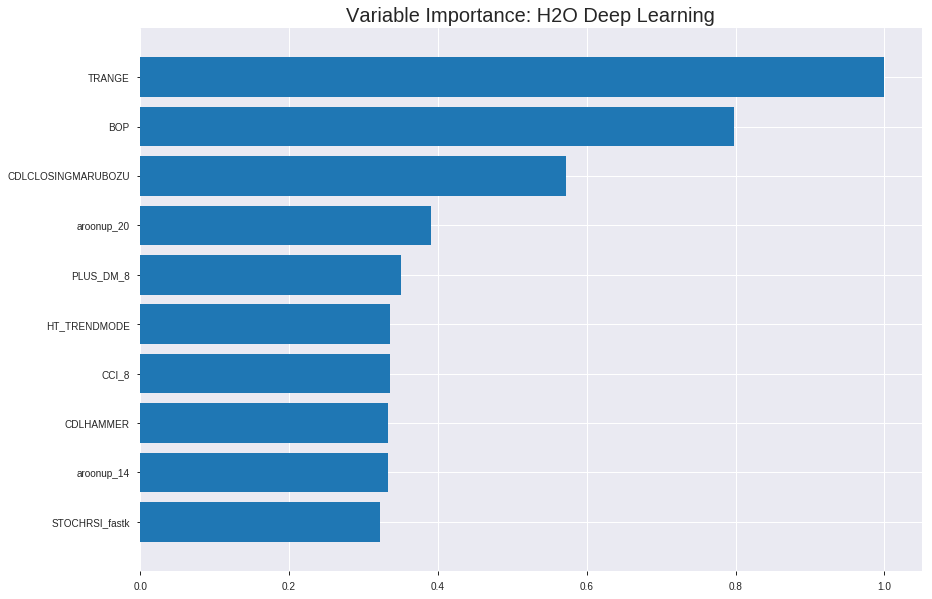

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_152341_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18952436793451613
RMSE: 0.43534396508337647
LogLoss: 0.5593543236800778
Mean Per-Class Error: 0.263806447181546
AUC: 0.8011638959605963
pr_auc: 0.7821288451883257
Gini: 0.6023277919211927
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3983277458569331: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      490  223  0.3128   (223.0/713.0)
1      136  497  0.2148   (136.0/633.0)
Total  626  720  0.2667   (359.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398328     0.734664  209
max f2                       0.20934      0.841096  319
max f0point5                 0.454535     0.71828   176
max accuracy                 0.400419     0.733284  208
max precision                0.925472     1         0
max recall                   0.0607453    1         390
max specificity              0.925472     1         0
max absolute_mcc             0.398328     0.472706  209
max min_per_class_accuracy   0.426409     0.726508  194
max mean_per_class_accuracy  0.398328     0.736194  209

Gains/Lift Table: Avg response rate: 47.03 %, avg score: 41.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.874352           2.12638   2.12638            1                0.899609  1                           0.899609            0.0221169       0.0221169                  112.638   112.638
    2        0.0200594                   0.848839           2.12638   2.12638            1                0.858523  1                           0.879827            0.0205371       0.042654                   112.638   112.638
    3        0.0304606                   0.822296           1.9745    2.07452            0.928571         0.839283  0.97561                     0.865983            0.0205371       0.0631912                  97.4498   107.452
    4        0.0401189                   0.803278           1.63568   1.96887            0.769231         0.810187  0.925926                    0.852551            0.0157978       0.0789889                  63.5679   96.8873
    5        0.0505201                   0.781124           1.82261   1.93876            0.857143         0.792689  0.911765                    0.840226            0.0189573       0.0979463                  82.2613   93.876
    6        0.100297                    0.693049           1.9677    1.95312            0.925373         0.73838   0.918519                    0.78968             0.0979463       0.195893                   96.7697   95.3122
    7        0.150074                    0.626161           1.77727   1.8948             0.835821         0.660172  0.891089                    0.746725            0.0884676       0.28436                    77.7275   89.4796
    8        0.200594                    0.571746           1.71987   1.85074            0.808824         0.59774   0.87037                     0.709203            0.0868878       0.371248                   71.9868   85.074
    9        0.300149                    0.483048           1.34882   1.68426            0.634328         0.523289  0.792079                    0.647538            0.134281        0.505529                   34.8825   68.4263
    10       0.400446                    0.454773           1.26008   1.57802            0.592593         0.466513  0.742115                    0.602198            0.126382        0.631912                   26.0078   57.802
    11       0.5                         0.418953           1.09493   1.48183            0.514925         0.441789  0.69688                     0.570259            0.109005        0.740916                   9.49282   48.1833
    12       0.600297                    0.348708           0.771798  1.3632             0.362963         0.386165  0.641089                    0.539501            0.0774092       0.818325                   -22.8202  36.3201
    13       0.699851                    0.286214           0.666478  1.26409            0.313433         0.319132  0.59448                     0.508153            0.0663507       0.884676                   -33.3522  26.4091
    14       0.800149                    0.229343           0.677292  1.19054            0.318519         0.257248  0.559889                    0.476703            0.0679305       0.952607                   -32.2708  19.0537
    15       0.899703                    0.15951            0.285633  1.09041            0.134328         0.193864  0.512799                    0.445406            0.028436        0.981043                   -71.4367  9.04074
    16       1                           0.00790525         0.189012  1                  0.0888889        0.110541  0.470282                    0.41182             



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20144361778020023
RMSE: 0.44882470718555617
LogLoss: 0.5870382489816587
Mean Per-Class Error: 0.30426594612298374
AUC: 0.756025000682333
pr_auc: 0.698984288931076
Gini: 0.512050001364666
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.299170306394547: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      82   125  0.6039   (125.0/207.0)
1      13   164  0.0734   (13.0/177.0)
Total  95   289  0.3594   (138.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.29917      0.703863  286
max f2                       0.229383     0.836557  323
max f0point5                 0.520665     0.665025  107
max accuracy                 0.44976      0.692708  196
max precision                0.935758     1         0
max recall                   0.0854327    1         374
max specificity              0.935758     1         0
max absolute_mcc             0.447003     0.390701  198
max min_per_class_accuracy   0.456232     0.677966  185
max mean_per_class_accuracy  0.447003     0.695734  198

Gains/Lift Table: Avg response rate: 46.09 %, avg score: 44.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.868675           1.62712   1.62712            0.75             0.9003    0.75                        0.9003              0.0169492       0.0169492                  62.7119   62.7119
    2        0.0208333                   0.850113           2.16949   1.89831            1                0.858617  0.875                       0.879459            0.0225989       0.039548                   116.949   89.8305
    3        0.03125                     0.834378           2.16949   1.9887             1                0.843253  0.916667                    0.86739             0.0225989       0.0621469                  116.949   98.8701
    4        0.0416667                   0.82464            1.62712   1.89831            0.75             0.830024  0.875                       0.858049            0.0169492       0.079096                   62.7119   89.8305
    5        0.0520833                   0.812416           1.62712   1.84407            0.75             0.819145  0.85                        0.850268            0.0169492       0.0960452                  62.7119   84.4068
    6        0.101562                    0.72498            1.59857   1.72447            0.736842         0.763046  0.794872                    0.807775            0.079096        0.175141                   59.8573   72.4468
    7        0.151042                    0.640484           1.82694   1.75804            0.842105         0.686092  0.810345                    0.767914            0.0903955       0.265537                   82.694    75.8036
    8        0.200521                    0.587462           1.37021   1.66234            0.631579         0.614014  0.766234                    0.729938            0.0677966       0.333333                   37.0205   66.2338
    9        0.299479                    0.506749           1.4273    1.58467            0.657895         0.548219  0.730435                    0.669892            0.141243        0.474576                   42.7297   58.4672
    10       0.401042                    0.468836           1.05693   1.45102            0.487179         0.487447  0.668831                    0.623688            0.107345        0.581921                   5.69318   45.1024
    11       0.5                         0.453276           1.14184   1.38983            0.526316         0.46083   0.640625                    0.591456            0.112994        0.694915                   14.1838   38.9831
    12       0.598958                    0.405483           1.02765   1.32999            0.473684         0.432906  0.613043                    0.565261            0.101695        0.79661                    2.76539   32.9993
    13       0.700521                    0.342952           0.778792  1.25008            0.358974         0.374884  0.576208                    0.53766             0.079096        0.875706                   -22.1208  25.0079
    14       0.799479                    0.266185           0.742194  1.18721            0.342105         0.300435  0.547231                    0.508296            0.0734463       0.949153                   -25.7806  18.7214
    15       0.898438                    0.178531           0.342551  1.09418            0.157895         0.226643  0.504348                    0.477274            0.0338983       0.983051                   -65.7449  9.41783
    16       1                           0.00516499         0.166884  1                  0.0769231        0.120416  0.460938                    0.44103          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:29:55  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 15:29:56  1 min  8.620 sec  571 obs/sec       0.584695  1             787        0.618232         1.12182             -0.534264      0.640919        0.600984           1.82261          0.461367                         0.639663           1.23867               -0.646727        0.631567          0.560101             1.08475            0.455729
    2019-08-25 15:30:06  1 min 18.472 sec  781 obs/sec       5.98217   10            8052       0.457039         0.604647            0.161499       0.759253        0.72874            1.9745           0.334324                         0.463868           0.620213              0.134019         0.75043           0.698182             1.62712            0.315104
    2019-08-25 15:30:16  1 min 28.140 sec  881 obs/sec       12.4666   21            16780      0.433671         0.557049            0.245051       0.790458        0.768218           2.12638          0.339525                         0.448592           0.588856              0.190119         0.750512          0.714307             1.62712            0.354167
    2019-08-25 15:30:26  1 min 37.927 sec  943 obs/sec       19.5632   33            26332      0.435344         0.559354            0.239215       0.801164        0.782129           2.12638          0.266716                         0.448825           0.587038              0.189277         0.756025          0.698984             1.62712            0.359375
    2019-08-25 15:30:35  1 min 47.403 sec  985 obs/sec       26.685    45            35918      0.427508         0.544157            0.266357       0.809711        0.793119           2.12638          0.29792                          0.458099           0.611515              0.155426         0.744221          0.699128             1.62712            0.330729
    2019-08-25 15:30:45  1 min 57.068 sec  1024 obs/sec      34.425    58            46336      0.416653         0.519051            0.30314        0.819505        0.799521           2.12638          0.276374                         0.453706           0.604318              0.171548         0.751139          0.70084              2.16949            0.354167
    2019-08-25 15:30:54  2 min  6.408 sec  1057 obs/sec      42.1233   71            56698      0.414348         0.51426             0.310827       0.835834        0.826051           2.12638          0.278603                         0.454689           0.605516              0.167954         0.751221          0.704408             1.62712            0.34375
    2019-08-25 15:30:55  2 min  7.399 sec  1056 obs/sec      42.1233   71            56698      0.435344         0.559354            0.239215       0.801164        0.782129           2.12638          0.266716                         0.448825           0.587038              0.189277         0.756025          0.698984             1.62712            0.359375

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
TRANGE                    1.0                    1.0                  0.027426529371689278
BOP                       0.7986176013946533     0.7986176013946533   0.0219033091013985
CDLCLOSINGMARUBOZU        0.5724157691001892     0.5724157691001892   0.015699377904044447
aroonup_20                0.3913574516773224     0.3913574516773224   0.01073357664325755
PLUS_DM_8                 0.3508705198764801     0.3508705198764801   0.009623160619052168
---                       ---                    ---                  ---
BBANDS_middleband_20_0_4  0.18162883818149567    0.18162883818149567  0.00498144866513059
BBANDS_middleband_20_1_4  0.18135787546634674    0.18135787546634674  0.0049740170982649256
MAVP_24_2                 0.18105344474315643    0.18105344474315643  0.004965667620093702
BBANDS_lowerband_14_7_2   0.18083852529525757    0.18083852529525757  0.004959773125543356
EMA_24                    0.17945609986782074    0.17945609986782074  0.0049218579939535895


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7305699481865285)

('F1', 0.7553648068669528)

('auc', 0.7837199312714777)

('logloss', 0.7054941557785281)

('mean_per_class_error', 0.2699205326460481)

('rmse', 0.5067749503790241)

('mse', 0.2568208503316623)

deeplearning prediction progress: |███████████████████████████████████████| 100%


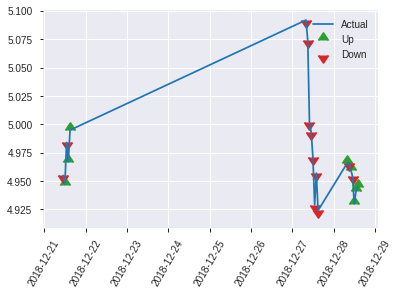


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2568208503316623
RMSE: 0.5067749503790241
LogLoss: 0.7054941557785281
Mean Per-Class Error: 0.2699205326460481
AUC: 0.7837199312714777
pr_auc: 0.7459322036488587
Gini: 0.5674398625429553
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17936503271983675: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      48   48   0.5      (48.0/96.0)
1      9    88   0.0928   (9.0/97.0)
Total  57   136  0.2953   (57.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.179365     0.755365  135
max f2                       0.0933692    0.864865  166
max f0point5                 0.297196     0.725624  85
max accuracy                 0.221217     0.73057   114
max precision                0.516891     1         0
max recall                   0.0667006    1         177
max specificity              0.516891     1         0
max absolute_mcc             0.221217     0.468849  114
max min_per_class_accuracy   0.268995     0.690722  95
max mean_per_class_accuracy  0.221217     0.730079  114

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 26.82 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.465076           1.98969    1.98969            1                0.496261   1                           0.496261            0.0206186       0.0206186                  98.9691    98.9691
    2        0.0207254                   0.463412           1.98969    1.98969            1                0.463895   1                           0.480078            0.0206186       0.0412371                  98.9691    98.9691
    3        0.0310881                   0.463297           1.98969    1.98969            1                0.463361   1                           0.474506            0.0206186       0.0618557                  98.9691    98.9691
    4        0.0414508                   0.461939           0.994845   1.74098            0.5              0.462754   0.875                       0.471568            0.0103093       0.0721649                  -0.515464  74.0979
    5        0.0518135                   0.461523           0.994845   1.59175            0.5              0.46174    0.8                         0.469602            0.0103093       0.0824742                  -0.515464  59.1753
    6        0.103627                    0.457311           1.59175    1.59175            0.8              0.459956   0.8                         0.464779            0.0824742       0.164948                   59.1753    59.1753
    7        0.150259                    0.433314           1.32646    1.50942            0.666667         0.447409   0.758621                    0.459388            0.0618557       0.226804                   32.646     50.9421
    8        0.202073                    0.412451           1.79072    1.58155            0.9              0.42399    0.794872                    0.450312            0.0927835       0.319588                   79.0722    58.1549
    9        0.300518                    0.373631           1.36137    1.50942            0.684211         0.396057   0.758621                    0.432539            0.134021        0.453608                   36.1367    50.9421
    10       0.398964                    0.312443           1.36137    1.47289            0.684211         0.34319    0.74026                     0.410492            0.134021        0.587629                   36.1367    47.2888
    11       0.502591                    0.268582           0.994845   1.37432            0.5              0.290178   0.690722                    0.385685            0.103093        0.690722                   -0.515464  37.4322
    12       0.601036                    0.217126           1.36137    1.3722             0.684211         0.239182   0.689655                    0.361688            0.134021        0.824742                   36.1367    37.22
    13       0.699482                    0.179948           0.733044   1.28225            0.368421         0.19957    0.644444                    0.338872            0.0721649       0.896907                   -26.6956   28.2245
    14       0.797927                    0.129777           0.628323   1.20157            0.315789         0.154588   0.603896                    0.316135            0.0618557       0.958763                   -37.1677   20.1566
    15       0.896373                    0.0789525          0.314162   1.10411            0.157895         0.106289   0.554913                    0.293089            0.0309278       0.989691                   -68.5838   10.4106
    16       1                           0.0171542          0.0994845  1                  0.05             0.052

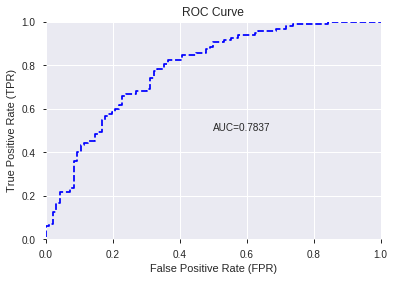

This function is available for GLM models only


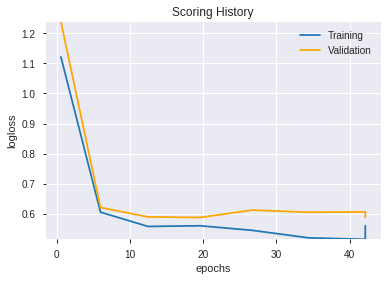

--2019-08-25 15:32:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_152341_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_152341_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_982d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TRANGE',
 'BOP',
 'CDLCLOSINGMARUBOZU',
 'aroonup_20',
 'PLUS_DM_8',
 'HT_TRENDMODE',
 'CCI_8',
 'CDLHAMMER',
 'aroonup_14',
 'STOCHRSI_fastk',
 'WILLR_14',
 'DX_8',
 'NATR_8',
 'CDLENGULFING',
 'STOCHF_fastk',
 'WILLR_8',
 'CDLDOJI',
 'STOCHRSI_fastd',
 'CCI_14',
 'AD',
 'DX_30',
 'CCI_12',
 'aroondown_12',
 'MFI_20',
 'MACDEXT_hist',
 'HT_DCPERIOD',
 'aroonup_30',
 'HT_PHASOR_quadrature',
 'ADX_20',
 'ULTOSC',
 'CDLDRAGONFLYDOJI',
 'ATR_30',
 'OBV',
 'PLUS_DM_12',
 'WILLR_20',
 'PLUS_DI_12',
 'DX_12',
 'CDLBELTHOLD',
 'DX_24',
 'DX_20',
 'MFI_24',
 'MFI_30',
 'MFI_14',
 'AROONOSC_24',
 'MACDFIX_hist_14',
 'DX_14',
 'ATR_14',
 'aroonup_24',
 'PLUS_DM_14',
 'AROONOSC_8',
 'ADOSC',
 'AROONOSC_30',
 'CDLHARAMI',
 'PLUS_DI_20',
 'NATR_14',
 'MACDFIX_signal_24',
 'CCI_20',
 'MACDFIX_signal_14',
 'RSI_8',
 'ROCR_24',
 'NATR_20',
 'ATR_12',
 'ROC_8',
 'ROCP_14',
 'MINUS_DM_30',
 'MINUS_DM_12',
 'RSI_20',
 'MOM_8',
 'MACDFIX_hist_20',
 'PLUS_DI_24',
 'CMO_12',
 'BBANDS_lowerband_30_7_3',
 '

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_153213_model_1  0.774699  0.593656              0.280606  0.453645  0.205794

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.412365           1.000000    0.076731
1                TRANGE             0.385175           0.934065    0.071672
2    CDLCLOSINGMARUBOZU             0.245854           0.596206    0.045748
3            aroonup_20             0.197931           0.479991    0.036830
4             CDLHAMMER             0.156428           0.379344    0.029107
..                  ...                  ...                ...         ...
147             MA_20_2             0.000578           0.001402    0.000108
148              ATR_14             0.000577           0.001399    0.000107
149                  AD             0.000547           0.001327    0.000102
150             TRIX_14             0.000410           0.000994    0.000076
151         MINUS_DM_12             0.000117           0.000285    0.000022

[152 rows x 4 columns]

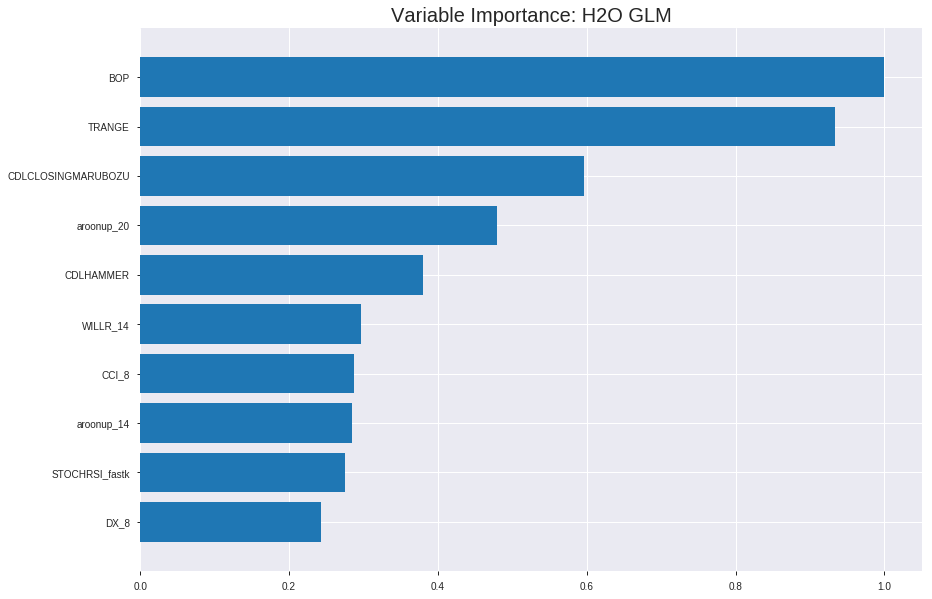

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_153213_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1914604774505937
RMSE: 0.4375619698403801
LogLoss: 0.5659048677145806
Null degrees of freedom: 1345
Residual degrees of freedom: 1193
Null deviance: 1861.1945775256659
Residual deviance: 1523.4159038876508
AIC: 1829.4159038876508
AUC: 0.7854192839369949
pr_auc: 0.7557027021812254
Gini: 0.5708385678739898
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45088797529154334: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      467  246  0.345    (246.0/713.0)
1      142  491  0.2243   (142.0/633.0)
Total  609  737  0.2883   (388.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450888     0.716788  211
max f2                       0.223118     0.832883  326
max f0point5                 0.579969     0.713392  138
max accuracy                 0.512312     0.719168  176
max precision                0.894156     1         0
max recall                   0.074765     1         386
max specificity              0.894156     1         0
max absolute_mcc             0.512312     0.435372  176
max min_per_class_accuracy   0.494728     0.71669   187
max mean_per_class_accuracy  0.512312     0.71702   176

Gains/Lift Table: Avg response rate: 47.03 %, avg score: 47.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.850448           1.82261   1.82261            0.857143         0.874123  0.857143                    0.874123            0.0189573       0.0189573                  82.2613   82.2613
    2        0.0200594                   0.832122           1.79925   1.81136            0.846154         0.838025  0.851852                    0.856743            0.0173776       0.0363349                  79.9247   81.1363
    3        0.0304606                   0.812793           1.9745    1.86707            0.928571         0.821134  0.878049                    0.844584            0.0205371       0.056872                   97.4498   86.7067
    4        0.0401189                   0.80419            2.12638   1.9295             1                0.809287  0.907407                    0.836087            0.0205371       0.0774092                  112.638   92.9495
    5        0.0505201                   0.788169           1.9745    1.93876            0.928571         0.79637   0.911765                    0.82791             0.0205371       0.0979463                  97.4498   93.876
    6        0.100297                    0.727253           1.77727   1.85862            0.835821         0.758296  0.874074                    0.793361            0.0884676       0.186414                   77.7275   85.8616
    7        0.150074                    0.684592           1.74554   1.82111            0.820896         0.70659   0.856436                    0.76458             0.0868878       0.273302                   74.5538   82.111
    8        0.200594                    0.651663           1.6886    1.78774            0.794118         0.667398  0.840741                    0.740104            0.0853081       0.35861                    68.8598   78.7736
    9        0.300149                    0.592736           1.44404   1.67374            0.679104         0.621621  0.787129                    0.700805            0.14376         0.50237                    44.4036   67.3737
    10       0.400446                    0.540423           1.16557   1.54646            0.548148         0.567507  0.727273                    0.667419            0.116904        0.619273                   16.5573   54.646
    11       0.5                         0.483408           1.06319   1.45024            0.5              0.512959  0.682021                    0.636665            0.105845        0.725118                   6.31912   45.0237
    12       0.600297                    0.422358           0.850553  1.35004            0.4              0.450253  0.634901                    0.605519            0.0853081       0.810427                   -14.9447  35.0042
    13       0.699851                    0.351144           0.682347  1.25506            0.320896         0.384817  0.590234                    0.574124            0.0679305       0.878357                   -31.7653  25.5062
    14       0.800149                    0.288714           0.567035  1.16882            0.266667         0.318742  0.549675                    0.542112            0.056872        0.935229                   -43.2965  16.8819
    15       0.899703                    0.192592           0.476056  1.09216            0.223881         0.241244  0.513625                    0.508821            0.0473934       0.982622                   -52.3944  9.21633
    16       1                           0.00584926         0.173261  1                  0.0814815        0.124581  0.470282                    0.470282            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1945981622331918
RMSE: 0.441132816998681
LogLoss: 0.5725105382690693
Null degrees of freedom: 383
Residual degrees of freedom: 231
Null deviance: 530.1256103466318
Residual deviance: 439.68809339064524
AIC: 745.6880933906452
AUC: 0.7734108463658943
pr_auc: 0.746778237319603
Gini: 0.5468216927317886
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35494193757387754: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      88   119  0.5749   (119.0/207.0)
1      14   163  0.0791   (14.0/177.0)
Total  102  282  0.3464   (133.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.354942     0.71024   281
max f2                       0.257232     0.836557  325
max f0point5                 0.580907     0.702592  138
max accuracy                 0.580907     0.713542  138
max precision                0.91806      1         0
max recall                   0.0665059    1         380
max specificity              0.91806      1         0
max absolute_mcc             0.580907     0.423204  138
max min_per_class_accuracy   0.521328     0.672316  178
max mean_per_class_accuracy  0.559216     0.707279  154

Gains/Lift Table: Avg response rate: 46.09 %, avg score: 49.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.873021           2.16949   2.16949            1                0.890255  1                           0.890255            0.0225989       0.0225989                  116.949   116.949
    2        0.0208333                   0.86211            2.16949   2.16949            1                0.869467  1                           0.879861            0.0225989       0.0451977                  116.949   116.949
    3        0.03125                     0.84429            2.16949   2.16949            1                0.853014  1                           0.870912            0.0225989       0.0677966                  116.949   116.949
    4        0.0416667                   0.833638           1.08475   1.89831            0.5              0.83801   0.875                       0.862686            0.0112994       0.079096                   8.47458   89.8305
    5        0.0520833                   0.820466           2.16949   1.95254            1                0.828712  0.9                         0.855891            0.0225989       0.101695                   116.949   95.2542
    6        0.101562                    0.769758           2.05531   2.00261            0.947368         0.792437  0.923077                    0.824978            0.101695        0.20339                    105.531   100.261
    7        0.151042                    0.705316           1.71276   1.90766            0.789474         0.735042  0.87931                     0.795516            0.0847458       0.288136                   71.2756   90.7656
    8        0.200521                    0.665999           1.48439   1.80321            0.684211         0.686709  0.831169                    0.768668            0.0734463       0.361582                   48.4389   80.3214
    9        0.299479                    0.614231           1.25602   1.6224             0.578947         0.641897  0.747826                    0.726778            0.124294        0.485876                   25.6021   62.2402
    10       0.401042                    0.559835           1.33507   1.54964            0.615385         0.586748  0.714286                    0.691316            0.135593        0.621469                   33.5072   54.9637
    11       0.5                         0.502983           0.628011  1.36723            0.289474         0.528222  0.630208                    0.659037            0.0621469       0.683616                   -37.1989  36.7232
    12       0.598958                    0.446465           0.970562  1.30169            0.447368         0.470927  0.6                         0.627958            0.0960452       0.779661                   -2.9438   30.1695
    13       0.700521                    0.382253           1.11256   1.27427            0.512821         0.411031  0.587361                    0.596508            0.112994        0.892655                   11.256    27.4274
    14       0.799479                    0.304836           0.570919  1.18721            0.263158         0.341982  0.547231                    0.565003            0.0564972       0.949153                   -42.9081  18.7214
    15       0.898438                    0.205155           0.285459  1.08789            0.131579         0.258029  0.501449                    0.531191            0.0282486       0.977401                   -71.4541  8.789
    16       1                           0.00237138         0.222512  1                  0.102564         0.128796  0.460938                    0.490323           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-25 15:32:13  0.000 sec   2            .18E2     153           1.3644291334245642  1.357566541806962
     2019-08-25 15:32:13  0.056 sec   4            .13E2     153           1.358993702342409   1.351161894669324
     2019-08-25 15:32:13  0.117 sec   6            .97E1     153           1.3522375344508726  1.3433858872584474
     2019-08-25 15:32:13  0.171 sec   8            .71E1     153           1.344033513896576   1.334165366223493
     2019-08-25 15:32:14  0.230 sec   10           .51E1     153           1.3342383227726078  1.3233630250743647
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-25 15:32:14  1.041 sec   40           .44E-1    153           1.1229585384812137  1.1465693221368902
     2019-08-25 15:32:14  1.111 sec   42           .32E-1    153           1.1153045015446936  1.1506258971572834
     2019-08-25 15:32:14  1.166 sec   44           .23E-1    153           1.108750487990001   1.1567980384610286
     2019-08-25 15:32:15  1.221 sec   46           .17E-1    153           1.1031634221414464  1.1645478374320664
     2019-08-25 15:32:15  1.275 sec   48           .12E-1    153           1.0984081678255084  1.1733968312825303


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7253886010362695)

('F1', 0.7589285714285714)

('auc', 0.7746993127147767)

('logloss', 0.5936562533684855)

('mean_per_class_error', 0.2747530068728523)

('rmse', 0.4536454741063368)

('mse', 0.20579421617716312)

glm prediction progress: |████████████████████████████████████████████████| 100%


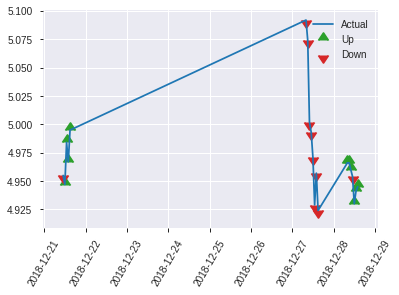


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20579421617716312
RMSE: 0.4536454741063368
LogLoss: 0.5936562533684855
Null degrees of freedom: 192
Residual degrees of freedom: 40
Null deviance: 268.35681432348866
Residual deviance: 229.15131380023539
AIC: 535.1513138002354
AUC: 0.7746993127147767
pr_auc: 0.7400760809738086
Gini: 0.5493986254295533
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3316846760499124: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      54   42   0.4375   (42.0/96.0)
1      12   85   0.1237   (12.0/97.0)
Total  66   127  0.2798   (54.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.331685     0.758929  126
max f2                       0.172566     0.860215  169
max f0point5                 0.388681     0.722772  101
max accuracy                 0.388681     0.725389  101
max precision                0.842849     1         0
max recall                   0.124083     1         178
max specificity              0.842849     1         0
max absolute_mcc             0.331685     0.462491  126
max min_per_class_accuracy   0.397546     0.71134   95
max mean_per_class_accuracy  0.388681     0.725247  101

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 40.51 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.79254            1.98969    1.98969            1                0.820778  1                           0.820778            0.0206186       0.0206186                  98.9691    98.9691
    2        0.0207254                   0.775624           0.994845   1.49227            0.5              0.791554  0.75                        0.806166            0.0103093       0.0309278                  -0.515464  49.2268
    3        0.0310881                   0.758538           1.98969    1.65808            1                0.768573  0.833333                    0.793635            0.0206186       0.0515464                  98.9691    65.8076
    4        0.0414508                   0.732189           1.98969    1.74098            1                0.744893  0.875                       0.781449            0.0206186       0.0721649                  98.9691    74.0979
    5        0.0518135                   0.725755           1.98969    1.79072            1                0.731292  0.9                         0.771418            0.0206186       0.0927835                  98.9691    79.0722
    6        0.103627                    0.644364           1.79072    1.79072            0.9              0.68031   0.9                         0.725864            0.0927835       0.185567                   79.0722    79.0722
    7        0.150259                    0.617771           0.884307   1.50942            0.444444         0.631453  0.758621                    0.696564            0.0412371       0.226804                   -11.5693   50.9421
    8        0.202073                    0.578368           1.79072    1.58155            0.9              0.592443  0.794872                    0.669866            0.0927835       0.319588                   79.0722    58.1549
    9        0.300518                    0.517218           1.25665    1.47512            0.631579         0.544194  0.741379                    0.628698            0.123711        0.443299                   25.6647    47.5116
    10       0.398964                    0.45666            1.46609    1.47289            0.736842         0.4886    0.74026                     0.594128            0.14433         0.587629                   46.6088    47.2888
    11       0.502591                    0.397123           1.19381    1.41535            0.6              0.425601  0.71134                     0.55938             0.123711        0.71134                    19.3814    41.5347
    12       0.601036                    0.353276           1.04721    1.35505            0.526316         0.373024  0.681034                    0.528856            0.103093        0.814433                   4.72056    35.5048
    13       0.699482                    0.290024           0.837765   1.28225            0.421053         0.330464  0.644444                    0.500934            0.0824742       0.896907                   -16.2235   28.2245
    14       0.797927                    0.212076           0.418882   1.17573            0.210526         0.257276  0.590909                    0.470873            0.0412371       0.938144                   -58.1118   17.5726
    15       0.896373                    0.161575           0.523603   1.10411            0.263158         0.191809  0.554913                    0.440224            0.0515464       0.989691                   -47.6397   10.4106
    16       1                           0.0254945          0.0994845  1                  0.05             0.1013    0.502591  

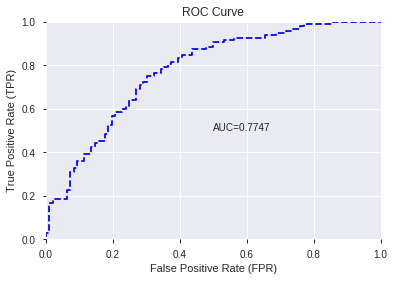

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


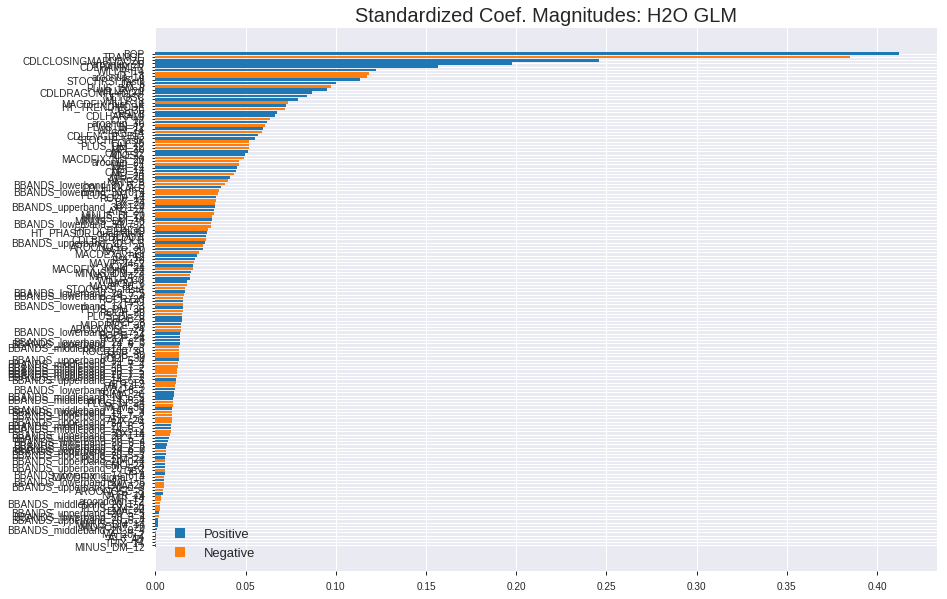

'log_likelihood'
--2019-08-25 15:32:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_153213_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_153213_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_982d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'aroonup_20',
 'CDLHAMMER',
 'WILLR_14',
 'CCI_8',
 'aroonup_14',
 'STOCHRSI_fastk',
 'DX_8',
 'PLUS_DM_8',
 'WILLR_20',
 'CDLDRAGONFLYDOJI',
 'ULTOSC',
 'WILLR_8',
 'MACDFIX_hist_14',
 'HT_TRENDMODE',
 'CCI_30',
 'RSI_8',
 'CDLHARAMI',
 'CCI_12',
 'aroonup_30',
 'PLUS_DI_12',
 'WILLR_24',
 'CCI_14',
 'CDLENGULFING',
 'STOCHF_fastk',
 'CCI_20',
 'PLUS_DM_12',
 'MFI_30',
 'CMO_12',
 'ADOSC',
 'MACDFIX_hist_20',
 'aroonup_24',
 'MFI_24',
 'RSI_14',
 'CMO_14',
 'MFI_20',
 'ATR_30',
 'NATR_8',
 'BBANDS_lowerband_30_7_3',
 'CDLHIKKAKE',
 'BBANDS_lowerband_30_0_4',
 'PLUS_DM_14',
 'ROCP_14',
 'DX_24',
 'DX_20',
 'BBANDS_upperband_30_1_4',
 'ATR_24',
 'MINUS_DI_20',
 'MINUS_DI_14',
 'MINUS_DM_30',
 'BBANDS_lowerband_30_7_2',
 'DX_30',
 'HT_DCPERIOD',
 'HT_PHASOR_quadrature',
 'CDLDOJI',
 'CDLBELTHOLD',
 'BBANDS_upperband_30_7_5',
 'AROONOSC_30',
 'NATR_20',
 'MACDEXT_hist',
 'DX_12',
 'RSI_20',
 'MAVP_24_2',
 'MOM_24',
 'MACDFIX_signal_24',
 'MINUS_D

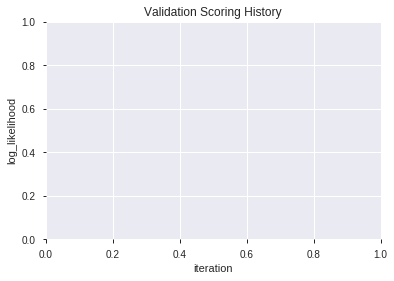

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_153233_model_6  0.797466  0.580725              0.280982  0.447237  0.200021
1  XGBoost_grid_1_AutoML_20190825_153233_model_2  0.786512  0.590486              0.291237  0.450242  0.202718
2  XGBoost_grid_1_AutoML_20190825_153233_model_7  0.783827  0.594146              0.275236  0.454089  0.206197
3               XGBoost_1_AutoML_20190825_153233  0.782109  0.594138              0.312178  0.452278  0.204555
4  XGBoost_grid_1_AutoML_20190825_153233_model_3  0.779854  0.611509              0.296392  0.461409  0.212898
5               XGBoost_3_AutoML_20190825_153233  0.772766  0.597028              0.280391  0.453671  0.205818
6               XGBoost_2_AutoML_20190825_153233  0.771370  0.595986              0.275129  0.453277  0.205460
7  XGBoost_grid_1_AutoML_20190825_153233_model_5  0.768149  0.612056              0.369631  0.460949  0.212474
8  XGBoost_grid_1_AutoML_20190825_153233_model_1  0.767290  0.592966              0.274699  0.451487  0.203840
9  XGBoost_grid_1_AutoML_20190825_153233_model_4  0.754188  0.600738              0.270028  0.455047  0.207068

variable  relative_importance  scaled_importance  percentage
0                         BOP          1619.303833           1.000000    0.167379
1                      TRANGE          1060.871216           0.655140    0.109657
2                STOCHF_fastk           203.002304           0.125364    0.020983
3                       ADOSC           171.427719           0.105865    0.017720
4                     WILLR_8           155.102097           0.095783    0.016032
..                        ...                  ...                ...         ...
130   BBANDS_upperband_20_6_4             6.700371           0.004138    0.000693
131   BBANDS_upperband_20_5_5             6.526024           0.004030    0.000675
132  BBANDS_middleband_20_0_4             6.255104           0.003863    0.000647
133              CDLENGULFING             4.807239           0.002969    0.000497
134  BBANDS_middleband_14_6_3             4.361888           0.002694    0.000451

[135 rows x 4 columns]

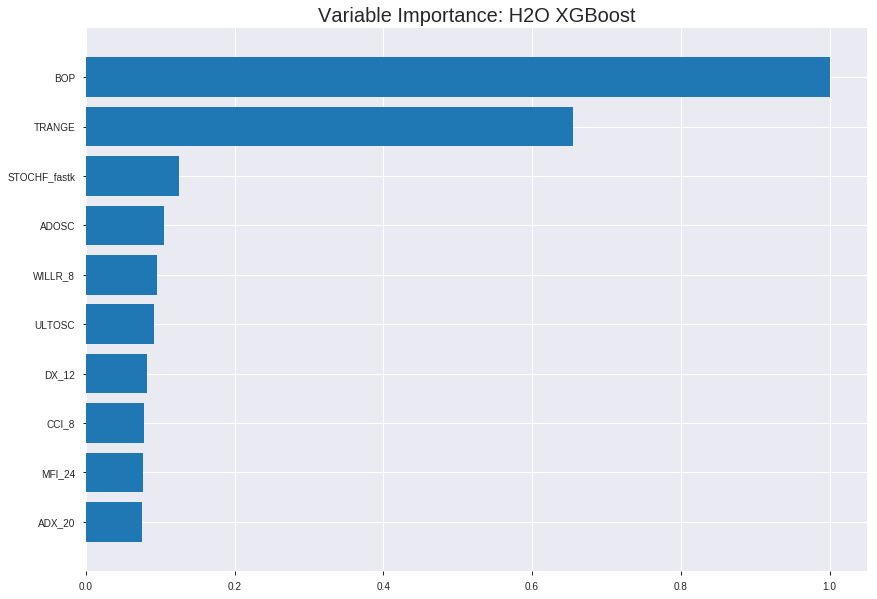

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_153233_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11522074834369067
RMSE: 0.3394418187903351
LogLoss: 0.39095407662169585
Mean Per-Class Error: 0.12231321275610474
AUC: 0.9519530098885736
pr_auc: 0.9512404114200549
Gini: 0.9039060197771471
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5722960631052653: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      676  37   0.0519   (37.0/713.0)
1      122  511  0.1927   (122.0/633.0)
Total  798  548  0.1181   (159.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.572296     0.865368  162
max f2                       0.28964      0.90645   286
max f0point5                 0.617574     0.912591  143
max accuracy                 0.572296     0.881872  162
max precision                0.934756     1         0
max recall                   0.194481     1         334
max specificity              0.934756     1         0
max absolute_mcc             0.572296     0.767391  162
max min_per_class_accuracy   0.502975     0.867299  193
max mean_per_class_accuracy  0.572296     0.877687  162

Gains/Lift Table: Avg response rate: 47.03 %, avg score: 47.05 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.90038            2.12638    2.12638            1                0.912389  1                           0.912389            0.0221169       0.0221169                  112.638   112.638
    2        0.0200594                   0.868747           2.12638    2.12638            1                0.880706  1                           0.897134            0.0205371       0.042654                   112.638   112.638
    3        0.0304606                   0.851758           2.12638    2.12638            1                0.860246  1                           0.884538            0.0221169       0.0647709                  112.638   112.638
    4        0.0401189                   0.843233           2.12638    2.12638            1                0.846991  1                           0.875499            0.0205371       0.0853081                  112.638   112.638
    5        0.0505201                   0.833357           2.12638    2.12638            1                0.838599  1                           0.867902            0.0221169       0.107425                   112.638   112.638
    6        0.100297                    0.794362           2.12638    2.12638            1                0.813488  1                           0.840897            0.105845        0.21327                    112.638   112.638
    7        0.150074                    0.761985           2.12638    2.12638            1                0.776992  1                           0.8197              0.105845        0.319115                   112.638   112.638
    8        0.200594                    0.727781           2.09511    2.11851            0.985294         0.744039  0.996296                    0.800645            0.105845        0.424961                   109.511   111.851
    9        0.300149                    0.667632           2.04704    2.0948             0.962687         0.700563  0.985149                    0.76745             0.203791        0.628752                   104.704   109.48
    10       0.400446                    0.575882           1.65385    1.98436            0.777778         0.626252  0.93321                     0.732085            0.165877        0.794629                   65.3853   98.436
    11       0.5                         0.469957           0.952111   1.77883            0.447761         0.52498   0.836553                    0.690849            0.0947867       0.889415                   -4.78885  77.8831
    12       0.600297                    0.370283           0.551284   1.57373            0.259259         0.418124  0.740099                    0.645282            0.0552923       0.944708                   -44.8716  57.3733
    13       0.699851                    0.265721           0.491924   1.41985            0.231343         0.318558  0.667728                    0.598805            0.0489731       0.993681                   -50.8076  41.9846
    14       0.800149                    0.197588           0.0472529  1.24779            0.0222222        0.230279  0.586815                    0.552611            0.00473934      0.99842                    -95.2747  24.7794
    15       0.899703                    0.140701           0.0158685  1.11148            0.00746269       0.169038  0.522709                    0.510168            0.00157978      1                          -98.4131  11.1478
    16       1                           0.075541           0          1                  0                0.114762  0.470282                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2016895798619498
RMSE: 0.4490986304387376
LogLoss: 0.5879583347507145
Mean Per-Class Error: 0.29493163023008273
AUC: 0.7501296432762903
pr_auc: 0.6861481072945032
Gini: 0.5002592865525806
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3539597690105438: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      114  93   0.4493   (93.0/207.0)
1      25   152  0.1412   (25.0/177.0)
Total  139  245  0.3073   (118.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.35396      0.720379  244
max f2                       0.221174     0.835763  320
max f0point5                 0.410866     0.664767  218
max accuracy                 0.410866     0.697917  218
max precision                0.900988     1         0
max recall                   0.102013     1         380
max specificity              0.900988     1         0
max absolute_mcc             0.35396      0.424733  244
max min_per_class_accuracy   0.482337     0.672316  184
max mean_per_class_accuracy  0.405072     0.705068  220

Gains/Lift Table: Avg response rate: 46.09 %, avg score: 46.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.864042           2.16949   2.16949            1                0.887597  1                           0.887597            0.0225989       0.0225989                  116.949   116.949
    2        0.0208333                   0.838022           1.62712   1.89831            0.75             0.850956  0.875                       0.869276            0.0169492       0.039548                   62.7119   89.8305
    3        0.03125                     0.828464           1.62712   1.80791            0.75             0.833144  0.833333                    0.857232            0.0169492       0.0564972                  62.7119   80.791
    4        0.0416667                   0.819034           2.16949   1.89831            1                0.825851  0.875                       0.849387            0.0225989       0.079096                   116.949   89.8305
    5        0.0520833                   0.808515           1.08475   1.73559            0.5              0.812898  0.8                         0.842089            0.0112994       0.0903955                  8.47458   73.5593
    6        0.101562                    0.752829           1.37021   1.55758            0.631579         0.775467  0.717949                    0.809632            0.0677966       0.158192                   37.0205   55.7584
    7        0.151042                    0.718661           1.82694   1.64582            0.842105         0.737212  0.758621                    0.785908            0.0903955       0.248588                   82.694    64.5821
    8        0.200521                    0.682605           1.37021   1.57781            0.631579         0.700446  0.727273                    0.76482             0.0677966       0.316384                   37.0205   57.7812
    9        0.299479                    0.625082           1.4273    1.52808            0.657895         0.656007  0.704348                    0.728864            0.141243        0.457627                   42.7297   52.8077
    10       0.401042                    0.530148           1.27944   1.46511            0.589744         0.577995  0.675325                    0.690657            0.129944        0.587571                   27.9444   46.5111
    11       0.5                         0.477301           1.02765   1.37853            0.473684         0.501834  0.635417                    0.653286            0.101695        0.689266                   2.76539   37.8531
    12       0.598958                    0.386232           1.19893   1.34886            0.552632         0.433242  0.621739                    0.616931            0.118644        0.80791                    19.893    34.8858
    13       0.700521                    0.304902           0.667536  1.25008            0.307692         0.342156  0.576208                    0.577094            0.0677966       0.875706                   -33.2464  25.0079
    14       0.799479                    0.238596           0.742194  1.18721            0.342105         0.268911  0.547231                    0.538947            0.0734463       0.949153                   -25.7806  18.7214
    15       0.898438                    0.173275           0.399643  1.10047            0.184211         0.206805  0.507246                    0.502363            0.039548        0.988701                   -60.0357  10.0467
    16       1                           0.0859854          0.111256  1                  0.0512821        0.138783  0.460938                    0.465437          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:32:50  10.254 sec  0                  0.5              0.693147            0.5             0                  1                0.529718                         0.5                0.693147              0.5               0                    1                  0.539062
    2019-08-25 15:32:50  10.472 sec  5                  0.467209         0.629286            0.863056        0.846835           2.12638          0.233284                         0.482764           0.659058              0.707102          0.630693             2.16949            0.351562
    2019-08-25 15:32:50  10.545 sec  10                 0.442219         0.58209             0.885158        0.879238           2.12638          0.192422                         0.47297            0.639575              0.713693          0.636167             1.62712            0.354167
    2019-08-25 15:32:50  10.621 sec  15                 0.423456         0.546865            0.894334        0.892161           2.12638          0.19688                          0.466041           0.625446              0.724774          0.661565             1.62712            0.325521
    2019-08-25 15:32:50  10.690 sec  20                 0.409245         0.51972             0.899947        0.897196           2.12638          0.191679                         0.461624           0.616145              0.727503          0.659614             1.62712            0.322917
    2019-08-25 15:32:50  10.760 sec  25                 0.398873         0.500034            0.90704         0.907952           2.12638          0.183507                         0.458277           0.608866              0.732962          0.665598             2.16949            0.307292
    2019-08-25 15:32:50  10.831 sec  30                 0.388878         0.481               0.914117        0.914828           2.12638          0.157504                         0.454718           0.601221              0.739594          0.67038              2.16949            0.299479
    2019-08-25 15:32:51  10.907 sec  35                 0.379476         0.463005            0.919902        0.920305           2.12638          0.155275                         0.452578           0.59635               0.744071          0.679831             2.16949            0.320312
    2019-08-25 15:32:51  10.983 sec  40                 0.371341         0.448135            0.927499        0.928094           2.12638          0.155275                         0.450684           0.592545              0.748055          0.686247             2.16949            0.315104
    2019-08-25 15:32:51  11.063 sec  45                 0.36339          0.433663            0.933572        0.933276           2.12638          0.145617                         0.450457           0.591893              0.747127          0.684294             2.16949            0.309896
    2019-08-25 15:32:51  11.135 sec  50                 0.357903         0.423377            0.936905        0.937011           2.12638          0.137444                         0.450447           0.591373              0.746827          0.690601             2.16949            0.307292
    2019-08-25 15:32:51  11.212 sec  55                 0.350145         0.409579            0.943492        0.942741           2.12638          0.136701                         0.448748           0.587327              0.750703          0

Variable Importances: 


variable                  relative_importance    scaled_importance      percentage
------------------------  ---------------------  ---------------------  ---------------------
BOP                       1619.3038330078125     1.0                    0.16737881729605728
TRANGE                    1060.8712158203125     0.6551403104195543     0.10965661032099684
STOCHF_fastk              203.00230407714844     0.1253639372297892     0.020983267545099278
ADOSC                     171.42771911621094     0.10586507338637534    0.01771957077637181
WILLR_8                   155.1020965576172      0.0957831960846528     0.01603207807748553
---                       ---                    ---                    ---
BBANDS_upperband_20_6_4   6.700371265411377      0.004137809797538502   0.0006925817101080327
BBANDS_upperband_20_5_5   6.526023864746094      0.004030141676762528   0.000674560347392061
BBANDS_middleband_20_0_4  6.255104064941406      0.003862835335430981   0.0006465568098538562
CDLENGULFING              4.807239055633545      0.0029687072664456244  0.0004968987111558798
BBANDS_middleband_14_6_3  4.3618879318237305     0.002693680977535663   0.0004508651361928067


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7409326424870466)

('F1', 0.773109243697479)

('auc', 0.7974656357388317)

('logloss', 0.5807248966842233)

('mean_per_class_error', 0.2594501718213058)

('rmse', 0.44723747521722085)

('mse', 0.20002135923867426)

xgboost prediction progress: |████████████████████████████████████████████| 100%


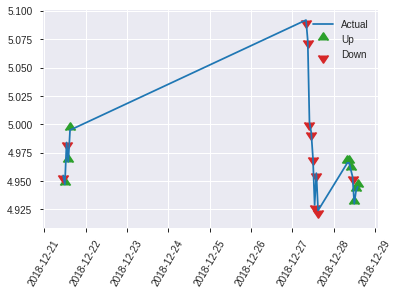


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20002135923867426
RMSE: 0.44723747521722085
LogLoss: 0.5807248966842233
Mean Per-Class Error: 0.2594501718213058
AUC: 0.7974656357388317
pr_auc: 0.7722781587870362
Gini: 0.5949312714776633
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2286829948425293: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      47   49   0.5104   (49.0/96.0)
1      5    92   0.0515   (5.0/97.0)
Total  52   141  0.2798   (54.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.228683     0.773109  140
max f2                       0.196867     0.877514  158
max f0point5                 0.314894     0.730129  110
max accuracy                 0.314894     0.740933  110
max precision                0.851064     1         0
max recall                   0.161008     1         176
max specificity              0.851064     1         0
max absolute_mcc             0.228683     0.493652  140
max min_per_class_accuracy   0.36467      0.708333  96
max mean_per_class_accuracy  0.314894     0.74055   110

Gains/Lift Table: Avg response rate: 50.26 %, avg score: 40.48 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.839028           1.98969    1.98969            1                0.850107  1                           0.850107            0.0206186       0.0206186                  98.9691   98.9691
    2        0.0207254                   0.821142           1.98969    1.98969            1                0.833632  1                           0.84187             0.0206186       0.0412371                  98.9691   98.9691
    3        0.0310881                   0.779618           1.98969    1.98969            1                0.79988   1                           0.827873            0.0206186       0.0618557                  98.9691   98.9691
    4        0.0414508                   0.765418           1.98969    1.98969            1                0.772611  1                           0.814058            0.0206186       0.0824742                  98.9691   98.9691
    5        0.0518135                   0.754691           1.98969    1.98969            1                0.760889  1                           0.803424            0.0206186       0.103093                   98.9691   98.9691
    6        0.103627                    0.704693           1.59175    1.79072            0.8              0.723732  0.9                         0.763578            0.0824742       0.185567                   59.1753   79.0722
    7        0.150259                    0.657682           1.32646    1.64664            0.666667         0.678199  0.827586                    0.737081            0.0618557       0.247423                   32.646    64.6641
    8        0.202073                    0.613365           1.59175    1.63257            0.8              0.637932  0.820513                    0.711658            0.0824742       0.329897                   59.1753   63.2567
    9        0.300518                    0.544903           1.25665    1.50942            0.631579         0.584107  0.758621                    0.669874            0.123711        0.453608                   25.6647   50.9421
    10       0.398964                    0.434788           1.36137    1.47289            0.684211         0.487417  0.74026                     0.624852            0.134021        0.587629                   36.1367   47.2888
    11       0.502591                    0.36467            1.19381    1.41535            0.6              0.399676  0.71134                     0.578424            0.123711        0.71134                    19.3814   41.5347
    12       0.601036                    0.30015            1.15193    1.3722             0.578947         0.328993  0.689655                    0.537569            0.113402        0.824742                   15.1926   37.22
    13       0.699482                    0.244401           0.837765   1.29698            0.421053         0.27176   0.651852                    0.500159            0.0824742       0.907216                   -16.2235  29.6984
    14       0.797927                    0.209014           0.523603   1.20157            0.263158         0.221299  0.603896                    0.465754            0.0515464       0.958763                   -47.6397  20.1566
    15       0.896373                    0.171447           0.314162   1.10411            0.157895         0.190748  0.554913                    0.435551            0.0309278       0.989691                   -68.5838  10.4106
    16       1                           0.0988634          0.0994845  1                  0.05             0.138711  0.502591                    0

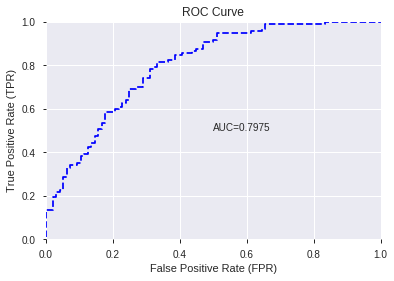

This function is available for GLM models only


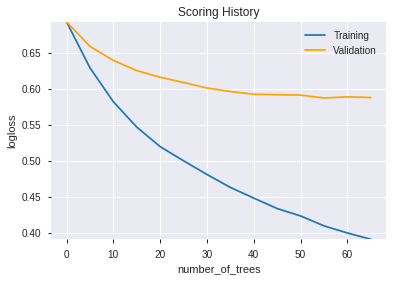

--2019-08-25 15:32:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_153233_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_153233_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_982d',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'ADOSC',
 'WILLR_8',
 'ULTOSC',
 'DX_12',
 'CCI_8',
 'MFI_24',
 'ADX_20',
 'PLUS_DI_12',
 'DX_24',
 'DX_8',
 'DX_20',
 'HT_DCPERIOD',
 'aroonup_20',
 'PLUS_DM_8',
 'NATR_8',
 'MACDEXT_hist',
 'HT_PHASOR_quadrature',
 'WILLR_14',
 'MACDFIX_hist_20',
 'MFI_30',
 'PLUS_DM_12',
 'ROCP_20',
 'OBV',
 'MINUS_DM_30',
 'CDLCLOSINGMARUBOZU',
 'PPO',
 'CCI_30',
 'BBANDS_lowerband_14_6_3',
 'CDLHAMMER',
 'AD',
 'MACDFIX_hist_14',
 'BBANDS_upperband_24_6_4',
 'MOM_8',
 'DX_14',
 'WILLR_20',
 'MFI_14',
 'MAVP_14_6',
 'STOCHRSI_fastd',
 'PLUS_DI_20',
 'MINUS_DM_24',
 'MACDFIX_signal_14',
 'DX_30',
 'ATR_24',
 'BBANDS_lowerband_14_6_4',
 'MINUS_DM_12',
 'MOM_30',
 'PLUS_DM_30',
 'NATR_20',
 'EMA_20',
 'ATR_12',
 'PLUS_DM_20',
 'BBANDS_upperband_14_6_4',
 'aroondown_12',
 'WILLR_24',
 'MIDPRICE_30',
 'MOM_24',
 'BBANDS_lowerband_14_7_4',
 'NATR_14',
 'PLUS_DM_24',
 'MAVP_24_2',
 'MIDPOINT_20',
 'ROC_8',
 'TRIX_14',
 'MA_14_7',
 'BBANDS_lowerband_30_0_4',
 'BBANDS_up

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.746
GLM             0.725
XGBoost         0.741
dtype: float64

DeepLearning    GLM  XGBoost
All          0.710  0.715    0.720
DLF          0.720  0.694    0.725
Fwe          0.746  0.725    0.731
RFE          0.731  0.725    0.741
XGBF         0.720  0.694    0.725





F1


DeepLearning    0.768
GLM             0.770
XGBoost         0.773
dtype: float64

DeepLearning    GLM  XGBoost
All          0.757  0.770    0.762
DLF          0.752  0.751    0.746
Fwe          0.768  0.744    0.759
RFE          0.755  0.759    0.773
XGBF         0.755  0.751    0.746





auc


DeepLearning    0.784
GLM             0.775
XGBoost         0.797
dtype: float64

DeepLearning    GLM  XGBoost
All          0.769  0.755    0.789
DLF          0.777  0.754    0.775
Fwe          0.777  0.766    0.787
RFE          0.784  0.775    0.797
XGBF         0.772  0.754    0.775





logloss


DeepLearning    1.848
GLM             0.650
XGBoost         0.592
dtype: float64

DeepLearning    GLM  XGBoost
All          1.848  0.650    0.592
DLF          0.576  0.577    0.575
Fwe          0.652  0.576    0.567
RFE          0.705  0.594    0.581
XGBF         0.619  0.577    0.575





mean_per_class_error


DeepLearning    0.290
GLM             0.307
XGBoost         0.280
dtype: float64

DeepLearning    GLM  XGBoost
All          0.290  0.286    0.280
DLF          0.280  0.307    0.275
Fwe          0.254  0.275    0.269
RFE          0.270  0.275    0.259
XGBF         0.280  0.307    0.275





rmse


DeepLearning    0.644
GLM             0.482
XGBoost         0.451
dtype: float64

DeepLearning    GLM  XGBoost
All          0.644  0.482    0.451
DLF          0.445  0.446    0.441
Fwe          0.464  0.447    0.439
RFE          0.507  0.454    0.447
XGBF         0.450  0.446    0.441





mse


DeepLearning    0.414
GLM             0.232
XGBoost         0.203
dtype: float64

DeepLearning    GLM  XGBoost
All          0.414  0.232    0.203
DLF          0.198  0.199    0.194
Fwe          0.215  0.200    0.192
RFE          0.257  0.206    0.200
XGBF         0.202  0.199    0.194

{'F1':       DeepLearning    GLM  XGBoost
 All          0.757    NaN      NaN
 DLF          0.752    NaN      NaN
 DLF            NaN  0.751      NaN
 DLF            NaN    NaN    0.746
 All            NaN  0.770      NaN
 All            NaN    NaN    0.762
 XGBF         0.755    NaN      NaN
 XGBF           NaN  0.751      NaN
 XGBF           NaN    NaN    0.746
 Fwe          0.768    NaN      NaN
 Fwe            NaN  0.744      NaN
 Fwe            NaN    NaN    0.759
 RFE          0.755    NaN      NaN
 RFE            NaN  0.759      NaN
 RFE            NaN    NaN    0.773,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.710    NaN      NaN
 DLF          0.720    NaN      NaN
 DLF            NaN  0.694      NaN
 DLF            NaN    NaN    0.725
 All            NaN  0.715      NaN
 All            NaN    NaN    0.720
 XGBF         0.720    NaN      NaN
 XGBF           NaN  0.694      NaN
 XGBF           NaN    NaN    0.725
 Fwe          0.746    NaN      NaN
 Fwe     